# Stock Predict Model

## Set Up

### Import Modules

In [2]:
# Numerical Operations
import math
import numpy as np

# Reading/Writing Data
import pandas as pd
import os
import csv

# For Progress Bar
from tqdm import tqdm

# For Graph
import matplotlib.pyplot as plt

# Pytorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

# For plotting learning curve
from torch.utils.tensorboard import SummaryWriter

# Yahoo API
import yfinance as yf

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

### Configurations

In [21]:
device = 'cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu')
scaler = StandardScaler()
config = {
    'seed': 666999,
    'select_all': False,
    'valid_ratio': 0.2,
    'test_ratio': 0.2,
    'n_epochs': 5000,
    'learning_rate': 1e-5,
    'early_stop': 300,
    'save_path': './models/stock.ckpt',
    'data_loader': {
        'batch_size': 128,
        'pin_memory': True,
        'num_workers': 0
    }
}

### Utility Functions

In [4]:
def same_seed(seed):
    '''Fixes random number generator seeds for reproducibility.'''
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.backends.mps.is_available():
        torch.mps.manual_seed(seed)

def predict(test_loader, model, device):
    model.eval()
    result = {'features': [], 'preds': [], 'ans': []}
    for x, y in tqdm(test_loader):
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            pred = model(x)
            result['features'].append(x.detach().cpu())
            result['preds'].append(pred.detach().cpu())
            result['ans'].append(y.detach().cpu())

    # Combination tensor
    result['features'] = torch.cat(result['features'], 0).numpy()
    result['preds'] = torch.cat(result['preds'], 0).numpy()
    result['ans'] = torch.cat(result['ans'], 0).numpy()

    predstack = np.column_stack((result['features'], result['preds']))
    targetstack = np.column_stack((result['features'], result['ans']))

    return np.column_stack((predstack[:, -1], targetstack[:, -1]))

def plot_error_rate(pred, target):
    '''Plot error rate.'''
    errors = (np.absolute(pred - target) / target) * 100
    plt.plot(errors, '-r')

    plt.xlabel('')
    plt.ylabel('Percentage')
    plt.title('Error Rate')

    plt.show()

def plot_pred(pred, target):
    '''Plot predict.'''
    plt.plot(pred, '-g', label='Prediction')
    plt.plot(target, '--r', label='Target')

    plt.xlabel('Predictions')
    plt.ylabel('Targets')
    plt.title('Predictions')
    plt.legend()

    plt.show()

def plot_trend(pred, target):
    X = np.array(pred).reshape(-1, 1)
    y = np.array(target)

    model = LinearRegression()
    model.fit(X, y)

    y_pred = model.predict(X)

    plt.scatter(pred, target, c='b', label='Data')
    plt.plot(pred, y_pred, c='r', label='Trend Line')

    plt.xlabel('Predictions')
    plt.ylabel('Targets')
    plt.title('Trend')
    plt.legend()

    plt.show()



## Data

### Dataset

In [5]:
class Stock_Dataset(Dataset):
    '''
    x: Features.
    y: Targets, if none, do prediction.
    '''
    def __init__(self, x, y=None, normalized=False, initscaler=True):
        # Normalized
        stack = np.column_stack((x, y))

        if (normalized):
            normalstack = scaler.fit_transform(stack) if initscaler else scaler.transform(stack)
            x = normalstack[:, :-1]
            y = y if y is None else normalstack[:, -1]

        self.y = y if y is None else torch.FloatTensor(y)
        self.x = torch.FloatTensor(x)

    def __getitem__(self, idx):
        if self.y is None:
            return self.x[idx]
        else:
            return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)

### DataLoader

In [6]:
def stock_dataloader(config, x, y=None, normalized=False, initscaler=True):
    ''' Generates a dataset, then is put into a dataloader. '''

    x = np.array(x)
    y = np.array(y) if y is not None else y

    dataset = Stock_Dataset(x, y, normalized, initscaler)
    dataloader = DataLoader(dataset, **config['data_loader'])

    return dataloader

### Feature Selection

In [7]:
def select_feat(train_data, valid_data, test_data, select_all=True):
    '''Selects useful features to perform regression'''
    y_train, y_valid, y_test = train_data[:,-1], valid_data[:,-1], test_data[:, -1]
    raw_x_train, raw_x_valid, raw_x_test = train_data[:, :-1], valid_data[:, :-1], test_data[:, :-1]

    if select_all:
        feat_idx = list(range(raw_x_train.shape[1]))
    else:
        feat_idx = [0,1,2,3] # TODO: Select suitable feature columns.

    return raw_x_train[:,feat_idx], raw_x_valid[:,feat_idx], raw_x_test[:,feat_idx], y_train, y_valid, y_test

### Set Data

In [8]:
same_seed(config['seed'])

# re-index
index = ["Open", "High", "Low", "Adj Close", "Volume", "Close"]
raw_data = pd.DataFrame(yf.download('2330.TW', start='2000-01-01', end='2023-12-31'))
# raw_data.to_csv("raw.csv", index=False)
train_data, test_data = train_test_split(
    raw_data[index].values,
    test_size=config['test_ratio'],
    random_state=config['seed'],
    shuffle=False
)

train_data, valid_data = train_test_split(
    train_data,
    test_size=config['valid_ratio'],
    random_state=config['seed'],
    shuffle=True
)

# Print out the data size.
print(f"""train_data size: {train_data.shape}
valid_data size: {valid_data.shape}
test_data size: {test_data.shape}""")

# Select features
x_train, x_valid, x_test, y_train, y_valid, y_test = select_feat(train_data, valid_data, test_data, config['select_all'])

# Print out the number of features.
print(f'number of features: {x_train.shape[1]}')

# Pytorch data loader loads pytorch dataset into batches.
train_loader = stock_dataloader(config, x_train, y_train)
valid_loader = stock_dataloader(config, x_valid, y_valid, initscaler=False)
test_loader = stock_dataloader(config, x_test, y_test, initscaler=False)

[*********************100%***********************]  1 of 1 completed
train_data size: (3736, 6)
valid_data size: (935, 6)
test_data size: (1168, 6)
number of features: 4


## Neural Network

### Model

In [9]:
class Stock_Model(nn.Module):
    def __init__(self, input_dim):
        super(Stock_Model, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        x = self.layers(x)
        x = x.squeeze(1)
        return x

### Training Loop

In [10]:
def trainer(train_loader, valid_loader, model, config, device):

    criterion = nn.MSELoss(reduction='mean')
    optimizer = torch.optim.SGD(model.parameters(), lr=config['learning_rate'], momentum=0.7)

    writer = SummaryWriter()

    if not os.path.isdir('./models'):
        os.mkdir('./models')

    n_epochs, best_loss, step, early_stop_count = config['n_epochs'], math.inf, 0, 0

    for epoch in range(n_epochs):
        model.train()
        loss_record = []

        train_pbar = tqdm(train_loader, position=0, leave=True)
        for x, y in train_pbar:
            optimizer.zero_grad()
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()
            step += 1
            loss_record.append(loss.detach().item())

            train_pbar.set_description(f'Epoch [{epoch+1}/{n_epochs}]')
            train_pbar.set_postfix({'loss': loss.detach().item()})
        mean_train_loss = sum(loss_record)/len(loss_record)
        writer.add_scalar('Loss/train', mean_train_loss, step)

        model.eval()
        loss_record = []
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                loss = criterion(pred, y)

            loss_record.append(loss.item())

        mean_valid_loss = sum(loss_record)/len(loss_record)
        print(f'Epoch [{epoch+1}/{n_epochs}]: Train loss: {mean_train_loss:.4f}, Valid loss: {mean_valid_loss:.4f}')
        writer.add_scalar('Loss/valid', mean_valid_loss, step)

        if mean_valid_loss < best_loss:
            best_loss = mean_valid_loss
            torch.save(model.state_dict(), config['save_path']) # Save your best model
            print('Saving model with loss {:.3f}...'.format(best_loss))
            early_stop_count = 0
        else: 
            early_stop_count += 1

        if early_stop_count >= config['early_stop']:
            print('\nModel is not improving, so we halt the training session.')
            return

## Training

In [22]:
model = Stock_Model(input_dim=x_train.shape[1]).to(device)
trainer(train_loader, valid_loader, model, config, device)

# with torch.profiler.profile(
#     activities=[torch.profiler.ProfilerActivity.CPU],
#     schedule = torch.profiler.schedule(
#         wait=0,
#         warmup=0,
#         active=1
#     ),
#     on_trace_ready=torch.profiler.tensorboard_trace_handler('./log')
# ) as prof:
#     trainer(train_loader, valid_loader, model, config, device)
#     prof.step()

Epoch [1/3000]: 100%|██████████| 14/14 [00:00<00:00, 114.12it/s, loss=1.03e+4]


Epoch [1/3000]: Train loss: 10437.6611, Valid loss: 10098.9014
Saving model with loss 10098.901...


Epoch [2/3000]: 100%|██████████| 14/14 [00:00<00:00, 90.30it/s, loss=1.02e+4]


Epoch [2/3000]: Train loss: 10299.3621, Valid loss: 9967.4131
Saving model with loss 9967.413...


Epoch [3/3000]: 100%|██████████| 14/14 [00:00<00:00, 62.49it/s, loss=1e+4]  


Epoch [3/3000]: Train loss: 10168.1405, Valid loss: 9819.6509
Saving model with loss 9819.651...


Epoch [4/3000]: 100%|██████████| 14/14 [00:00<00:00, 82.60it/s, loss=9.89e+3]


Epoch [4/3000]: Train loss: 10031.2770, Valid loss: 9671.9695
Saving model with loss 9671.969...


Epoch [5/3000]: 100%|██████████| 14/14 [00:00<00:00, 67.55it/s, loss=9.74e+3]


Epoch [5/3000]: Train loss: 9886.3475, Valid loss: 9521.4458
Saving model with loss 9521.446...


Epoch [6/3000]: 100%|██████████| 14/14 [00:00<00:00, 61.49it/s, loss=9.58e+3]


Epoch [6/3000]: Train loss: 9730.0528, Valid loss: 9362.8662
Saving model with loss 9362.866...


Epoch [7/3000]: 100%|██████████| 14/14 [00:00<00:00, 52.57it/s, loss=9.38e+3]


Epoch [7/3000]: Train loss: 9539.2183, Valid loss: 9117.4998
Saving model with loss 9117.500...


Epoch [8/3000]: 100%|██████████| 14/14 [00:00<00:00, 87.51it/s, loss=9.18e+3]


Epoch [8/3000]: Train loss: 9336.1462, Valid loss: 8960.4941
Saving model with loss 8960.494...


Epoch [9/3000]: 100%|██████████| 14/14 [00:00<00:00, 68.76it/s, loss=8.96e+3]


Epoch [9/3000]: Train loss: 9124.0952, Valid loss: 8761.5951
Saving model with loss 8761.595...


Epoch [10/3000]: 100%|██████████| 14/14 [00:00<00:00, 55.96it/s, loss=8.71e+3]


Epoch [10/3000]: Train loss: 8889.7668, Valid loss: 8541.6384
Saving model with loss 8541.638...


Epoch [11/3000]: 100%|██████████| 14/14 [00:00<00:00, 64.23it/s, loss=8.44e+3]


Epoch [11/3000]: Train loss: 8629.7844, Valid loss: 8287.8137
Saving model with loss 8287.814...


Epoch [12/3000]: 100%|██████████| 14/14 [00:00<00:00, 101.03it/s, loss=8.13e+3]


Epoch [12/3000]: Train loss: 8336.5225, Valid loss: 7969.6154
Saving model with loss 7969.615...


Epoch [13/3000]: 100%|██████████| 14/14 [00:00<00:00, 86.29it/s, loss=7.79e+3]

Epoch [13/3000]: Train loss: 8006.7870, Valid loss: 7666.1798


Saving model with loss 7666.180...


Epoch [14/3000]: 100%|██████████| 14/14 [00:00<00:00, 59.82it/s, loss=7.43e+3]


Epoch [14/3000]: Train loss: 7657.1181, Valid loss: 7376.8303
Saving model with loss 7376.830...


Epoch [15/3000]: 100%|██████████| 14/14 [00:00<00:00, 91.56it/s, loss=7.04e+3]


Epoch [15/3000]: Train loss: 7278.9788, Valid loss: 6993.3826
Saving model with loss 6993.383...


Epoch [16/3000]: 100%|██████████| 14/14 [00:00<00:00, 79.84it/s, loss=6.64e+3]


Epoch [16/3000]: Train loss: 6886.7521, Valid loss: 6499.7578
Saving model with loss 6499.758...


Epoch [17/3000]: 100%|██████████| 14/14 [00:00<00:00, 88.42it/s, loss=6.21e+3]


Epoch [17/3000]: Train loss: 6467.9531, Valid loss: 6254.2683
Saving model with loss 6254.268...


Epoch [18/3000]: 100%|██████████| 14/14 [00:00<00:00, 70.76it/s, loss=5.77e+3]


Epoch [18/3000]: Train loss: 6029.1828, Valid loss: 5632.8329
Saving model with loss 5632.833...


Epoch [19/3000]: 100%|██████████| 14/14 [00:00<00:00, 49.22it/s, loss=5.31e+3]


Epoch [19/3000]: Train loss: 5576.2204, Valid loss: 5246.9095
Saving model with loss 5246.910...


Epoch [20/3000]: 100%|██████████| 14/14 [00:00<00:00, 79.98it/s, loss=4.84e+3]


Epoch [20/3000]: Train loss: 5110.4788, Valid loss: 4870.7349
Saving model with loss 4870.735...


Epoch [21/3000]: 100%|██████████| 14/14 [00:00<00:00, 60.91it/s, loss=4.4e+3] 


Epoch [21/3000]: Train loss: 4640.7818, Valid loss: 4248.6082
Saving model with loss 4248.608...


Epoch [22/3000]: 100%|██████████| 14/14 [00:00<00:00, 39.42it/s, loss=3.93e+3]


Epoch [22/3000]: Train loss: 4190.2642, Valid loss: 3963.7862
Saving model with loss 3963.786...


Epoch [23/3000]: 100%|██████████| 14/14 [00:00<00:00, 65.78it/s, loss=3.51e+3]


Epoch [23/3000]: Train loss: 3753.0398, Valid loss: 3696.2493
Saving model with loss 3696.249...


Epoch [24/3000]: 100%|██████████| 14/14 [00:00<00:00, 102.63it/s, loss=3.14e+3]


Epoch [24/3000]: Train loss: 3342.5038, Valid loss: 3668.1210
Saving model with loss 3668.121...


Epoch [25/3000]: 100%|██████████| 14/14 [00:00<00:00, 97.33it/s, loss=2.76e+3]


Epoch [25/3000]: Train loss: 2976.4033, Valid loss: 2570.0093
Saving model with loss 2570.009...


Epoch [26/3000]: 100%|██████████| 14/14 [00:00<00:00, 56.58it/s, loss=2.43e+3]


Epoch [26/3000]: Train loss: 2656.4183, Valid loss: 2707.5152


Epoch [27/3000]: 100%|██████████| 14/14 [00:00<00:00, 85.31it/s, loss=2.16e+3]


Epoch [27/3000]: Train loss: 2317.9137, Valid loss: 2838.3019


Epoch [28/3000]: 100%|██████████| 14/14 [00:00<00:00, 56.25it/s, loss=2e+3]  


Epoch [28/3000]: Train loss: 2126.3901, Valid loss: 2835.7571


Epoch [29/3000]: 100%|██████████| 14/14 [00:00<00:00, 96.14it/s, loss=1.71e+3]


Epoch [29/3000]: Train loss: 1848.8277, Valid loss: 1573.8904
Saving model with loss 1573.890...


Epoch [30/3000]: 100%|██████████| 14/14 [00:00<00:00, 85.30it/s, loss=1.5e+3] 


Epoch [30/3000]: Train loss: 1614.3146, Valid loss: 1152.1984
Saving model with loss 1152.198...


Epoch [31/3000]: 100%|██████████| 14/14 [00:00<00:00, 103.53it/s, loss=1.41e+3]


Epoch [31/3000]: Train loss: 1433.4041, Valid loss: 726.3155
Saving model with loss 726.316...


Epoch [32/3000]: 100%|██████████| 14/14 [00:00<00:00, 88.66it/s, loss=1.12e+3]


Epoch [32/3000]: Train loss: 1275.1689, Valid loss: 1240.0482


Epoch [33/3000]: 100%|██████████| 14/14 [00:00<00:00, 56.29it/s, loss=1.07e+3]


Epoch [33/3000]: Train loss: 1058.9159, Valid loss: 674.0169
Saving model with loss 674.017...


Epoch [34/3000]: 100%|██████████| 14/14 [00:00<00:00, 98.35it/s, loss=924]     


Epoch [34/3000]: Train loss: 979.5777, Valid loss: 887.5993


Epoch [35/3000]: 100%|██████████| 14/14 [00:00<00:00, 106.49it/s, loss=733]


Epoch [35/3000]: Train loss: 825.9597, Valid loss: 1025.5780


Epoch [36/3000]: 100%|██████████| 14/14 [00:00<00:00, 90.50it/s, loss=715]


Epoch [36/3000]: Train loss: 694.5702, Valid loss: 721.3936


Epoch [37/3000]: 100%|██████████| 14/14 [00:00<00:00, 105.93it/s, loss=493]


Epoch [37/3000]: Train loss: 579.9272, Valid loss: 554.9870
Saving model with loss 554.987...


Epoch [38/3000]: 100%|██████████| 14/14 [00:00<00:00, 60.57it/s, loss=387]


Epoch [38/3000]: Train loss: 456.9286, Valid loss: 447.7719
Saving model with loss 447.772...


Epoch [39/3000]: 100%|██████████| 14/14 [00:00<00:00, 82.13it/s, loss=311]


Epoch [39/3000]: Train loss: 367.8884, Valid loss: 338.4927
Saving model with loss 338.493...


Epoch [40/3000]: 100%|██████████| 14/14 [00:00<00:00, 91.02it/s, loss=252]


Epoch [40/3000]: Train loss: 300.8862, Valid loss: 275.7747
Saving model with loss 275.775...


Epoch [41/3000]: 100%|██████████| 14/14 [00:00<00:00, 84.70it/s, loss=204]


Epoch [41/3000]: Train loss: 247.1608, Valid loss: 226.1829
Saving model with loss 226.183...


Epoch [42/3000]: 100%|██████████| 14/14 [00:00<00:00, 116.71it/s, loss=165]


Epoch [42/3000]: Train loss: 203.4257, Valid loss: 191.4337
Saving model with loss 191.434...


Epoch [43/3000]: 100%|██████████| 14/14 [00:00<00:00, 76.13it/s, loss=132]


Epoch [43/3000]: Train loss: 167.3890, Valid loss: 173.5675
Saving model with loss 173.568...


Epoch [44/3000]: 100%|██████████| 14/14 [00:00<00:00, 112.09it/s, loss=104] 


Epoch [44/3000]: Train loss: 137.4392, Valid loss: 168.5865
Saving model with loss 168.587...


Epoch [45/3000]: 100%|██████████| 14/14 [00:00<00:00, 91.12it/s, loss=81.8]


Epoch [45/3000]: Train loss: 113.0339, Valid loss: 161.9004
Saving model with loss 161.900...


Epoch [46/3000]: 100%|██████████| 14/14 [00:00<00:00, 110.70it/s, loss=65.1]


Epoch [46/3000]: Train loss: 94.6216, Valid loss: 129.6009
Saving model with loss 129.601...


Epoch [47/3000]: 100%|██████████| 14/14 [00:00<00:00, 71.52it/s, loss=51.9]


Epoch [47/3000]: Train loss: 79.7689, Valid loss: 101.0389
Saving model with loss 101.039...


Epoch [48/3000]: 100%|██████████| 14/14 [00:00<00:00, 74.39it/s, loss=41.5]


Epoch [48/3000]: Train loss: 67.7431, Valid loss: 77.5275
Saving model with loss 77.527...


Epoch [49/3000]: 100%|██████████| 14/14 [00:00<00:00, 114.11it/s, loss=33.4]


Epoch [49/3000]: Train loss: 58.6073, Valid loss: 61.0212
Saving model with loss 61.021...


Epoch [50/3000]: 100%|██████████| 14/14 [00:00<00:00, 74.65it/s, loss=27.2]


Epoch [50/3000]: Train loss: 52.1425, Valid loss: 46.8358
Saving model with loss 46.836...


Epoch [51/3000]: 100%|██████████| 14/14 [00:00<00:00, 144.16it/s, loss=29.6]


Epoch [51/3000]: Train loss: 55.2180, Valid loss: 12.2472
Saving model with loss 12.247...


Epoch [52/3000]: 100%|██████████| 14/14 [00:00<00:00, 75.10it/s, loss=25.8]


Epoch [52/3000]: Train loss: 50.9385, Valid loss: 23.7481


Epoch [53/3000]: 100%|██████████| 14/14 [00:00<00:00, 105.95it/s, loss=22.3]


Epoch [53/3000]: Train loss: 48.2013, Valid loss: 26.5003


Epoch [54/3000]: 100%|██████████| 14/14 [00:00<00:00, 130.84it/s, loss=19.1]


Epoch [54/3000]: Train loss: 45.4305, Valid loss: 27.7307


Epoch [55/3000]: 100%|██████████| 14/14 [00:00<00:00, 121.44it/s, loss=16.5]


Epoch [55/3000]: Train loss: 42.5021, Valid loss: 28.2964


Epoch [56/3000]: 100%|██████████| 14/14 [00:00<00:00, 101.44it/s, loss=14] 


Epoch [56/3000]: Train loss: 39.4347, Valid loss: 30.1674


Epoch [57/3000]: 100%|██████████| 14/14 [00:00<00:00, 81.57it/s, loss=12.6]


Epoch [57/3000]: Train loss: 36.8733, Valid loss: 30.0217


Epoch [58/3000]: 100%|██████████| 14/14 [00:00<00:00, 143.08it/s, loss=11.1]


Epoch [58/3000]: Train loss: 34.6455, Valid loss: 29.6112


Epoch [59/3000]: 100%|██████████| 14/14 [00:00<00:00, 143.14it/s, loss=10.2]


Epoch [59/3000]: Train loss: 33.6996, Valid loss: 22.0869


Epoch [60/3000]: 100%|██████████| 14/14 [00:00<00:00, 111.51it/s, loss=9.32]


Epoch [60/3000]: Train loss: 32.6605, Valid loss: 19.9491


Epoch [61/3000]: 100%|██████████| 14/14 [00:00<00:00, 87.17it/s, loss=8.77]


Epoch [61/3000]: Train loss: 32.0530, Valid loss: 17.3534


Epoch [62/3000]: 100%|██████████| 14/14 [00:00<00:00, 125.69it/s, loss=8.16]


Epoch [62/3000]: Train loss: 31.0935, Valid loss: 17.4343


Epoch [63/3000]: 100%|██████████| 14/14 [00:00<00:00, 126.03it/s, loss=7.72]


Epoch [63/3000]: Train loss: 30.6444, Valid loss: 15.7581


Epoch [64/3000]: 100%|██████████| 14/14 [00:00<00:00, 70.01it/s, loss=7.06]


Epoch [64/3000]: Train loss: 29.8698, Valid loss: 16.1356


Epoch [65/3000]: 100%|██████████| 14/14 [00:00<00:00, 128.35it/s, loss=6.66]


Epoch [65/3000]: Train loss: 29.5851, Valid loss: 15.1003


Epoch [66/3000]: 100%|██████████| 14/14 [00:00<00:00, 121.44it/s, loss=6.2]


Epoch [66/3000]: Train loss: 29.0109, Valid loss: 15.0211


Epoch [67/3000]: 100%|██████████| 14/14 [00:00<00:00, 65.50it/s, loss=5.88] 


Epoch [67/3000]: Train loss: 28.6817, Valid loss: 14.9404


Epoch [68/3000]: 100%|██████████| 14/14 [00:00<00:00, 119.22it/s, loss=5.47]


Epoch [68/3000]: Train loss: 28.1790, Valid loss: 14.7135


Epoch [69/3000]: 100%|██████████| 14/14 [00:00<00:00, 150.79it/s, loss=5.24]


Epoch [69/3000]: Train loss: 27.9757, Valid loss: 14.7809


Epoch [70/3000]: 100%|██████████| 14/14 [00:00<00:00, 126.03it/s, loss=4.94]


Epoch [70/3000]: Train loss: 27.5515, Valid loss: 13.5186


Epoch [71/3000]: 100%|██████████| 14/14 [00:00<00:00, 142.91it/s, loss=4.75]


Epoch [71/3000]: Train loss: 27.3359, Valid loss: 14.7924


Epoch [72/3000]: 100%|██████████| 14/14 [00:00<00:00, 73.24it/s, loss=4.38]


Epoch [72/3000]: Train loss: 26.9360, Valid loss: 13.4171


Epoch [73/3000]: 100%|██████████| 14/14 [00:00<00:00, 131.53it/s, loss=4.37]


Epoch [73/3000]: Train loss: 26.8278, Valid loss: 15.5759


Epoch [74/3000]: 100%|██████████| 14/14 [00:00<00:00, 120.25it/s, loss=4.06]


Epoch [74/3000]: Train loss: 26.4611, Valid loss: 13.6532


Epoch [75/3000]: 100%|██████████| 14/14 [00:00<00:00, 73.39it/s, loss=4.05]


Epoch [75/3000]: Train loss: 26.3778, Valid loss: 16.5665


Epoch [76/3000]: 100%|██████████| 14/14 [00:00<00:00, 125.98it/s, loss=3.8]


Epoch [76/3000]: Train loss: 26.0458, Valid loss: 14.3144


Epoch [77/3000]: 100%|██████████| 14/14 [00:00<00:00, 44.56it/s, loss=3.67]


Epoch [77/3000]: Train loss: 25.9568, Valid loss: 17.1821


Epoch [78/3000]: 100%|██████████| 14/14 [00:00<00:00, 120.60it/s, loss=3.56]


Epoch [78/3000]: Train loss: 25.7612, Valid loss: 14.8514


Epoch [79/3000]: 100%|██████████| 14/14 [00:00<00:00, 132.67it/s, loss=3.39]


Epoch [79/3000]: Train loss: 25.6734, Valid loss: 17.4162


Epoch [80/3000]: 100%|██████████| 14/14 [00:00<00:00, 58.87it/s, loss=3.37]


Epoch [80/3000]: Train loss: 25.5257, Valid loss: 15.0620


Epoch [81/3000]: 100%|██████████| 14/14 [00:00<00:00, 132.42it/s, loss=3.08]


Epoch [81/3000]: Train loss: 25.3675, Valid loss: 17.4969


Epoch [82/3000]: 100%|██████████| 14/14 [00:00<00:00, 81.00it/s, loss=3.12]


Epoch [82/3000]: Train loss: 25.2520, Valid loss: 15.7196


Epoch [83/3000]: 100%|██████████| 14/14 [00:00<00:00, 134.63it/s, loss=2.79]


Epoch [83/3000]: Train loss: 25.1072, Valid loss: 17.3384


Epoch [84/3000]: 100%|██████████| 14/14 [00:00<00:00, 105.24it/s, loss=2.83]


Epoch [84/3000]: Train loss: 24.9923, Valid loss: 15.9174


Epoch [85/3000]: 100%|██████████| 14/14 [00:00<00:00, 71.90it/s, loss=2.42]


Epoch [85/3000]: Train loss: 24.6699, Valid loss: 15.9116


Epoch [86/3000]: 100%|██████████| 14/14 [00:00<00:00, 65.48it/s, loss=2.4]


Epoch [86/3000]: Train loss: 24.5291, Valid loss: 15.3116


Epoch [87/3000]: 100%|██████████| 14/14 [00:00<00:00, 126.16it/s, loss=2.24]


Epoch [87/3000]: Train loss: 24.4012, Valid loss: 14.1331


Epoch [88/3000]: 100%|██████████| 14/14 [00:00<00:00, 158.35it/s, loss=2.2]


Epoch [88/3000]: Train loss: 24.2848, Valid loss: 13.6800


Epoch [89/3000]: 100%|██████████| 14/14 [00:00<00:00, 82.34it/s, loss=2.17]


Epoch [89/3000]: Train loss: 24.2026, Valid loss: 13.2966


Epoch [90/3000]: 100%|██████████| 14/14 [00:00<00:00, 157.86it/s, loss=2.2]


Epoch [90/3000]: Train loss: 24.1753, Valid loss: 13.5671


Epoch [91/3000]: 100%|██████████| 14/14 [00:00<00:00, 132.35it/s, loss=2.07]


Epoch [91/3000]: Train loss: 24.0659, Valid loss: 12.6147


Epoch [92/3000]: 100%|██████████| 14/14 [00:00<00:00, 72.72it/s, loss=2.11]


Epoch [92/3000]: Train loss: 24.0016, Valid loss: 12.7282


Epoch [93/3000]: 100%|██████████| 14/14 [00:00<00:00, 145.75it/s, loss=2]


Epoch [93/3000]: Train loss: 23.9215, Valid loss: 11.9119
Saving model with loss 11.912...


Epoch [94/3000]: 100%|██████████| 14/14 [00:00<00:00, 136.34it/s, loss=2]


Epoch [94/3000]: Train loss: 23.8274, Valid loss: 11.4291
Saving model with loss 11.429...


Epoch [95/3000]: 100%|██████████| 14/14 [00:00<00:00, 147.69it/s, loss=2]


Epoch [95/3000]: Train loss: 23.7389, Valid loss: 11.5725


Epoch [96/3000]: 100%|██████████| 14/14 [00:00<00:00, 148.65it/s, loss=1.95]


Epoch [96/3000]: Train loss: 23.7119, Valid loss: 10.8926
Saving model with loss 10.893...


Epoch [97/3000]: 100%|██████████| 14/14 [00:00<00:00, 145.33it/s, loss=1.95]


Epoch [97/3000]: Train loss: 23.6385, Valid loss: 10.4797
Saving model with loss 10.480...


Epoch [98/3000]: 100%|██████████| 14/14 [00:00<00:00, 95.56it/s, loss=1.94]


Epoch [98/3000]: Train loss: 23.5660, Valid loss: 10.2695
Saving model with loss 10.270...


Epoch [99/3000]: 100%|██████████| 14/14 [00:00<00:00, 139.75it/s, loss=1.94]


Epoch [99/3000]: Train loss: 23.5293, Valid loss: 9.9218
Saving model with loss 9.922...


Epoch [100/3000]: 100%|██████████| 14/14 [00:00<00:00, 151.73it/s, loss=1.93]


Epoch [100/3000]: Train loss: 23.4782, Valid loss: 9.6404
Saving model with loss 9.640...


Epoch [101/3000]: 100%|██████████| 14/14 [00:00<00:00, 134.21it/s, loss=1.92]


Epoch [101/3000]: Train loss: 23.3903, Valid loss: 9.3935
Saving model with loss 9.394...


Epoch [102/3000]: 100%|██████████| 14/14 [00:00<00:00, 123.32it/s, loss=1.92]


Epoch [102/3000]: Train loss: 23.3537, Valid loss: 9.1651
Saving model with loss 9.165...


Epoch [103/3000]: 100%|██████████| 14/14 [00:00<00:00, 125.87it/s, loss=1.92]


Epoch [103/3000]: Train loss: 23.3028, Valid loss: 8.9740
Saving model with loss 8.974...


Epoch [104/3000]: 100%|██████████| 14/14 [00:00<00:00, 76.28it/s, loss=1.92]


Epoch [104/3000]: Train loss: 23.2550, Valid loss: 8.7202
Saving model with loss 8.720...


Epoch [105/3000]: 100%|██████████| 14/14 [00:00<00:00, 125.83it/s, loss=1.92]


Epoch [105/3000]: Train loss: 23.2078, Valid loss: 8.5934
Saving model with loss 8.593...


Epoch [106/3000]: 100%|██████████| 14/14 [00:00<00:00, 104.17it/s, loss=1.94]


Epoch [106/3000]: Train loss: 23.1701, Valid loss: 8.3347
Saving model with loss 8.335...


Epoch [107/3000]: 100%|██████████| 14/14 [00:00<00:00, 145.78it/s, loss=1.93]


Epoch [107/3000]: Train loss: 23.1119, Valid loss: 8.2443
Saving model with loss 8.244...


Epoch [108/3000]: 100%|██████████| 14/14 [00:00<00:00, 90.31it/s, loss=1.95]


Epoch [108/3000]: Train loss: 23.0815, Valid loss: 8.0050
Saving model with loss 8.005...


Epoch [109/3000]: 100%|██████████| 14/14 [00:00<00:00, 126.91it/s, loss=1.95]


Epoch [109/3000]: Train loss: 23.0354, Valid loss: 7.8763
Saving model with loss 7.876...


Epoch [110/3000]: 100%|██████████| 14/14 [00:00<00:00, 69.55it/s, loss=1.96]


Epoch [110/3000]: Train loss: 23.0001, Valid loss: 7.6815
Saving model with loss 7.681...


Epoch [111/3000]: 100%|██████████| 14/14 [00:00<00:00, 122.78it/s, loss=1.96]


Epoch [111/3000]: Train loss: 22.9510, Valid loss: 7.6347
Saving model with loss 7.635...


Epoch [112/3000]: 100%|██████████| 14/14 [00:00<00:00, 76.01it/s, loss=1.98]


Epoch [112/3000]: Train loss: 22.9242, Valid loss: 7.4060
Saving model with loss 7.406...


Epoch [113/3000]: 100%|██████████| 14/14 [00:00<00:00, 133.84it/s, loss=1.98]


Epoch [113/3000]: Train loss: 22.8830, Valid loss: 7.3047
Saving model with loss 7.305...


Epoch [114/3000]: 100%|██████████| 14/14 [00:00<00:00, 163.63it/s, loss=1.99]


Epoch [114/3000]: Train loss: 22.8500, Valid loss: 7.1305
Saving model with loss 7.131...


Epoch [115/3000]: 100%|██████████| 14/14 [00:00<00:00, 94.19it/s, loss=1.99]


Epoch [115/3000]: Train loss: 22.7954, Valid loss: 7.1439


Epoch [116/3000]: 100%|██████████| 14/14 [00:00<00:00, 152.79it/s, loss=2.01]


Epoch [116/3000]: Train loss: 22.7833, Valid loss: 6.8740
Saving model with loss 6.874...


Epoch [117/3000]: 100%|██████████| 14/14 [00:00<00:00, 85.72it/s, loss=2.01]


Epoch [117/3000]: Train loss: 22.7348, Valid loss: 6.8213
Saving model with loss 6.821...


Epoch [118/3000]: 100%|██████████| 14/14 [00:00<00:00, 146.19it/s, loss=2.02]


Epoch [118/3000]: Train loss: 22.7020, Valid loss: 6.7089
Saving model with loss 6.709...


Epoch [119/3000]: 100%|██████████| 14/14 [00:00<00:00, 149.99it/s, loss=2.03]


Epoch [119/3000]: Train loss: 22.6687, Valid loss: 6.5997
Saving model with loss 6.600...


Epoch [120/3000]: 100%|██████████| 14/14 [00:00<00:00, 88.19it/s, loss=2.04]


Epoch [120/3000]: Train loss: 22.6367, Valid loss: 6.5111
Saving model with loss 6.511...


Epoch [121/3000]: 100%|██████████| 14/14 [00:00<00:00, 151.90it/s, loss=2.05]


Epoch [121/3000]: Train loss: 22.6056, Valid loss: 6.3676
Saving model with loss 6.368...


Epoch [122/3000]: 100%|██████████| 14/14 [00:00<00:00, 128.15it/s, loss=2.05]


Epoch [122/3000]: Train loss: 22.5560, Valid loss: 6.3688


Epoch [123/3000]: 100%|██████████| 14/14 [00:00<00:00, 79.78it/s, loss=2.07]


Epoch [123/3000]: Train loss: 22.5473, Valid loss: 6.1707
Saving model with loss 6.171...


Epoch [124/3000]: 100%|██████████| 14/14 [00:00<00:00, 118.68it/s, loss=2.07]


Epoch [124/3000]: Train loss: 22.5033, Valid loss: 6.1367
Saving model with loss 6.137...


Epoch [125/3000]: 100%|██████████| 14/14 [00:00<00:00, 119.80it/s, loss=2.08]


Epoch [125/3000]: Train loss: 22.4725, Valid loss: 6.0691
Saving model with loss 6.069...


Epoch [126/3000]: 100%|██████████| 14/14 [00:00<00:00, 80.10it/s, loss=2.09]


Epoch [126/3000]: Train loss: 22.4462, Valid loss: 5.9596
Saving model with loss 5.960...


Epoch [127/3000]: 100%|██████████| 14/14 [00:00<00:00, 107.90it/s, loss=2.09]


Epoch [127/3000]: Train loss: 22.4174, Valid loss: 5.8922
Saving model with loss 5.892...


Epoch [128/3000]: 100%|██████████| 14/14 [00:00<00:00, 122.31it/s, loss=2.11]


Epoch [128/3000]: Train loss: 22.3911, Valid loss: 5.8455
Saving model with loss 5.845...


Epoch [129/3000]: 100%|██████████| 14/14 [00:00<00:00, 67.05it/s, loss=2.12]


Epoch [129/3000]: Train loss: 22.3661, Valid loss: 5.7652
Saving model with loss 5.765...


Epoch [130/3000]: 100%|██████████| 14/14 [00:00<00:00, 114.11it/s, loss=2.13]


Epoch [130/3000]: Train loss: 22.3387, Valid loss: 5.6929
Saving model with loss 5.693...


Epoch [131/3000]: 100%|██████████| 14/14 [00:00<00:00, 42.92it/s, loss=2.15]


Epoch [131/3000]: Train loss: 22.3130, Valid loss: 5.6075
Saving model with loss 5.607...


Epoch [132/3000]: 100%|██████████| 14/14 [00:00<00:00, 106.45it/s, loss=2.16]


Epoch [132/3000]: Train loss: 22.2921, Valid loss: 5.5937
Saving model with loss 5.594...


Epoch [133/3000]: 100%|██████████| 14/14 [00:00<00:00, 79.33it/s, loss=2.16] 


Epoch [133/3000]: Train loss: 22.2676, Valid loss: 5.5485
Saving model with loss 5.549...


Epoch [134/3000]: 100%|██████████| 14/14 [00:00<00:00, 119.47it/s, loss=2.18]


Epoch [134/3000]: Train loss: 22.2415, Valid loss: 5.4786
Saving model with loss 5.479...


Epoch [135/3000]: 100%|██████████| 14/14 [00:00<00:00, 109.29it/s, loss=2.18]


Epoch [135/3000]: Train loss: 22.2138, Valid loss: 5.4050
Saving model with loss 5.405...


Epoch [136/3000]: 100%|██████████| 14/14 [00:00<00:00, 90.49it/s, loss=2.2] 


Epoch [136/3000]: Train loss: 22.1980, Valid loss: 5.3066
Saving model with loss 5.307...


Epoch [137/3000]: 100%|██████████| 14/14 [00:00<00:00, 110.24it/s, loss=2.21]


Epoch [137/3000]: Train loss: 22.1696, Valid loss: 5.2196
Saving model with loss 5.220...


Epoch [138/3000]: 100%|██████████| 14/14 [00:00<00:00, 120.54it/s, loss=2.21]


Epoch [138/3000]: Train loss: 22.1358, Valid loss: 5.2621


Epoch [139/3000]: 100%|██████████| 14/14 [00:00<00:00, 71.38it/s, loss=2.23]


Epoch [139/3000]: Train loss: 22.1295, Valid loss: 5.1109
Saving model with loss 5.111...


Epoch [140/3000]: 100%|██████████| 14/14 [00:00<00:00, 115.35it/s, loss=2.23]


Epoch [140/3000]: Train loss: 22.1000, Valid loss: 5.1005
Saving model with loss 5.100...


Epoch [141/3000]: 100%|██████████| 14/14 [00:00<00:00, 110.08it/s, loss=2.25]


Epoch [141/3000]: Train loss: 22.0849, Valid loss: 4.9879
Saving model with loss 4.988...


Epoch [142/3000]: 100%|██████████| 14/14 [00:00<00:00, 104.91it/s, loss=2.25]


Epoch [142/3000]: Train loss: 22.0565, Valid loss: 5.0025


Epoch [143/3000]: 100%|██████████| 14/14 [00:00<00:00, 106.09it/s, loss=2.28]


Epoch [143/3000]: Train loss: 22.0403, Valid loss: 4.8633
Saving model with loss 4.863...


Epoch [144/3000]: 100%|██████████| 14/14 [00:00<00:00, 109.18it/s, loss=2.26]


Epoch [144/3000]: Train loss: 22.0008, Valid loss: 4.9476


Epoch [145/3000]: 100%|██████████| 14/14 [00:00<00:00, 53.75it/s, loss=2.28]


Epoch [145/3000]: Train loss: 21.9952, Valid loss: 4.8739


Epoch [146/3000]: 100%|██████████| 14/14 [00:00<00:00, 94.63it/s, loss=2.28]


Epoch [146/3000]: Train loss: 21.9737, Valid loss: 4.8162
Saving model with loss 4.816...


Epoch [147/3000]: 100%|██████████| 14/14 [00:00<00:00, 102.83it/s, loss=2.29]


Epoch [147/3000]: Train loss: 21.9521, Valid loss: 4.8014
Saving model with loss 4.801...


Epoch [148/3000]: 100%|██████████| 14/14 [00:00<00:00, 61.24it/s, loss=2.31]


Epoch [148/3000]: Train loss: 21.9373, Valid loss: 4.7333
Saving model with loss 4.733...


Epoch [149/3000]: 100%|██████████| 14/14 [00:00<00:00, 93.92it/s, loss=2.35]


Epoch [149/3000]: Train loss: 21.9129, Valid loss: 4.5240
Saving model with loss 4.524...


Epoch [150/3000]: 100%|██████████| 14/14 [00:00<00:00, 82.79it/s, loss=2.3]


Epoch [150/3000]: Train loss: 21.8529, Valid loss: 4.6370


Epoch [151/3000]: 100%|██████████| 14/14 [00:00<00:00, 104.58it/s, loss=2.32]


Epoch [151/3000]: Train loss: 21.8626, Valid loss: 4.6372


Epoch [152/3000]: 100%|██████████| 14/14 [00:00<00:00, 93.15it/s, loss=2.34]


Epoch [152/3000]: Train loss: 21.8433, Valid loss: 4.5244


Epoch [153/3000]: 100%|██████████| 14/14 [00:00<00:00, 61.62it/s, loss=2.35]


Epoch [153/3000]: Train loss: 21.8255, Valid loss: 4.5209
Saving model with loss 4.521...


Epoch [154/3000]: 100%|██████████| 14/14 [00:00<00:00, 89.68it/s, loss=2.36]


Epoch [154/3000]: Train loss: 21.8064, Valid loss: 4.4844
Saving model with loss 4.484...


Epoch [155/3000]: 100%|██████████| 14/14 [00:00<00:00, 99.21it/s, loss=2.36]


Epoch [155/3000]: Train loss: 21.7875, Valid loss: 4.4388
Saving model with loss 4.439...


Epoch [156/3000]: 100%|██████████| 14/14 [00:00<00:00, 92.02it/s, loss=2.4]


Epoch [156/3000]: Train loss: 21.7710, Valid loss: 4.3019
Saving model with loss 4.302...


Epoch [157/3000]: 100%|██████████| 14/14 [00:00<00:00, 58.69it/s, loss=2.38]


Epoch [157/3000]: Train loss: 21.7318, Valid loss: 4.3554


Epoch [158/3000]: 100%|██████████| 14/14 [00:00<00:00, 115.18it/s, loss=2.39]


Epoch [158/3000]: Train loss: 21.7303, Valid loss: 4.2869
Saving model with loss 4.287...


Epoch [159/3000]: 100%|██████████| 14/14 [00:00<00:00, 80.03it/s, loss=2.42]


Epoch [159/3000]: Train loss: 21.7159, Valid loss: 4.2065
Saving model with loss 4.206...


Epoch [160/3000]: 100%|██████████| 14/14 [00:00<00:00, 111.50it/s, loss=2.41]


Epoch [160/3000]: Train loss: 21.6815, Valid loss: 4.2560


Epoch [161/3000]: 100%|██████████| 14/14 [00:00<00:00, 114.91it/s, loss=2.44]


Epoch [161/3000]: Train loss: 21.6772, Valid loss: 4.1169
Saving model with loss 4.117...


Epoch [162/3000]: 100%|██████████| 14/14 [00:00<00:00, 107.23it/s, loss=2.42]


Epoch [162/3000]: Train loss: 21.6415, Valid loss: 4.1709


Epoch [163/3000]: 100%|██████████| 14/14 [00:00<00:00, 93.00it/s, loss=2.44]


Epoch [163/3000]: Train loss: 21.6400, Valid loss: 4.1420


Epoch [164/3000]: 100%|██████████| 14/14 [00:00<00:00, 96.50it/s, loss=2.47] 


Epoch [164/3000]: Train loss: 21.6259, Valid loss: 4.0247
Saving model with loss 4.025...


Epoch [165/3000]: 100%|██████████| 14/14 [00:00<00:00, 73.62it/s, loss=2.45]


Epoch [165/3000]: Train loss: 21.5908, Valid loss: 4.0833


Epoch [166/3000]: 100%|██████████| 14/14 [00:00<00:00, 112.68it/s, loss=2.46]


Epoch [166/3000]: Train loss: 21.5803, Valid loss: 4.0697


Epoch [167/3000]: 100%|██████████| 14/14 [00:00<00:00, 93.64it/s, loss=2.49]


Epoch [167/3000]: Train loss: 21.5699, Valid loss: 3.9707
Saving model with loss 3.971...


Epoch [168/3000]: 100%|██████████| 14/14 [00:00<00:00, 104.51it/s, loss=2.47]


Epoch [168/3000]: Train loss: 21.5349, Valid loss: 4.0239


Epoch [169/3000]: 100%|██████████| 14/14 [00:00<00:00, 62.49it/s, loss=2.49]


Epoch [169/3000]: Train loss: 21.5355, Valid loss: 3.9951


Epoch [170/3000]: 100%|██████████| 14/14 [00:00<00:00, 100.69it/s, loss=2.52]


Epoch [170/3000]: Train loss: 21.5233, Valid loss: 3.8799
Saving model with loss 3.880...


Epoch [171/3000]: 100%|██████████| 14/14 [00:00<00:00, 82.78it/s, loss=2.5] 


Epoch [171/3000]: Train loss: 21.4857, Valid loss: 3.9329


Epoch [172/3000]: 100%|██████████| 14/14 [00:00<00:00, 85.36it/s, loss=2.51]


Epoch [172/3000]: Train loss: 21.4861, Valid loss: 3.9124


Epoch [173/3000]: 100%|██████████| 14/14 [00:00<00:00, 104.01it/s, loss=2.54]


Epoch [173/3000]: Train loss: 21.4729, Valid loss: 3.8102
Saving model with loss 3.810...


Epoch [174/3000]: 100%|██████████| 14/14 [00:00<00:00, 41.89it/s, loss=2.52]


Epoch [174/3000]: Train loss: 21.4390, Valid loss: 3.8654


Epoch [175/3000]: 100%|██████████| 14/14 [00:00<00:00, 96.10it/s, loss=2.56]


Epoch [175/3000]: Train loss: 21.4427, Valid loss: 3.7649
Saving model with loss 3.765...


Epoch [176/3000]: 100%|██████████| 14/14 [00:00<00:00, 78.69it/s, loss=2.54]


Epoch [176/3000]: Train loss: 21.4119, Valid loss: 3.8299


Epoch [177/3000]: 100%|██████████| 14/14 [00:00<00:00, 71.06it/s, loss=2.55]


Epoch [177/3000]: Train loss: 21.4109, Valid loss: 3.7986


Epoch [178/3000]: 100%|██████████| 14/14 [00:00<00:00, 58.19it/s, loss=2.59]


Epoch [178/3000]: Train loss: 21.4000, Valid loss: 3.6473
Saving model with loss 3.647...


Epoch [179/3000]: 100%|██████████| 14/14 [00:00<00:00, 106.87it/s, loss=2.56]


Epoch [179/3000]: Train loss: 21.3617, Valid loss: 3.7592


Epoch [180/3000]: 100%|██████████| 14/14 [00:00<00:00, 96.65it/s, loss=2.61]


Epoch [180/3000]: Train loss: 21.3740, Valid loss: 3.6114
Saving model with loss 3.611...


Epoch [181/3000]: 100%|██████████| 14/14 [00:00<00:00, 89.15it/s, loss=2.58]


Epoch [181/3000]: Train loss: 21.3379, Valid loss: 3.7167


Epoch [182/3000]: 100%|██████████| 14/14 [00:00<00:00, 93.54it/s, loss=2.6] 


Epoch [182/3000]: Train loss: 21.3485, Valid loss: 3.6737


Epoch [183/3000]: 100%|██████████| 14/14 [00:00<00:00, 135.66it/s, loss=2.62]


Epoch [183/3000]: Train loss: 21.3404, Valid loss: 3.6134


Epoch [184/3000]: 100%|██████████| 14/14 [00:00<00:00, 85.89it/s, loss=2.65]


Epoch [184/3000]: Train loss: 21.3194, Valid loss: 3.4941
Saving model with loss 3.494...


Epoch [185/3000]: 100%|██████████| 14/14 [00:00<00:00, 103.36it/s, loss=2.62]


Epoch [185/3000]: Train loss: 21.2832, Valid loss: 3.6030


Epoch [186/3000]: 100%|██████████| 14/14 [00:00<00:00, 93.09it/s, loss=2.62]


Epoch [186/3000]: Train loss: 21.2851, Valid loss: 3.6206


Epoch [187/3000]: 100%|██████████| 14/14 [00:00<00:00, 121.26it/s, loss=2.64]


Epoch [187/3000]: Train loss: 21.2829, Valid loss: 3.5502


Epoch [188/3000]: 100%|██████████| 14/14 [00:00<00:00, 108.81it/s, loss=2.64]


Epoch [188/3000]: Train loss: 21.2616, Valid loss: 3.5822


Epoch [189/3000]: 100%|██████████| 14/14 [00:00<00:00, 59.47it/s, loss=2.68]


Epoch [189/3000]: Train loss: 21.2657, Valid loss: 3.4827
Saving model with loss 3.483...


Epoch [190/3000]: 100%|██████████| 14/14 [00:00<00:00, 89.18it/s, loss=2.67]


Epoch [190/3000]: Train loss: 21.2345, Valid loss: 3.5080


Epoch [191/3000]: 100%|██████████| 14/14 [00:00<00:00, 69.58it/s, loss=2.7]


Epoch [191/3000]: Train loss: 21.2346, Valid loss: 3.3647
Saving model with loss 3.365...


Epoch [192/3000]: 100%|██████████| 14/14 [00:00<00:00, 119.53it/s, loss=2.68]


Epoch [192/3000]: Train loss: 21.2015, Valid loss: 3.4650


Epoch [193/3000]: 100%|██████████| 14/14 [00:00<00:00, 93.54it/s, loss=2.68]


Epoch [193/3000]: Train loss: 21.2080, Valid loss: 3.4791


Epoch [194/3000]: 100%|██████████| 14/14 [00:00<00:00, 51.19it/s, loss=2.69]


Epoch [194/3000]: Train loss: 21.2035, Valid loss: 3.4622


Epoch [195/3000]: 100%|██████████| 14/14 [00:00<00:00, 100.63it/s, loss=2.75]


Epoch [195/3000]: Train loss: 21.1985, Valid loss: 3.2515
Saving model with loss 3.251...


Epoch [196/3000]: 100%|██████████| 14/14 [00:00<00:00, 92.37it/s, loss=2.71]


Epoch [196/3000]: Train loss: 21.1510, Valid loss: 3.4344


Epoch [197/3000]: 100%|██████████| 14/14 [00:00<00:00, 84.41it/s, loss=2.73]


Epoch [197/3000]: Train loss: 21.1731, Valid loss: 3.3659


Epoch [198/3000]: 100%|██████████| 14/14 [00:00<00:00, 60.73it/s, loss=2.73]


Epoch [198/3000]: Train loss: 21.1556, Valid loss: 3.3865


Epoch [199/3000]: 100%|██████████| 14/14 [00:00<00:00, 96.23it/s, loss=2.77]


Epoch [199/3000]: Train loss: 21.1580, Valid loss: 3.3087


Epoch [200/3000]: 100%|██████████| 14/14 [00:00<00:00, 115.59it/s, loss=2.76]


Epoch [200/3000]: Train loss: 21.1303, Valid loss: 3.3198


Epoch [201/3000]: 100%|██████████| 14/14 [00:00<00:00, 68.09it/s, loss=2.79]


Epoch [201/3000]: Train loss: 21.1273, Valid loss: 3.1820
Saving model with loss 3.182...


Epoch [202/3000]: 100%|██████████| 14/14 [00:00<00:00, 108.85it/s, loss=2.77]


Epoch [202/3000]: Train loss: 21.0926, Valid loss: 3.3076


Epoch [203/3000]: 100%|██████████| 14/14 [00:00<00:00, 114.50it/s, loss=2.76]


Epoch [203/3000]: Train loss: 21.1016, Valid loss: 3.3047


Epoch [204/3000]: 100%|██████████| 14/14 [00:00<00:00, 77.17it/s, loss=2.78]


Epoch [204/3000]: Train loss: 21.0959, Valid loss: 3.3112


Epoch [205/3000]: 100%|██████████| 14/14 [00:00<00:00, 104.84it/s, loss=2.86]


Epoch [205/3000]: Train loss: 21.0970, Valid loss: 3.0155
Saving model with loss 3.015...


Epoch [206/3000]: 100%|██████████| 14/14 [00:00<00:00, 102.57it/s, loss=2.79]


Epoch [206/3000]: Train loss: 21.0327, Valid loss: 3.2866


Epoch [207/3000]: 100%|██████████| 14/14 [00:00<00:00, 80.60it/s, loss=2.8]


Epoch [207/3000]: Train loss: 21.0727, Valid loss: 3.2048


Epoch [208/3000]: 100%|██████████| 14/14 [00:00<00:00, 108.90it/s, loss=2.81]


Epoch [208/3000]: Train loss: 21.0543, Valid loss: 3.2296


Epoch [209/3000]: 100%|██████████| 14/14 [00:00<00:00, 87.10it/s, loss=2.82]


Epoch [209/3000]: Train loss: 21.0550, Valid loss: 3.1938


Epoch [210/3000]: 100%|██████████| 14/14 [00:00<00:00, 72.20it/s, loss=2.84]


Epoch [210/3000]: Train loss: 21.0428, Valid loss: 3.1584


Epoch [211/3000]: 100%|██████████| 14/14 [00:00<00:00, 97.52it/s, loss=2.84]


Epoch [211/3000]: Train loss: 21.0300, Valid loss: 3.1568


Epoch [212/3000]: 100%|██████████| 14/14 [00:00<00:00, 103.35it/s, loss=2.92]


Epoch [212/3000]: Train loss: 21.0306, Valid loss: 2.9540
Saving model with loss 2.954...


Epoch [213/3000]: 100%|██████████| 14/14 [00:00<00:00, 103.90it/s, loss=2.86]


Epoch [213/3000]: Train loss: 20.9825, Valid loss: 3.0985


Epoch [214/3000]: 100%|██████████| 14/14 [00:00<00:00, 103.13it/s, loss=2.87]


Epoch [214/3000]: Train loss: 20.9994, Valid loss: 3.1312


Epoch [215/3000]: 100%|██████████| 14/14 [00:00<00:00, 124.04it/s, loss=2.88]


Epoch [215/3000]: Train loss: 21.0032, Valid loss: 3.0546


Epoch [216/3000]: 100%|██████████| 14/14 [00:00<00:00, 116.96it/s, loss=2.88]


Epoch [216/3000]: Train loss: 20.9819, Valid loss: 3.0961


Epoch [217/3000]: 100%|██████████| 14/14 [00:00<00:00, 145.47it/s, loss=2.89]


Epoch [217/3000]: Train loss: 20.9818, Valid loss: 3.0662


Epoch [218/3000]: 100%|██████████| 14/14 [00:00<00:00, 87.56it/s, loss=2.92]


Epoch [218/3000]: Train loss: 20.9713, Valid loss: 3.0293


Epoch [219/3000]: 100%|██████████| 14/14 [00:00<00:00, 132.39it/s, loss=2.98]


Epoch [219/3000]: Train loss: 20.9683, Valid loss: 2.8359
Saving model with loss 2.836...


Epoch [220/3000]: 100%|██████████| 14/14 [00:00<00:00, 134.27it/s, loss=2.93]


Epoch [220/3000]: Train loss: 20.9185, Valid loss: 3.0106


Epoch [221/3000]: 100%|██████████| 14/14 [00:00<00:00, 81.83it/s, loss=2.92]


Epoch [221/3000]: Train loss: 20.9425, Valid loss: 3.0244


Epoch [222/3000]: 100%|██████████| 14/14 [00:00<00:00, 158.92it/s, loss=2.94]


Epoch [222/3000]: Train loss: 20.9392, Valid loss: 3.0280


Epoch [223/3000]: 100%|██████████| 14/14 [00:00<00:00, 136.30it/s, loss=2.95]


Epoch [223/3000]: Train loss: 20.9330, Valid loss: 2.9562


Epoch [224/3000]: 100%|██████████| 14/14 [00:00<00:00, 84.09it/s, loss=2.96]


Epoch [224/3000]: Train loss: 20.9151, Valid loss: 2.9873


Epoch [225/3000]: 100%|██████████| 14/14 [00:00<00:00, 107.50it/s, loss=2.96]


Epoch [225/3000]: Train loss: 20.9143, Valid loss: 2.9589


Epoch [226/3000]: 100%|██████████| 14/14 [00:00<00:00, 128.62it/s, loss=3.05]


Epoch [226/3000]: Train loss: 20.9130, Valid loss: 2.7206
Saving model with loss 2.721...


Epoch [227/3000]: 100%|██████████| 14/14 [00:00<00:00, 90.13it/s, loss=2.98]


Epoch [227/3000]: Train loss: 20.8562, Valid loss: 2.9277


Epoch [228/3000]: 100%|██████████| 14/14 [00:00<00:00, 154.69it/s, loss=2.99]


Epoch [228/3000]: Train loss: 20.8900, Valid loss: 2.8775


Epoch [229/3000]: 100%|██████████| 14/14 [00:00<00:00, 87.49it/s, loss=3]   


Epoch [229/3000]: Train loss: 20.8754, Valid loss: 2.9064


Epoch [230/3000]: 100%|██████████| 14/14 [00:00<00:00, 134.93it/s, loss=3.01]


Epoch [230/3000]: Train loss: 20.8749, Valid loss: 2.8873


Epoch [231/3000]: 100%|██████████| 14/14 [00:00<00:00, 154.23it/s, loss=3.02]


Epoch [231/3000]: Train loss: 20.8659, Valid loss: 2.8390


Epoch [232/3000]: 100%|██████████| 14/14 [00:00<00:00, 154.86it/s, loss=3.02]


Epoch [232/3000]: Train loss: 20.8499, Valid loss: 2.8537


Epoch [233/3000]: 100%|██████████| 14/14 [00:00<00:00, 82.19it/s, loss=3.07]


Epoch [233/3000]: Train loss: 20.8516, Valid loss: 2.7197
Saving model with loss 2.720...


Epoch [234/3000]: 100%|██████████| 14/14 [00:00<00:00, 129.99it/s, loss=3.05]


Epoch [234/3000]: Train loss: 20.8185, Valid loss: 2.7872


Epoch [235/3000]: 100%|██████████| 14/14 [00:00<00:00, 126.39it/s, loss=3.05]


Epoch [235/3000]: Train loss: 20.8265, Valid loss: 2.8101


Epoch [236/3000]: 100%|██████████| 14/14 [00:00<00:00, 89.77it/s, loss=3.06]


Epoch [236/3000]: Train loss: 20.8250, Valid loss: 2.7647


Epoch [237/3000]: 100%|██████████| 14/14 [00:00<00:00, 156.77it/s, loss=3.06]


Epoch [237/3000]: Train loss: 20.8108, Valid loss: 2.7885


Epoch [238/3000]: 100%|██████████| 14/14 [00:00<00:00, 153.80it/s, loss=3.14]


Epoch [238/3000]: Train loss: 20.8187, Valid loss: 2.5941
Saving model with loss 2.594...


Epoch [239/3000]: 100%|██████████| 14/14 [00:00<00:00, 60.73it/s, loss=3.09]


Epoch [239/3000]: Train loss: 20.7664, Valid loss: 2.7251


Epoch [240/3000]: 100%|██████████| 14/14 [00:00<00:00, 57.69it/s, loss=3.09]


Epoch [240/3000]: Train loss: 20.7886, Valid loss: 2.7523


Epoch [241/3000]: 100%|██████████| 14/14 [00:00<00:00, 95.12it/s, loss=3.11]


Epoch [241/3000]: Train loss: 20.7887, Valid loss: 2.7070


Epoch [242/3000]: 100%|██████████| 14/14 [00:00<00:00, 152.01it/s, loss=3.11]


Epoch [242/3000]: Train loss: 20.7744, Valid loss: 2.7275


Epoch [243/3000]: 100%|██████████| 14/14 [00:00<00:00, 123.61it/s, loss=3.11]


Epoch [243/3000]: Train loss: 20.7693, Valid loss: 2.7297


Epoch [244/3000]: 100%|██████████| 14/14 [00:00<00:00, 150.47it/s, loss=3.12]


Epoch [244/3000]: Train loss: 20.7642, Valid loss: 2.7208


Epoch [245/3000]: 100%|██████████| 14/14 [00:00<00:00, 93.71it/s, loss=3.2]


Epoch [245/3000]: Train loss: 20.7621, Valid loss: 2.4972
Saving model with loss 2.497...


Epoch [246/3000]: 100%|██████████| 14/14 [00:00<00:00, 154.80it/s, loss=3.12]


Epoch [246/3000]: Train loss: 20.7028, Valid loss: 2.7031


Epoch [247/3000]: 100%|██████████| 14/14 [00:00<00:00, 161.79it/s, loss=3.14]


Epoch [247/3000]: Train loss: 20.7379, Valid loss: 2.6628


Epoch [248/3000]: 100%|██████████| 14/14 [00:00<00:00, 124.12it/s, loss=3.14]


Epoch [248/3000]: Train loss: 20.7251, Valid loss: 2.6737


Epoch [249/3000]: 100%|██████████| 14/14 [00:00<00:00, 151.01it/s, loss=3.15]


Epoch [249/3000]: Train loss: 20.7255, Valid loss: 2.6477


Epoch [250/3000]: 100%|██████████| 14/14 [00:00<00:00, 154.86it/s, loss=3.19]


Epoch [250/3000]: Train loss: 20.7184, Valid loss: 2.5979


Epoch [251/3000]: 100%|██████████| 14/14 [00:00<00:00, 90.88it/s, loss=3.17]


Epoch [251/3000]: Train loss: 20.7035, Valid loss: 2.6163


Epoch [252/3000]: 100%|██████████| 14/14 [00:00<00:00, 158.18it/s, loss=3.26]


Epoch [252/3000]: Train loss: 20.7117, Valid loss: 2.4306
Saving model with loss 2.431...


Epoch [253/3000]: 100%|██████████| 14/14 [00:00<00:00, 145.59it/s, loss=3.2]


Epoch [253/3000]: Train loss: 20.6617, Valid loss: 2.5678


Epoch [254/3000]: 100%|██████████| 14/14 [00:00<00:00, 111.44it/s, loss=3.2] 


Epoch [254/3000]: Train loss: 20.6840, Valid loss: 2.5929


Epoch [255/3000]: 100%|██████████| 14/14 [00:00<00:00, 64.35it/s, loss=3.22]


Epoch [255/3000]: Train loss: 20.6829, Valid loss: 2.5556


Epoch [256/3000]: 100%|██████████| 14/14 [00:00<00:00, 113.04it/s, loss=3.22]


Epoch [256/3000]: Train loss: 20.6691, Valid loss: 2.5728


Epoch [257/3000]: 100%|██████████| 14/14 [00:00<00:00, 124.07it/s, loss=3.23]


Epoch [257/3000]: Train loss: 20.6642, Valid loss: 2.5749


Epoch [258/3000]: 100%|██████████| 14/14 [00:00<00:00, 78.75it/s, loss=3.23]


Epoch [258/3000]: Train loss: 20.6589, Valid loss: 2.5626


Epoch [259/3000]: 100%|██████████| 14/14 [00:00<00:00, 147.48it/s, loss=3.32]


Epoch [259/3000]: Train loss: 20.6587, Valid loss: 2.3416
Saving model with loss 2.342...


Epoch [260/3000]: 100%|██████████| 14/14 [00:00<00:00, 131.26it/s, loss=3.25]


Epoch [260/3000]: Train loss: 20.6043, Valid loss: 2.5262


Epoch [261/3000]: 100%|██████████| 14/14 [00:00<00:00, 146.54it/s, loss=3.27]


Epoch [261/3000]: Train loss: 20.6369, Valid loss: 2.4984


Epoch [262/3000]: 100%|██████████| 14/14 [00:00<00:00, 141.44it/s, loss=3.26]


Epoch [262/3000]: Train loss: 20.6286, Valid loss: 2.5088


Epoch [263/3000]: 100%|██████████| 14/14 [00:00<00:00, 119.94it/s, loss=3.28]


Epoch [263/3000]: Train loss: 20.6356, Valid loss: 2.4992


Epoch [264/3000]: 100%|██████████| 14/14 [00:00<00:00, 75.67it/s, loss=3.29]


Epoch [264/3000]: Train loss: 20.6306, Valid loss: 2.4840


Epoch [265/3000]: 100%|██████████| 14/14 [00:00<00:00, 123.13it/s, loss=3.39]


Epoch [265/3000]: Train loss: 20.6532, Valid loss: 2.2674
Saving model with loss 2.267...


Epoch [266/3000]: 100%|██████████| 14/14 [00:00<00:00, 115.46it/s, loss=3.36]


Epoch [266/3000]: Train loss: 20.5792, Valid loss: 2.3633


Epoch [267/3000]: 100%|██████████| 14/14 [00:00<00:00, 122.00it/s, loss=3.31]


Epoch [267/3000]: Train loss: 20.5769, Valid loss: 2.4704


Epoch [268/3000]: 100%|██████████| 14/14 [00:00<00:00, 81.76it/s, loss=3.44]


Epoch [268/3000]: Train loss: 20.6256, Valid loss: 2.1852
Saving model with loss 2.185...


Epoch [269/3000]: 100%|██████████| 14/14 [00:00<00:00, 120.84it/s, loss=3.36]


Epoch [269/3000]: Train loss: 20.5356, Valid loss: 2.3626


Epoch [270/3000]: 100%|██████████| 14/14 [00:00<00:00, 134.92it/s, loss=3.42]


Epoch [270/3000]: Train loss: 20.5807, Valid loss: 2.2009


Epoch [271/3000]: 100%|██████████| 14/14 [00:00<00:00, 145.49it/s, loss=3.37]


Epoch [271/3000]: Train loss: 20.5322, Valid loss: 2.3377


Epoch [272/3000]: 100%|██████████| 14/14 [00:00<00:00, 112.90it/s, loss=3.34]


Epoch [272/3000]: Train loss: 20.5500, Valid loss: 2.3854


Epoch [273/3000]: 100%|██████████| 14/14 [00:00<00:00, 125.26it/s, loss=3.44]


Epoch [273/3000]: Train loss: 20.5886, Valid loss: 2.1754
Saving model with loss 2.175...


Epoch [274/3000]: 100%|██████████| 14/14 [00:00<00:00, 111.36it/s, loss=3.38]


Epoch [274/3000]: Train loss: 20.5174, Valid loss: 2.3376


Epoch [275/3000]: 100%|██████████| 14/14 [00:00<00:00, 119.28it/s, loss=3.48]


Epoch [275/3000]: Train loss: 20.5616, Valid loss: 2.1297
Saving model with loss 2.130...


Epoch [276/3000]: 100%|██████████| 14/14 [00:00<00:00, 117.27it/s, loss=3.41]


Epoch [276/3000]: Train loss: 20.4949, Valid loss: 2.2710


Epoch [277/3000]: 100%|██████████| 14/14 [00:00<00:00, 99.72it/s, loss=3.48]


Epoch [277/3000]: Train loss: 20.5236, Valid loss: 2.1221
Saving model with loss 2.122...


Epoch [278/3000]: 100%|██████████| 14/14 [00:00<00:00, 119.36it/s, loss=3.38]


Epoch [278/3000]: Train loss: 20.4678, Valid loss: 2.3552


Epoch [279/3000]: 100%|██████████| 14/14 [00:00<00:00, 118.59it/s, loss=3.38]


Epoch [279/3000]: Train loss: 20.5133, Valid loss: 2.3339


Epoch [280/3000]: 100%|██████████| 14/14 [00:00<00:00, 128.77it/s, loss=3.45]


Epoch [280/3000]: Train loss: 20.5149, Valid loss: 2.1821


Epoch [281/3000]: 100%|██████████| 14/14 [00:00<00:00, 127.54it/s, loss=3.4]


Epoch [281/3000]: Train loss: 20.4808, Valid loss: 2.2835


Epoch [282/3000]: 100%|██████████| 14/14 [00:00<00:00, 151.78it/s, loss=3.52]


Epoch [282/3000]: Train loss: 20.5228, Valid loss: 2.1028
Saving model with loss 2.103...


Epoch [283/3000]: 100%|██████████| 14/14 [00:00<00:00, 89.91it/s, loss=3.43]


Epoch [283/3000]: Train loss: 20.4492, Valid loss: 2.2897


Epoch [284/3000]: 100%|██████████| 14/14 [00:00<00:00, 140.01it/s, loss=3.52]


Epoch [284/3000]: Train loss: 20.4897, Valid loss: 2.0952
Saving model with loss 2.095...


Epoch [285/3000]: 100%|██████████| 14/14 [00:00<00:00, 160.90it/s, loss=3.5]


Epoch [285/3000]: Train loss: 20.4345, Valid loss: 2.1522


Epoch [286/3000]: 100%|██████████| 14/14 [00:00<00:00, 99.93it/s, loss=3.44] 


Epoch [286/3000]: Train loss: 20.4306, Valid loss: 2.2405


Epoch [287/3000]: 100%|██████████| 14/14 [00:00<00:00, 118.95it/s, loss=3.44]


Epoch [287/3000]: Train loss: 20.4510, Valid loss: 2.2612


Epoch [288/3000]: 100%|██████████| 14/14 [00:00<00:00, 77.58it/s, loss=3.46]


Epoch [288/3000]: Train loss: 20.4564, Valid loss: 2.2221


Epoch [289/3000]: 100%|██████████| 14/14 [00:00<00:00, 99.39it/s, loss=3.55]


Epoch [289/3000]: Train loss: 20.4561, Valid loss: 2.0584
Saving model with loss 2.058...


Epoch [290/3000]: 100%|██████████| 14/14 [00:00<00:00, 130.83it/s, loss=3.45]


Epoch [290/3000]: Train loss: 20.3861, Valid loss: 2.2710


Epoch [291/3000]: 100%|██████████| 14/14 [00:00<00:00, 63.25it/s, loss=3.49]


Epoch [291/3000]: Train loss: 20.4260, Valid loss: 2.1715


Epoch [292/3000]: 100%|██████████| 14/14 [00:00<00:00, 99.18it/s, loss=3.46] 


Epoch [292/3000]: Train loss: 20.4008, Valid loss: 2.2259


Epoch [293/3000]: 100%|██████████| 14/14 [00:00<00:00, 120.71it/s, loss=3.49]


Epoch [293/3000]: Train loss: 20.4161, Valid loss: 2.1782


Epoch [294/3000]: 100%|██████████| 14/14 [00:00<00:00, 45.66it/s, loss=3.57]


Epoch [294/3000]: Train loss: 20.4100, Valid loss: 2.0429
Saving model with loss 2.043...


Epoch [295/3000]: 100%|██████████| 14/14 [00:00<00:00, 143.87it/s, loss=3.56]


Epoch [295/3000]: Train loss: 20.3564, Valid loss: 2.0453


Epoch [296/3000]: 100%|██████████| 14/14 [00:00<00:00, 156.87it/s, loss=3.49]


Epoch [296/3000]: Train loss: 20.3459, Valid loss: 2.1619


Epoch [297/3000]: 100%|██████████| 14/14 [00:00<00:00, 70.06it/s, loss=3.49]


Epoch [297/3000]: Train loss: 20.3811, Valid loss: 2.1744


Epoch [298/3000]: 100%|██████████| 14/14 [00:00<00:00, 117.20it/s, loss=3.58]


Epoch [298/3000]: Train loss: 20.4027, Valid loss: 1.9955
Saving model with loss 1.996...


Epoch [299/3000]: 100%|██████████| 14/14 [00:00<00:00, 63.27it/s, loss=3.51]


Epoch [299/3000]: Train loss: 20.3296, Valid loss: 2.1659


Epoch [300/3000]: 100%|██████████| 14/14 [00:00<00:00, 60.39it/s, loss=3.59]


Epoch [300/3000]: Train loss: 20.3683, Valid loss: 1.9813
Saving model with loss 1.981...


Epoch [301/3000]: 100%|██████████| 14/14 [00:00<00:00, 104.45it/s, loss=3.53]


Epoch [301/3000]: Train loss: 20.3094, Valid loss: 2.0795


Epoch [302/3000]: 100%|██████████| 14/14 [00:00<00:00, 87.85it/s, loss=3.51]


Epoch [302/3000]: Train loss: 20.3265, Valid loss: 2.1331


Epoch [303/3000]: 100%|██████████| 14/14 [00:00<00:00, 76.80it/s, loss=3.56]


Epoch [303/3000]: Train loss: 20.3435, Valid loss: 2.0341


Epoch [304/3000]: 100%|██████████| 14/14 [00:00<00:00, 88.24it/s, loss=3.54]


Epoch [304/3000]: Train loss: 20.3198, Valid loss: 2.0790


Epoch [305/3000]: 100%|██████████| 14/14 [00:00<00:00, 105.01it/s, loss=3.62]


Epoch [305/3000]: Train loss: 20.3423, Valid loss: 1.9379
Saving model with loss 1.938...


Epoch [306/3000]: 100%|██████████| 14/14 [00:00<00:00, 71.05it/s, loss=3.53]


Epoch [306/3000]: Train loss: 20.2758, Valid loss: 2.1296


Epoch [307/3000]: 100%|██████████| 14/14 [00:00<00:00, 95.61it/s, loss=3.58] 


Epoch [307/3000]: Train loss: 20.3164, Valid loss: 2.0265


Epoch [308/3000]: 100%|██████████| 14/14 [00:00<00:00, 78.11it/s, loss=3.55]


Epoch [308/3000]: Train loss: 20.2966, Valid loss: 2.0788


Epoch [309/3000]: 100%|██████████| 14/14 [00:00<00:00, 81.58it/s, loss=3.67]


Epoch [309/3000]: Train loss: 20.3233, Valid loss: 1.8705
Saving model with loss 1.871...


Epoch [310/3000]: 100%|██████████| 14/14 [00:00<00:00, 115.99it/s, loss=3.59]


Epoch [310/3000]: Train loss: 20.2433, Valid loss: 2.0244


Epoch [311/3000]: 100%|██████████| 14/14 [00:00<00:00, 119.08it/s, loss=3.56]


Epoch [311/3000]: Train loss: 20.2702, Valid loss: 2.0677


Epoch [312/3000]: 100%|██████████| 14/14 [00:00<00:00, 104.16it/s, loss=3.59]


Epoch [312/3000]: Train loss: 20.2851, Valid loss: 2.0193


Epoch [313/3000]: 100%|██████████| 14/14 [00:00<00:00, 113.83it/s, loss=3.63]


Epoch [313/3000]: Train loss: 20.2787, Valid loss: 1.9517


Epoch [314/3000]: 100%|██████████| 14/14 [00:00<00:00, 117.55it/s, loss=3.66]


Epoch [314/3000]: Train loss: 20.2535, Valid loss: 1.9217


Epoch [315/3000]: 100%|██████████| 14/14 [00:00<00:00, 100.96it/s, loss=3.7]


Epoch [315/3000]: Train loss: 20.2517, Valid loss: 1.8539
Saving model with loss 1.854...


Epoch [316/3000]: 100%|██████████| 14/14 [00:00<00:00, 120.29it/s, loss=3.6]


Epoch [316/3000]: Train loss: 20.2124, Valid loss: 2.0339


Epoch [317/3000]: 100%|██████████| 14/14 [00:00<00:00, 67.23it/s, loss=3.61]


Epoch [317/3000]: Train loss: 20.2568, Valid loss: 2.0067


Epoch [318/3000]: 100%|██████████| 14/14 [00:00<00:00, 116.78it/s, loss=3.61]


Epoch [318/3000]: Train loss: 20.2467, Valid loss: 2.0063


Epoch [319/3000]: 100%|██████████| 14/14 [00:00<00:00, 101.58it/s, loss=3.61]


Epoch [319/3000]: Train loss: 20.2460, Valid loss: 2.0097


Epoch [320/3000]: 100%|██████████| 14/14 [00:00<00:00, 91.58it/s, loss=3.74] 


Epoch [320/3000]: Train loss: 20.2574, Valid loss: 1.8119
Saving model with loss 1.812...


Epoch [321/3000]: 100%|██████████| 14/14 [00:00<00:00, 73.37it/s, loss=3.66]


Epoch [321/3000]: Train loss: 20.1795, Valid loss: 1.9395


Epoch [322/3000]: 100%|██████████| 14/14 [00:00<00:00, 99.29it/s, loss=3.63]


Epoch [322/3000]: Train loss: 20.2043, Valid loss: 1.9901


Epoch [323/3000]: 100%|██████████| 14/14 [00:00<00:00, 71.49it/s, loss=3.67]


Epoch [323/3000]: Train loss: 20.2264, Valid loss: 1.9054


Epoch [324/3000]: 100%|██████████| 14/14 [00:00<00:00, 115.22it/s, loss=3.64]


Epoch [324/3000]: Train loss: 20.1999, Valid loss: 1.9747


Epoch [325/3000]: 100%|██████████| 14/14 [00:00<00:00, 112.09it/s, loss=3.67]


Epoch [325/3000]: Train loss: 20.2127, Valid loss: 1.9375


Epoch [326/3000]: 100%|██████████| 14/14 [00:00<00:00, 58.97it/s, loss=3.66] 


Epoch [326/3000]: Train loss: 20.1952, Valid loss: 1.9466


Epoch [327/3000]: 100%|██████████| 14/14 [00:00<00:00, 111.82it/s, loss=3.75]


Epoch [327/3000]: Train loss: 20.2110, Valid loss: 1.8056
Saving model with loss 1.806...


Epoch [328/3000]: 100%|██████████| 14/14 [00:00<00:00, 127.02it/s, loss=3.7]


Epoch [328/3000]: Train loss: 20.1561, Valid loss: 1.8842


Epoch [329/3000]: 100%|██████████| 14/14 [00:00<00:00, 115.94it/s, loss=3.68]


Epoch [329/3000]: Train loss: 20.1676, Valid loss: 1.9259


Epoch [330/3000]: 100%|██████████| 14/14 [00:00<00:00, 126.70it/s, loss=3.67]


Epoch [330/3000]: Train loss: 20.1783, Valid loss: 1.9423


Epoch [331/3000]: 100%|██████████| 14/14 [00:00<00:00, 84.07it/s, loss=3.68]


Epoch [331/3000]: Train loss: 20.1826, Valid loss: 1.9391


Epoch [332/3000]: 100%|██████████| 14/14 [00:00<00:00, 131.61it/s, loss=3.8]


Epoch [332/3000]: Train loss: 20.1936, Valid loss: 1.7401
Saving model with loss 1.740...


Epoch [333/3000]: 100%|██████████| 14/14 [00:00<00:00, 122.64it/s, loss=3.7]


Epoch [333/3000]: Train loss: 20.1144, Valid loss: 1.9077


Epoch [334/3000]: 100%|██████████| 14/14 [00:00<00:00, 110.76it/s, loss=3.72]


Epoch [334/3000]: Train loss: 20.1574, Valid loss: 1.8722


Epoch [335/3000]: 100%|██████████| 14/14 [00:00<00:00, 109.98it/s, loss=3.71]


Epoch [335/3000]: Train loss: 20.1476, Valid loss: 1.8848


Epoch [336/3000]: 100%|██████████| 14/14 [00:00<00:00, 79.49it/s, loss=3.75]


Epoch [336/3000]: Train loss: 20.1512, Valid loss: 1.8182


Epoch [337/3000]: 100%|██████████| 14/14 [00:00<00:00, 66.91it/s, loss=3.81]


Epoch [337/3000]: Train loss: 20.1439, Valid loss: 1.7542


Epoch [338/3000]: 100%|██████████| 14/14 [00:00<00:00, 91.01it/s, loss=3.72]


Epoch [338/3000]: Train loss: 20.0989, Valid loss: 1.8796


Epoch [339/3000]: 100%|██████████| 14/14 [00:00<00:00, 109.50it/s, loss=3.74]


Epoch [339/3000]: Train loss: 20.1317, Valid loss: 1.8378


Epoch [340/3000]: 100%|██████████| 14/14 [00:00<00:00, 70.45it/s, loss=3.74]


Epoch [340/3000]: Train loss: 20.1200, Valid loss: 1.8498


Epoch [341/3000]: 100%|██████████| 14/14 [00:00<00:00, 113.02it/s, loss=3.76]


Epoch [341/3000]: Train loss: 20.1230, Valid loss: 1.8298


Epoch [342/3000]: 100%|██████████| 14/14 [00:00<00:00, 61.81it/s, loss=3.83]


Epoch [342/3000]: Train loss: 20.1266, Valid loss: 1.7139
Saving model with loss 1.714...


Epoch [343/3000]: 100%|██████████| 14/14 [00:00<00:00, 109.06it/s, loss=3.77]


Epoch [343/3000]: Train loss: 20.0770, Valid loss: 1.8050


Epoch [344/3000]: 100%|██████████| 14/14 [00:00<00:00, 123.37it/s, loss=3.75]


Epoch [344/3000]: Train loss: 20.0910, Valid loss: 1.8431


Epoch [345/3000]: 100%|██████████| 14/14 [00:00<00:00, 122.96it/s, loss=3.79]


Epoch [345/3000]: Train loss: 20.1091, Valid loss: 1.7775


Epoch [346/3000]: 100%|██████████| 14/14 [00:00<00:00, 54.73it/s, loss=3.8]


Epoch [346/3000]: Train loss: 20.0869, Valid loss: 1.7553


Epoch [347/3000]: 100%|██████████| 14/14 [00:00<00:00, 103.46it/s, loss=3.8] 


Epoch [347/3000]: Train loss: 20.0781, Valid loss: 1.7640


Epoch [348/3000]: 100%|██████████| 14/14 [00:00<00:00, 111.04it/s, loss=3.77]


Epoch [348/3000]: Train loss: 20.0746, Valid loss: 1.8063


Epoch [349/3000]: 100%|██████████| 14/14 [00:00<00:00, 43.40it/s, loss=3.82]


Epoch [349/3000]: Train loss: 20.0902, Valid loss: 1.7342


Epoch [350/3000]: 100%|██████████| 14/14 [00:00<00:00, 130.72it/s, loss=3.89]


Epoch [350/3000]: Train loss: 20.0796, Valid loss: 1.6277
Saving model with loss 1.628...


Epoch [351/3000]: 100%|██████████| 14/14 [00:00<00:00, 116.34it/s, loss=3.78]


Epoch [351/3000]: Train loss: 20.0287, Valid loss: 1.7943


Epoch [352/3000]: 100%|██████████| 14/14 [00:00<00:00, 110.43it/s, loss=3.83]


Epoch [352/3000]: Train loss: 20.0724, Valid loss: 1.7160


Epoch [353/3000]: 100%|██████████| 14/14 [00:00<00:00, 88.16it/s, loss=3.8]


Epoch [353/3000]: Train loss: 20.0495, Valid loss: 1.7665


Epoch [354/3000]: 100%|██████████| 14/14 [00:00<00:00, 57.96it/s, loss=3.83]


Epoch [354/3000]: Train loss: 20.0628, Valid loss: 1.7288


Epoch [355/3000]: 100%|██████████| 14/14 [00:00<00:00, 114.88it/s, loss=3.91]


Epoch [355/3000]: Train loss: 20.0632, Valid loss: 1.6016
Saving model with loss 1.602...


Epoch [356/3000]: 100%|██████████| 14/14 [00:00<00:00, 75.11it/s, loss=3.85]


Epoch [356/3000]: Train loss: 20.0094, Valid loss: 1.6897


Epoch [357/3000]: 100%|██████████| 14/14 [00:00<00:00, 111.09it/s, loss=3.83]


Epoch [357/3000]: Train loss: 20.0251, Valid loss: 1.7160


Epoch [358/3000]: 100%|██████████| 14/14 [00:00<00:00, 105.69it/s, loss=3.82]


Epoch [358/3000]: Train loss: 20.0361, Valid loss: 1.7297


Epoch [359/3000]: 100%|██████████| 14/14 [00:00<00:00, 93.36it/s, loss=3.93]


Epoch [359/3000]: Train loss: 20.0453, Valid loss: 1.5816
Saving model with loss 1.582...


Epoch [360/3000]: 100%|██████████| 14/14 [00:00<00:00, 115.71it/s, loss=3.9]


Epoch [360/3000]: Train loss: 19.9903, Valid loss: 1.6162


Epoch [361/3000]: 100%|██████████| 14/14 [00:00<00:00, 70.83it/s, loss=3.85]


Epoch [361/3000]: Train loss: 19.9928, Valid loss: 1.6852


Epoch [362/3000]: 100%|██████████| 14/14 [00:00<00:00, 100.89it/s, loss=3.84]


Epoch [362/3000]: Train loss: 20.0138, Valid loss: 1.7165


Epoch [363/3000]: 100%|██████████| 14/14 [00:00<00:00, 84.13it/s, loss=3.85]


Epoch [363/3000]: Train loss: 20.0170, Valid loss: 1.6979


Epoch [364/3000]: 100%|██████████| 14/14 [00:00<00:00, 96.54it/s, loss=3.85]


Epoch [364/3000]: Train loss: 20.0084, Valid loss: 1.7106


Epoch [365/3000]: 100%|██████████| 14/14 [00:00<00:00, 61.67it/s, loss=3.85]


Epoch [365/3000]: Train loss: 20.0084, Valid loss: 1.7128


Epoch [366/3000]: 100%|██████████| 14/14 [00:00<00:00, 113.75it/s, loss=3.9] 


Epoch [366/3000]: Train loss: 20.0075, Valid loss: 1.6458


Epoch [367/3000]: 100%|██████████| 14/14 [00:00<00:00, 96.41it/s, loss=3.95] 


Epoch [367/3000]: Train loss: 19.9900, Valid loss: 1.5705
Saving model with loss 1.571...


Epoch [368/3000]: 100%|██████████| 14/14 [00:00<00:00, 94.00it/s, loss=3.92]


Epoch [368/3000]: Train loss: 19.9561, Valid loss: 1.6055


Epoch [369/3000]: 100%|██████████| 14/14 [00:00<00:00, 120.90it/s, loss=3.87]


Epoch [369/3000]: Train loss: 19.9588, Valid loss: 1.6737


Epoch [370/3000]: 100%|██████████| 14/14 [00:00<00:00, 102.14it/s, loss=3.89]


Epoch [370/3000]: Train loss: 19.9818, Valid loss: 1.6505


Epoch [371/3000]: 100%|██████████| 14/14 [00:00<00:00, 68.89it/s, loss=3.88]


Epoch [371/3000]: Train loss: 19.9721, Valid loss: 1.6614


Epoch [372/3000]: 100%|██████████| 14/14 [00:00<00:00, 107.48it/s, loss=3.93]


Epoch [372/3000]: Train loss: 19.9770, Valid loss: 1.5950


Epoch [373/3000]: 100%|██████████| 14/14 [00:00<00:00, 54.88it/s, loss=3.9] 


Epoch [373/3000]: Train loss: 19.9503, Valid loss: 1.6307


Epoch [374/3000]: 100%|██████████| 14/14 [00:00<00:00, 83.88it/s, loss=3.9] 


Epoch [374/3000]: Train loss: 19.9615, Valid loss: 1.6408


Epoch [375/3000]: 100%|██████████| 14/14 [00:00<00:00, 116.88it/s, loss=3.9] 


Epoch [375/3000]: Train loss: 19.9623, Valid loss: 1.6395


Epoch [376/3000]: 100%|██████████| 14/14 [00:00<00:00, 94.15it/s, loss=3.94]


Epoch [376/3000]: Train loss: 19.9624, Valid loss: 1.5725


Epoch [377/3000]: 100%|██████████| 14/14 [00:00<00:00, 108.65it/s, loss=4]   


Epoch [377/3000]: Train loss: 19.9462, Valid loss: 1.4952
Saving model with loss 1.495...


Epoch [378/3000]: 100%|██████████| 14/14 [00:00<00:00, 97.68it/s, loss=3.99]


Epoch [378/3000]: Train loss: 19.9140, Valid loss: 1.4969


Epoch [379/3000]: 100%|██████████| 14/14 [00:00<00:00, 115.80it/s, loss=3.92]


Epoch [379/3000]: Train loss: 19.9038, Valid loss: 1.5953


Epoch [380/3000]: 100%|██████████| 14/14 [00:00<00:00, 127.81it/s, loss=3.94]


Epoch [380/3000]: Train loss: 19.9381, Valid loss: 1.5754


Epoch [381/3000]: 100%|██████████| 14/14 [00:00<00:00, 113.89it/s, loss=3.93]


Epoch [381/3000]: Train loss: 19.9286, Valid loss: 1.5924


Epoch [382/3000]: 100%|██████████| 14/14 [00:00<00:00, 133.03it/s, loss=3.95]


Epoch [382/3000]: Train loss: 19.9321, Valid loss: 1.5690


Epoch [383/3000]: 100%|██████████| 14/14 [00:00<00:00, 122.15it/s, loss=3.94]


Epoch [383/3000]: Train loss: 19.9219, Valid loss: 1.5792


Epoch [384/3000]: 100%|██████████| 14/14 [00:00<00:00, 111.68it/s, loss=3.98]


Epoch [384/3000]: Train loss: 19.9256, Valid loss: 1.5392


Epoch [385/3000]: 100%|██████████| 14/14 [00:00<00:00, 74.28it/s, loss=4.05]


Epoch [385/3000]: Train loss: 19.9145, Valid loss: 1.4400
Saving model with loss 1.440...


Epoch [386/3000]: 100%|██████████| 14/14 [00:00<00:00, 83.23it/s, loss=4.02]


Epoch [386/3000]: Train loss: 19.8735, Valid loss: 1.4783


Epoch [387/3000]: 100%|██████████| 14/14 [00:00<00:00, 117.84it/s, loss=3.97]


Epoch [387/3000]: Train loss: 19.8748, Valid loss: 1.5383


Epoch [388/3000]: 100%|██████████| 14/14 [00:00<00:00, 130.67it/s, loss=3.96]


Epoch [388/3000]: Train loss: 19.8965, Valid loss: 1.5567


Epoch [389/3000]: 100%|██████████| 14/14 [00:00<00:00, 113.63it/s, loss=3.98]


Epoch [389/3000]: Train loss: 19.8990, Valid loss: 1.5405


Epoch [390/3000]: 100%|██████████| 14/14 [00:00<00:00, 103.62it/s, loss=3.98]


Epoch [390/3000]: Train loss: 19.8875, Valid loss: 1.5586


Epoch [391/3000]: 100%|██████████| 14/14 [00:00<00:00, 79.57it/s, loss=3.98]


Epoch [391/3000]: Train loss: 19.8864, Valid loss: 1.5542


Epoch [392/3000]: 100%|██████████| 14/14 [00:00<00:00, 132.93it/s, loss=4.02]


Epoch [392/3000]: Train loss: 19.8903, Valid loss: 1.4917


Epoch [393/3000]: 100%|██████████| 14/14 [00:00<00:00, 129.99it/s, loss=3.99]


Epoch [393/3000]: Train loss: 19.8653, Valid loss: 1.5335


Epoch [394/3000]: 100%|██████████| 14/14 [00:00<00:00, 144.85it/s, loss=4.06]


Epoch [394/3000]: Train loss: 19.8820, Valid loss: 1.4476


Epoch [395/3000]: 100%|██████████| 14/14 [00:00<00:00, 176.53it/s, loss=4.01]


Epoch [395/3000]: Train loss: 19.8439, Valid loss: 1.5121


Epoch [396/3000]: 100%|██████████| 14/14 [00:00<00:00, 167.11it/s, loss=4.05]


Epoch [396/3000]: Train loss: 19.8647, Valid loss: 1.4567


Epoch [397/3000]: 100%|██████████| 14/14 [00:00<00:00, 110.25it/s, loss=4.11]


Epoch [397/3000]: Train loss: 19.8527, Valid loss: 1.3863
Saving model with loss 1.386...


Epoch [398/3000]: 100%|██████████| 14/14 [00:00<00:00, 173.86it/s, loss=4.02]


Epoch [398/3000]: Train loss: 19.8129, Valid loss: 1.4988


Epoch [399/3000]: 100%|██████████| 14/14 [00:00<00:00, 180.60it/s, loss=4.06]


Epoch [399/3000]: Train loss: 19.8487, Valid loss: 1.4398


Epoch [400/3000]: 100%|██████████| 14/14 [00:00<00:00, 108.40it/s, loss=4.03]


Epoch [400/3000]: Train loss: 19.8295, Valid loss: 1.4750


Epoch [401/3000]: 100%|██████████| 14/14 [00:00<00:00, 178.51it/s, loss=4.02]


Epoch [401/3000]: Train loss: 19.8374, Valid loss: 1.4924


Epoch [402/3000]: 100%|██████████| 14/14 [00:00<00:00, 180.07it/s, loss=4.03]


Epoch [402/3000]: Train loss: 19.8385, Valid loss: 1.4943


Epoch [403/3000]: 100%|██████████| 14/14 [00:00<00:00, 58.99it/s, loss=4.09]


Epoch [403/3000]: Train loss: 19.8410, Valid loss: 1.4047


Epoch [404/3000]: 100%|██████████| 14/14 [00:00<00:00, 145.33it/s, loss=4.04]


Epoch [404/3000]: Train loss: 19.8063, Valid loss: 1.4717


Epoch [405/3000]: 100%|██████████| 14/14 [00:00<00:00, 166.72it/s, loss=4.05]


Epoch [405/3000]: Train loss: 19.8286, Valid loss: 1.4731


Epoch [406/3000]: 100%|██████████| 14/14 [00:00<00:00, 125.63it/s, loss=4.06]


Epoch [406/3000]: Train loss: 19.8259, Valid loss: 1.4448


Epoch [407/3000]: 100%|██████████| 14/14 [00:00<00:00, 146.39it/s, loss=4.15]


Epoch [407/3000]: Train loss: 19.8244, Valid loss: 1.3442
Saving model with loss 1.344...


Epoch [408/3000]: 100%|██████████| 14/14 [00:00<00:00, 75.41it/s, loss=4.07]


Epoch [408/3000]: Train loss: 19.7798, Valid loss: 1.4331


Epoch [409/3000]: 100%|██████████| 14/14 [00:00<00:00, 151.02it/s, loss=4.07]


Epoch [409/3000]: Train loss: 19.8059, Valid loss: 1.4434


Epoch [410/3000]: 100%|██████████| 14/14 [00:00<00:00, 168.39it/s, loss=4.16]


Epoch [410/3000]: Train loss: 19.8139, Valid loss: 1.3482


Epoch [411/3000]: 100%|██████████| 14/14 [00:00<00:00, 101.34it/s, loss=4.14]


Epoch [411/3000]: Train loss: 19.7745, Valid loss: 1.3649


Epoch [412/3000]: 100%|██████████| 14/14 [00:00<00:00, 163.19it/s, loss=4.09]


Epoch [412/3000]: Train loss: 19.7732, Valid loss: 1.3975


Epoch [413/3000]: 100%|██████████| 14/14 [00:00<00:00, 53.70it/s, loss=4.08]


Epoch [413/3000]: Train loss: 19.7855, Valid loss: 1.4275


Epoch [414/3000]: 100%|██████████| 14/14 [00:00<00:00, 148.73it/s, loss=4.1]


Epoch [414/3000]: Train loss: 19.7902, Valid loss: 1.4028


Epoch [415/3000]: 100%|██████████| 14/14 [00:00<00:00, 169.79it/s, loss=4.16]


Epoch [415/3000]: Train loss: 19.7858, Valid loss: 1.3260
Saving model with loss 1.326...


Epoch [416/3000]: 100%|██████████| 14/14 [00:00<00:00, 102.69it/s, loss=4.12]


Epoch [416/3000]: Train loss: 19.7538, Valid loss: 1.3870


Epoch [417/3000]: 100%|██████████| 14/14 [00:00<00:00, 161.12it/s, loss=4.11]


Epoch [417/3000]: Train loss: 19.7735, Valid loss: 1.4063


Epoch [418/3000]: 100%|██████████| 14/14 [00:00<00:00, 167.40it/s, loss=4.15]


Epoch [418/3000]: Train loss: 19.7798, Valid loss: 1.3622


Epoch [419/3000]: 100%|██████████| 14/14 [00:00<00:00, 158.74it/s, loss=4.12]


Epoch [419/3000]: Train loss: 19.7518, Valid loss: 1.3941


Epoch [420/3000]: 100%|██████████| 14/14 [00:00<00:00, 171.32it/s, loss=4.14]


Epoch [420/3000]: Train loss: 19.7601, Valid loss: 1.3687


Epoch [421/3000]: 100%|██████████| 14/14 [00:00<00:00, 70.33it/s, loss=4.14]


Epoch [421/3000]: Train loss: 19.7511, Valid loss: 1.3750


Epoch [422/3000]: 100%|██████████| 14/14 [00:00<00:00, 154.52it/s, loss=4.13]


Epoch [422/3000]: Train loss: 19.7538, Valid loss: 1.3752


Epoch [423/3000]: 100%|██████████| 14/14 [00:00<00:00, 124.50it/s, loss=4.18]


Epoch [423/3000]: Train loss: 19.7598, Valid loss: 1.3219
Saving model with loss 1.322...


Epoch [424/3000]: 100%|██████████| 14/14 [00:00<00:00, 145.88it/s, loss=4.24]


Epoch [424/3000]: Train loss: 19.7417, Valid loss: 1.2639
Saving model with loss 1.264...


Epoch [425/3000]: 100%|██████████| 14/14 [00:00<00:00, 149.93it/s, loss=4.15]


Epoch [425/3000]: Train loss: 19.7020, Valid loss: 1.3631


Epoch [426/3000]: 100%|██████████| 14/14 [00:00<00:00, 154.35it/s, loss=4.19]


Epoch [426/3000]: Train loss: 19.7377, Valid loss: 1.3139


Epoch [427/3000]: 100%|██████████| 14/14 [00:00<00:00, 159.12it/s, loss=4.16]


Epoch [427/3000]: Train loss: 19.7179, Valid loss: 1.3457


Epoch [428/3000]: 100%|██████████| 14/14 [00:00<00:00, 162.27it/s, loss=4.15]


Epoch [428/3000]: Train loss: 19.7254, Valid loss: 1.3642


Epoch [429/3000]: 100%|██████████| 14/14 [00:00<00:00, 152.87it/s, loss=4.18]


Epoch [429/3000]: Train loss: 19.7290, Valid loss: 1.3409


Epoch [430/3000]: 100%|██████████| 14/14 [00:00<00:00, 108.96it/s, loss=4.17]


Epoch [430/3000]: Train loss: 19.7148, Valid loss: 1.3435


Epoch [431/3000]: 100%|██████████| 14/14 [00:00<00:00, 160.56it/s, loss=4.17]


Epoch [431/3000]: Train loss: 19.7139, Valid loss: 1.3592


Epoch [432/3000]: 100%|██████████| 14/14 [00:00<00:00, 164.57it/s, loss=4.22]


Epoch [432/3000]: Train loss: 19.7209, Valid loss: 1.3041


Epoch [433/3000]: 100%|██████████| 14/14 [00:00<00:00, 163.16it/s, loss=4.19]


Epoch [433/3000]: Train loss: 19.6977, Valid loss: 1.3265


Epoch [434/3000]: 100%|██████████| 14/14 [00:00<00:00, 163.98it/s, loss=4.27]


Epoch [434/3000]: Train loss: 19.7120, Valid loss: 1.2520
Saving model with loss 1.252...


Epoch [435/3000]: 100%|██████████| 14/14 [00:00<00:00, 143.06it/s, loss=4.24]


Epoch [435/3000]: Train loss: 19.6719, Valid loss: 1.2798


Epoch [436/3000]: 100%|██████████| 14/14 [00:00<00:00, 146.90it/s, loss=4.2]


Epoch [436/3000]: Train loss: 19.6754, Valid loss: 1.3116


Epoch [437/3000]: 100%|██████████| 14/14 [00:00<00:00, 163.37it/s, loss=4.2]


Epoch [437/3000]: Train loss: 19.6897, Valid loss: 1.3308


Epoch [438/3000]: 100%|██████████| 14/14 [00:00<00:00, 88.90it/s, loss=4.2]


Epoch [438/3000]: Train loss: 19.6915, Valid loss: 1.3314


Epoch [439/3000]: 100%|██████████| 14/14 [00:00<00:00, 149.27it/s, loss=4.26]


Epoch [439/3000]: Train loss: 19.6958, Valid loss: 1.2803


Epoch [440/3000]: 100%|██████████| 14/14 [00:00<00:00, 145.04it/s, loss=4.21]


Epoch [440/3000]: Train loss: 19.6689, Valid loss: 1.3204


Epoch [441/3000]: 100%|██████████| 14/14 [00:00<00:00, 158.47it/s, loss=4.22]


Epoch [441/3000]: Train loss: 19.6797, Valid loss: 1.3058


Epoch [442/3000]: 100%|██████████| 14/14 [00:00<00:00, 111.22it/s, loss=4.26]


Epoch [442/3000]: Train loss: 19.6782, Valid loss: 1.2845


Epoch [443/3000]: 100%|██████████| 14/14 [00:00<00:00, 151.62it/s, loss=4.22]


Epoch [443/3000]: Train loss: 19.6624, Valid loss: 1.3145


Epoch [444/3000]: 100%|██████████| 14/14 [00:00<00:00, 173.40it/s, loss=4.28]


Epoch [444/3000]: Train loss: 19.6741, Valid loss: 1.2467
Saving model with loss 1.247...


Epoch [445/3000]: 100%|██████████| 14/14 [00:00<00:00, 144.64it/s, loss=4.29]


Epoch [445/3000]: Train loss: 19.6511, Valid loss: 1.2499


Epoch [446/3000]: 100%|██████████| 14/14 [00:00<00:00, 92.68it/s, loss=4.25]


Epoch [446/3000]: Train loss: 19.6428, Valid loss: 1.2782


Epoch [447/3000]: 100%|██████████| 14/14 [00:00<00:00, 169.18it/s, loss=4.24]


Epoch [447/3000]: Train loss: 19.6511, Valid loss: 1.2949


Epoch [448/3000]: 100%|██████████| 14/14 [00:00<00:00, 144.33it/s, loss=4.25]


Epoch [448/3000]: Train loss: 19.6539, Valid loss: 1.2765


Epoch [449/3000]: 100%|██████████| 14/14 [00:00<00:00, 69.64it/s, loss=4.29]


Epoch [449/3000]: Train loss: 19.6472, Valid loss: 1.2379
Saving model with loss 1.238...


Epoch [450/3000]: 100%|██████████| 14/14 [00:00<00:00, 117.29it/s, loss=4.35]


Epoch [450/3000]: Train loss: 19.6379, Valid loss: 1.1787
Saving model with loss 1.179...


Epoch [451/3000]: 100%|██████████| 14/14 [00:00<00:00, 147.47it/s, loss=4.25]


Epoch [451/3000]: Train loss: 19.6001, Valid loss: 1.2907


Epoch [452/3000]: 100%|██████████| 14/14 [00:00<00:00, 93.22it/s, loss=4.29]


Epoch [452/3000]: Train loss: 19.6376, Valid loss: 1.2376


Epoch [453/3000]: 100%|██████████| 14/14 [00:00<00:00, 153.74it/s, loss=4.26]


Epoch [453/3000]: Train loss: 19.6190, Valid loss: 1.2724


Epoch [454/3000]: 100%|██████████| 14/14 [00:00<00:00, 141.68it/s, loss=4.3]


Epoch [454/3000]: Train loss: 19.6314, Valid loss: 1.2324


Epoch [455/3000]: 100%|██████████| 14/14 [00:00<00:00, 163.94it/s, loss=4.27]


Epoch [455/3000]: Train loss: 19.6117, Valid loss: 1.2704


Epoch [456/3000]: 100%|██████████| 14/14 [00:00<00:00, 94.73it/s, loss=4.27]


Epoch [456/3000]: Train loss: 19.6211, Valid loss: 1.2736


Epoch [457/3000]: 100%|██████████| 14/14 [00:00<00:00, 99.81it/s, loss=4.33]


Epoch [457/3000]: Train loss: 19.6237, Valid loss: 1.2009


Epoch [458/3000]: 100%|██████████| 14/14 [00:00<00:00, 72.38it/s, loss=4.28]


Epoch [458/3000]: Train loss: 19.5929, Valid loss: 1.2575


Epoch [459/3000]: 100%|██████████| 14/14 [00:00<00:00, 150.68it/s, loss=4.3]


Epoch [459/3000]: Train loss: 19.6113, Valid loss: 1.2429


Epoch [460/3000]: 100%|██████████| 14/14 [00:00<00:00, 76.65it/s, loss=4.31]


Epoch [460/3000]: Train loss: 19.6050, Valid loss: 1.2270


Epoch [461/3000]: 100%|██████████| 14/14 [00:00<00:00, 156.52it/s, loss=4.31]


Epoch [461/3000]: Train loss: 19.5953, Valid loss: 1.2351


Epoch [462/3000]: 100%|██████████| 14/14 [00:00<00:00, 100.95it/s, loss=4.38]


Epoch [462/3000]: Train loss: 19.6055, Valid loss: 1.1609
Saving model with loss 1.161...


Epoch [463/3000]: 100%|██████████| 14/14 [00:00<00:00, 57.25it/s, loss=4.36]


Epoch [463/3000]: Train loss: 19.5707, Valid loss: 1.1859


Epoch [464/3000]: 100%|██████████| 14/14 [00:00<00:00, 144.80it/s, loss=4.3]


Epoch [464/3000]: Train loss: 19.5700, Valid loss: 1.2324


Epoch [465/3000]: 100%|██████████| 14/14 [00:00<00:00, 151.58it/s, loss=4.32]


Epoch [465/3000]: Train loss: 19.5896, Valid loss: 1.2170


Epoch [466/3000]: 100%|██████████| 14/14 [00:00<00:00, 83.98it/s, loss=4.31]


Epoch [466/3000]: Train loss: 19.5811, Valid loss: 1.2281


Epoch [467/3000]: 100%|██████████| 14/14 [00:00<00:00, 158.37it/s, loss=4.37]


Epoch [467/3000]: Train loss: 19.5857, Valid loss: 1.1664


Epoch [468/3000]: 100%|██████████| 14/14 [00:00<00:00, 104.14it/s, loss=4.32]


Epoch [468/3000]: Train loss: 19.5573, Valid loss: 1.2209


Epoch [469/3000]: 100%|██████████| 14/14 [00:00<00:00, 173.52it/s, loss=4.34]


Epoch [469/3000]: Train loss: 19.5745, Valid loss: 1.2087


Epoch [470/3000]: 100%|██████████| 14/14 [00:00<00:00, 174.73it/s, loss=4.33]


Epoch [470/3000]: Train loss: 19.5663, Valid loss: 1.2214


Epoch [471/3000]: 100%|██████████| 14/14 [00:00<00:00, 64.85it/s, loss=4.37]


Epoch [471/3000]: Train loss: 19.5702, Valid loss: 1.1768


Epoch [472/3000]: 100%|██████████| 14/14 [00:00<00:00, 123.83it/s, loss=4.38]


Epoch [472/3000]: Train loss: 19.5519, Valid loss: 1.1600
Saving model with loss 1.160...


Epoch [473/3000]: 100%|██████████| 14/14 [00:00<00:00, 160.27it/s, loss=4.34]


Epoch [473/3000]: Train loss: 19.5386, Valid loss: 1.1990


Epoch [474/3000]: 100%|██████████| 14/14 [00:00<00:00, 93.17it/s, loss=4.38]


Epoch [474/3000]: Train loss: 19.5541, Valid loss: 1.1592
Saving model with loss 1.159...


Epoch [475/3000]: 100%|██████████| 14/14 [00:00<00:00, 164.75it/s, loss=4.35]


Epoch [475/3000]: Train loss: 19.5371, Valid loss: 1.1834


Epoch [476/3000]: 100%|██████████| 14/14 [00:00<00:00, 166.02it/s, loss=4.35]


Epoch [476/3000]: Train loss: 19.5446, Valid loss: 1.2005


Epoch [477/3000]: 100%|██████████| 14/14 [00:00<00:00, 157.11it/s, loss=4.39]


Epoch [477/3000]: Train loss: 19.5489, Valid loss: 1.1583
Saving model with loss 1.158...


Epoch [478/3000]: 100%|██████████| 14/14 [00:00<00:00, 109.53it/s, loss=4.4] 


Epoch [478/3000]: Train loss: 19.5330, Valid loss: 1.1555
Saving model with loss 1.156...


Epoch [479/3000]: 100%|██████████| 14/14 [00:00<00:00, 73.83it/s, loss=4.36]


Epoch [479/3000]: Train loss: 19.5244, Valid loss: 1.1911


Epoch [480/3000]: 100%|██████████| 14/14 [00:00<00:00, 142.64it/s, loss=4.37]


Epoch [480/3000]: Train loss: 19.5346, Valid loss: 1.1750


Epoch [481/3000]: 100%|██████████| 14/14 [00:00<00:00, 144.58it/s, loss=4.38]


Epoch [481/3000]: Train loss: 19.5317, Valid loss: 1.1829


Epoch [482/3000]: 100%|██████████| 14/14 [00:00<00:00, 164.13it/s, loss=4.42]


Epoch [482/3000]: Train loss: 19.5327, Valid loss: 1.1226
Saving model with loss 1.123...


Epoch [483/3000]: 100%|██████████| 14/14 [00:00<00:00, 102.96it/s, loss=4.45]


Epoch [483/3000]: Train loss: 19.5098, Valid loss: 1.0910
Saving model with loss 1.091...


Epoch [484/3000]: 100%|██████████| 14/14 [00:00<00:00, 150.77it/s, loss=4.38]


Epoch [484/3000]: Train loss: 19.4894, Valid loss: 1.1784


Epoch [485/3000]: 100%|██████████| 14/14 [00:00<00:00, 149.63it/s, loss=4.41]


Epoch [485/3000]: Train loss: 19.5163, Valid loss: 1.1575


Epoch [486/3000]: 100%|██████████| 14/14 [00:00<00:00, 158.23it/s, loss=4.4]


Epoch [486/3000]: Train loss: 19.5148, Valid loss: 1.1680


Epoch [487/3000]: 100%|██████████| 14/14 [00:00<00:00, 67.73it/s, loss=4.43]


Epoch [487/3000]: Train loss: 19.5148, Valid loss: 1.1249


Epoch [488/3000]: 100%|██████████| 14/14 [00:00<00:00, 102.28it/s, loss=4.4]


Epoch [488/3000]: Train loss: 19.4927, Valid loss: 1.1498


Epoch [489/3000]: 100%|██████████| 14/14 [00:00<00:00, 136.13it/s, loss=4.41]


Epoch [489/3000]: Train loss: 19.4995, Valid loss: 1.1393


Epoch [490/3000]: 100%|██████████| 14/14 [00:00<00:00, 82.03it/s, loss=4.39]


Epoch [490/3000]: Train loss: 19.4961, Valid loss: 1.1546


Epoch [491/3000]: 100%|██████████| 14/14 [00:00<00:00, 161.95it/s, loss=4.41]


Epoch [491/3000]: Train loss: 19.5009, Valid loss: 1.1537


Epoch [492/3000]: 100%|██████████| 14/14 [00:00<00:00, 145.35it/s, loss=4.43]


Epoch [492/3000]: Train loss: 19.4997, Valid loss: 1.1349


Epoch [493/3000]: 100%|██████████| 14/14 [00:00<00:00, 141.04it/s, loss=4.49]


Epoch [493/3000]: Train loss: 19.4933, Valid loss: 1.0665
Saving model with loss 1.066...


Epoch [494/3000]: 100%|██████████| 14/14 [00:00<00:00, 82.18it/s, loss=4.42]


Epoch [494/3000]: Train loss: 19.4556, Valid loss: 1.1332


Epoch [495/3000]: 100%|██████████| 14/14 [00:00<00:00, 161.69it/s, loss=4.41]


Epoch [495/3000]: Train loss: 19.4771, Valid loss: 1.1379


Epoch [496/3000]: 100%|██████████| 14/14 [00:00<00:00, 147.58it/s, loss=4.47]


Epoch [496/3000]: Train loss: 19.4838, Valid loss: 1.0795


Epoch [497/3000]: 100%|██████████| 14/14 [00:00<00:00, 156.76it/s, loss=4.47]


Epoch [497/3000]: Train loss: 19.4600, Valid loss: 1.0710


Epoch [498/3000]: 100%|██████████| 14/14 [00:00<00:00, 133.76it/s, loss=4.42]


Epoch [498/3000]: Train loss: 19.4526, Valid loss: 1.1270


Epoch [499/3000]: 100%|██████████| 14/14 [00:00<00:00, 84.26it/s, loss=4.46]


Epoch [499/3000]: Train loss: 19.4713, Valid loss: 1.0885


Epoch [500/3000]: 100%|██████████| 14/14 [00:00<00:00, 106.38it/s, loss=4.43]


Epoch [500/3000]: Train loss: 19.4536, Valid loss: 1.1209


Epoch [501/3000]: 100%|██████████| 14/14 [00:00<00:00, 113.13it/s, loss=4.46]


Epoch [501/3000]: Train loss: 19.4645, Valid loss: 1.0944


Epoch [502/3000]: 100%|██████████| 14/14 [00:00<00:00, 123.33it/s, loss=4.49]


Epoch [502/3000]: Train loss: 19.4552, Valid loss: 1.0700


Epoch [503/3000]: 100%|██████████| 14/14 [00:00<00:00, 78.96it/s, loss=4.49]


Epoch [503/3000]: Train loss: 19.4407, Valid loss: 1.0552
Saving model with loss 1.055...


Epoch [504/3000]: 100%|██████████| 14/14 [00:00<00:00, 111.55it/s, loss=4.44]


Epoch [504/3000]: Train loss: 19.4325, Valid loss: 1.1040


Epoch [505/3000]: 100%|██████████| 14/14 [00:00<00:00, 125.25it/s, loss=4.46]


Epoch [505/3000]: Train loss: 19.4508, Valid loss: 1.0972


Epoch [506/3000]: 100%|██████████| 14/14 [00:00<00:00, 122.16it/s, loss=4.48]


Epoch [506/3000]: Train loss: 19.4450, Valid loss: 1.0792


Epoch [507/3000]: 100%|██████████| 14/14 [00:00<00:00, 109.49it/s, loss=4.51]


Epoch [507/3000]: Train loss: 19.4391, Valid loss: 1.0524
Saving model with loss 1.052...


Epoch [508/3000]: 100%|██████████| 14/14 [00:00<00:00, 110.51it/s, loss=4.5] 


Epoch [508/3000]: Train loss: 19.4238, Valid loss: 1.0587


Epoch [509/3000]: 100%|██████████| 14/14 [00:00<00:00, 115.84it/s, loss=4.47]


Epoch [509/3000]: Train loss: 19.4221, Valid loss: 1.0801


Epoch [510/3000]: 100%|██████████| 14/14 [00:00<00:00, 63.78it/s, loss=4.47]


Epoch [510/3000]: Train loss: 19.4302, Valid loss: 1.0921


Epoch [511/3000]: 100%|██████████| 14/14 [00:00<00:00, 121.56it/s, loss=4.48]


Epoch [511/3000]: Train loss: 19.4326, Valid loss: 1.0788


Epoch [512/3000]: 100%|██████████| 14/14 [00:00<00:00, 55.68it/s, loss=4.53]


Epoch [512/3000]: Train loss: 19.4319, Valid loss: 1.0532


Epoch [513/3000]: 100%|██████████| 14/14 [00:00<00:00, 120.20it/s, loss=4.54]


Epoch [513/3000]: Train loss: 19.4181, Valid loss: 1.0328
Saving model with loss 1.033...


Epoch [514/3000]: 100%|██████████| 14/14 [00:00<00:00, 121.62it/s, loss=4.49]


Epoch [514/3000]: Train loss: 19.4021, Valid loss: 1.0646


Epoch [515/3000]: 100%|██████████| 14/14 [00:00<00:00, 69.45it/s, loss=4.52]


Epoch [515/3000]: Train loss: 19.4167, Valid loss: 1.0471


Epoch [516/3000]: 100%|██████████| 14/14 [00:00<00:00, 79.07it/s, loss=4.49]


Epoch [516/3000]: Train loss: 19.4018, Valid loss: 1.0706


Epoch [517/3000]: 100%|██████████| 14/14 [00:00<00:00, 117.47it/s, loss=4.5] 


Epoch [517/3000]: Train loss: 19.4114, Valid loss: 1.0753


Epoch [518/3000]: 100%|██████████| 14/14 [00:00<00:00, 100.06it/s, loss=4.5] 


Epoch [518/3000]: Train loss: 19.4139, Valid loss: 1.0767


Epoch [519/3000]: 100%|██████████| 14/14 [00:00<00:00, 103.73it/s, loss=4.52]


Epoch [519/3000]: Train loss: 19.4114, Valid loss: 1.0626


Epoch [520/3000]: 100%|██████████| 14/14 [00:00<00:00, 107.32it/s, loss=4.51]


Epoch [520/3000]: Train loss: 19.4034, Valid loss: 1.0729


Epoch [521/3000]: 100%|██████████| 14/14 [00:00<00:00, 53.86it/s, loss=4.59]


Epoch [521/3000]: Train loss: 19.4071, Valid loss: 0.9893
Saving model with loss 0.989...


Epoch [522/3000]: 100%|██████████| 14/14 [00:00<00:00, 90.24it/s, loss=4.51]


Epoch [522/3000]: Train loss: 19.3625, Valid loss: 1.0510


Epoch [523/3000]: 100%|██████████| 14/14 [00:00<00:00, 39.88it/s, loss=4.5]


Epoch [523/3000]: Train loss: 19.3879, Valid loss: 1.0730


Epoch [524/3000]: 100%|██████████| 14/14 [00:00<00:00, 105.81it/s, loss=4.56]


Epoch [524/3000]: Train loss: 19.3951, Valid loss: 1.0119


Epoch [525/3000]: 100%|██████████| 14/14 [00:00<00:00, 65.51it/s, loss=4.58]


Epoch [525/3000]: Train loss: 19.3746, Valid loss: 1.0096


Epoch [526/3000]: 100%|██████████| 14/14 [00:00<00:00, 96.12it/s, loss=4.52]


Epoch [526/3000]: Train loss: 19.3539, Valid loss: 1.0499


Epoch [527/3000]: 100%|██████████| 14/14 [00:00<00:00, 109.36it/s, loss=4.52]


Epoch [527/3000]: Train loss: 19.3804, Valid loss: 1.0679


Epoch [528/3000]: 100%|██████████| 14/14 [00:00<00:00, 71.50it/s, loss=4.57]


Epoch [528/3000]: Train loss: 19.3830, Valid loss: 0.9934


Epoch [529/3000]: 100%|██████████| 14/14 [00:00<00:00, 108.74it/s, loss=4.52]


Epoch [529/3000]: Train loss: 19.3569, Valid loss: 1.0451


Epoch [530/3000]: 100%|██████████| 14/14 [00:00<00:00, 113.68it/s, loss=4.53]


Epoch [530/3000]: Train loss: 19.3677, Valid loss: 1.0424


Epoch [531/3000]: 100%|██████████| 14/14 [00:00<00:00, 63.20it/s, loss=4.52]


Epoch [531/3000]: Train loss: 19.3701, Valid loss: 1.0634


Epoch [532/3000]: 100%|██████████| 14/14 [00:00<00:00, 118.28it/s, loss=4.58]


Epoch [532/3000]: Train loss: 19.3731, Valid loss: 1.0083


Epoch [533/3000]: 100%|██████████| 14/14 [00:00<00:00, 73.79it/s, loss=4.56]


Epoch [533/3000]: Train loss: 19.3551, Valid loss: 1.0215


Epoch [534/3000]: 100%|██████████| 14/14 [00:00<00:00, 105.11it/s, loss=4.56]


Epoch [534/3000]: Train loss: 19.3501, Valid loss: 1.0275


Epoch [535/3000]: 100%|██████████| 14/14 [00:00<00:00, 122.38it/s, loss=4.56]


Epoch [535/3000]: Train loss: 19.3578, Valid loss: 1.0355


Epoch [536/3000]: 100%|██████████| 14/14 [00:00<00:00, 64.75it/s, loss=4.56]


Epoch [536/3000]: Train loss: 19.3541, Valid loss: 1.0257


Epoch [537/3000]: 100%|██████████| 14/14 [00:00<00:00, 99.49it/s, loss=4.57]


Epoch [537/3000]: Train loss: 19.3569, Valid loss: 1.0362


Epoch [538/3000]: 100%|██████████| 14/14 [00:00<00:00, 73.23it/s, loss=4.6]


Epoch [538/3000]: Train loss: 19.3512, Valid loss: 0.9925


Epoch [539/3000]: 100%|██████████| 14/14 [00:00<00:00, 94.88it/s, loss=4.57] 


Epoch [539/3000]: Train loss: 19.3362, Valid loss: 1.0134


Epoch [540/3000]: 100%|██████████| 14/14 [00:00<00:00, 109.73it/s, loss=4.56]


Epoch [540/3000]: Train loss: 19.3426, Valid loss: 1.0451


Epoch [541/3000]: 100%|██████████| 14/14 [00:00<00:00, 87.78it/s, loss=4.58]


Epoch [541/3000]: Train loss: 19.3445, Valid loss: 1.0056


Epoch [542/3000]: 100%|██████████| 14/14 [00:00<00:00, 118.10it/s, loss=4.61]


Epoch [542/3000]: Train loss: 19.3407, Valid loss: 0.9996


Epoch [543/3000]: 100%|██████████| 14/14 [00:00<00:00, 89.18it/s, loss=4.63]


Epoch [543/3000]: Train loss: 19.3281, Valid loss: 0.9735
Saving model with loss 0.973...


Epoch [544/3000]: 100%|██████████| 14/14 [00:00<00:00, 105.87it/s, loss=4.57]


Epoch [544/3000]: Train loss: 19.3127, Valid loss: 1.0258


Epoch [545/3000]: 100%|██████████| 14/14 [00:00<00:00, 80.47it/s, loss=4.61]


Epoch [545/3000]: Train loss: 19.3264, Valid loss: 0.9883


Epoch [546/3000]: 100%|██████████| 14/14 [00:00<00:00, 71.86it/s, loss=4.57]


Epoch [546/3000]: Train loss: 19.3128, Valid loss: 1.0215


Epoch [547/3000]: 100%|██████████| 14/14 [00:00<00:00, 102.24it/s, loss=4.63]


Epoch [547/3000]: Train loss: 19.3257, Valid loss: 0.9872


Epoch [548/3000]: 100%|██████████| 14/14 [00:00<00:00, 70.37it/s, loss=4.58]


Epoch [548/3000]: Train loss: 19.3066, Valid loss: 0.9998


Epoch [549/3000]: 100%|██████████| 14/14 [00:00<00:00, 102.55it/s, loss=4.61]


Epoch [549/3000]: Train loss: 19.3157, Valid loss: 0.9988


Epoch [550/3000]: 100%|██████████| 14/14 [00:00<00:00, 119.33it/s, loss=4.59]


Epoch [550/3000]: Train loss: 19.3012, Valid loss: 1.0053


Epoch [551/3000]: 100%|██████████| 14/14 [00:00<00:00, 75.16it/s, loss=4.62]


Epoch [551/3000]: Train loss: 19.3125, Valid loss: 1.0027


Epoch [552/3000]: 100%|██████████| 14/14 [00:00<00:00, 108.91it/s, loss=4.6] 


Epoch [552/3000]: Train loss: 19.3029, Valid loss: 0.9944


Epoch [553/3000]: 100%|██████████| 14/14 [00:00<00:00, 55.61it/s, loss=4.62]


Epoch [553/3000]: Train loss: 19.3062, Valid loss: 0.9954


Epoch [554/3000]: 100%|██████████| 14/14 [00:00<00:00, 127.18it/s, loss=4.64]


Epoch [554/3000]: Train loss: 19.3063, Valid loss: 0.9786


Epoch [555/3000]: 100%|██████████| 14/14 [00:00<00:00, 114.89it/s, loss=4.76]


Epoch [555/3000]: Train loss: 19.3016, Valid loss: 0.8859
Saving model with loss 0.886...


Epoch [556/3000]: 100%|██████████| 14/14 [00:00<00:00, 117.34it/s, loss=4.71]


Epoch [556/3000]: Train loss: 19.2518, Valid loss: 0.9025


Epoch [557/3000]: 100%|██████████| 14/14 [00:00<00:00, 106.45it/s, loss=4.59]


Epoch [557/3000]: Train loss: 19.2424, Valid loss: 0.9877


Epoch [558/3000]: 100%|██████████| 14/14 [00:00<00:00, 106.32it/s, loss=4.62]


Epoch [558/3000]: Train loss: 19.2893, Valid loss: 0.9902


Epoch [559/3000]: 100%|██████████| 14/14 [00:00<00:00, 113.03it/s, loss=4.61]


Epoch [559/3000]: Train loss: 19.2868, Valid loss: 0.9740


Epoch [560/3000]: 100%|██████████| 14/14 [00:00<00:00, 82.96it/s, loss=4.62]


Epoch [560/3000]: Train loss: 19.2901, Valid loss: 0.9704


Epoch [561/3000]: 100%|██████████| 14/14 [00:00<00:00, 64.29it/s, loss=4.62]


Epoch [561/3000]: Train loss: 19.2830, Valid loss: 0.9916


Epoch [562/3000]: 100%|██████████| 14/14 [00:00<00:00, 105.34it/s, loss=4.67]


Epoch [562/3000]: Train loss: 19.2876, Valid loss: 0.9513


Epoch [563/3000]: 100%|██████████| 14/14 [00:00<00:00, 103.95it/s, loss=4.64]


Epoch [563/3000]: Train loss: 19.2638, Valid loss: 0.9687


Epoch [564/3000]: 100%|██████████| 14/14 [00:00<00:00, 92.92it/s, loss=4.62]


Epoch [564/3000]: Train loss: 19.2675, Valid loss: 0.9724


Epoch [565/3000]: 100%|██████████| 14/14 [00:00<00:00, 125.39it/s, loss=4.64]


Epoch [565/3000]: Train loss: 19.2717, Valid loss: 0.9818


Epoch [566/3000]: 100%|██████████| 14/14 [00:00<00:00, 82.34it/s, loss=4.67]


Epoch [566/3000]: Train loss: 19.2717, Valid loss: 0.9508


Epoch [567/3000]: 100%|██████████| 14/14 [00:00<00:00, 131.23it/s, loss=4.64]


Epoch [567/3000]: Train loss: 19.2563, Valid loss: 0.9701


Epoch [568/3000]: 100%|██████████| 14/14 [00:00<00:00, 119.48it/s, loss=4.63]


Epoch [568/3000]: Train loss: 19.2620, Valid loss: 0.9781


Epoch [569/3000]: 100%|██████████| 14/14 [00:00<00:00, 130.72it/s, loss=4.65]


Epoch [569/3000]: Train loss: 19.2654, Valid loss: 0.9724


Epoch [570/3000]: 100%|██████████| 14/14 [00:00<00:00, 75.44it/s, loss=4.68]


Epoch [570/3000]: Train loss: 19.2599, Valid loss: 0.9472


Epoch [571/3000]: 100%|██████████| 14/14 [00:00<00:00, 103.58it/s, loss=4.69]


Epoch [571/3000]: Train loss: 19.2488, Valid loss: 0.9333


Epoch [572/3000]: 100%|██████████| 14/14 [00:00<00:00, 90.01it/s, loss=4.78] 


Epoch [572/3000]: Train loss: 19.2437, Valid loss: 0.8605
Saving model with loss 0.861...


Epoch [573/3000]: 100%|██████████| 14/14 [00:00<00:00, 95.28it/s, loss=4.71]


Epoch [573/3000]: Train loss: 19.2003, Valid loss: 0.9070


Epoch [574/3000]: 100%|██████████| 14/14 [00:00<00:00, 84.98it/s, loss=4.64]


Epoch [574/3000]: Train loss: 19.2076, Valid loss: 0.9577


Epoch [575/3000]: 100%|██████████| 14/14 [00:00<00:00, 70.22it/s, loss=4.65]


Epoch [575/3000]: Train loss: 19.2414, Valid loss: 0.9589


Epoch [576/3000]: 100%|██████████| 14/14 [00:00<00:00, 122.69it/s, loss=4.65]


Epoch [576/3000]: Train loss: 19.2393, Valid loss: 0.9483


Epoch [577/3000]: 100%|██████████| 14/14 [00:00<00:00, 89.12it/s, loss=4.7] 


Epoch [577/3000]: Train loss: 19.2449, Valid loss: 0.9156


Epoch [578/3000]: 100%|██████████| 14/14 [00:00<00:00, 112.10it/s, loss=4.67]


Epoch [578/3000]: Train loss: 19.2223, Valid loss: 0.9419


Epoch [579/3000]: 100%|██████████| 14/14 [00:00<00:00, 130.01it/s, loss=4.65]


Epoch [579/3000]: Train loss: 19.2257, Valid loss: 0.9653


Epoch [580/3000]: 100%|██████████| 14/14 [00:00<00:00, 115.81it/s, loss=4.66]


Epoch [580/3000]: Train loss: 19.2289, Valid loss: 0.9494


Epoch [581/3000]: 100%|██████████| 14/14 [00:00<00:00, 131.45it/s, loss=4.71]


Epoch [581/3000]: Train loss: 19.2350, Valid loss: 0.9184


Epoch [582/3000]: 100%|██████████| 14/14 [00:00<00:00, 88.97it/s, loss=4.69]


Epoch [582/3000]: Train loss: 19.2125, Valid loss: 0.9280


Epoch [583/3000]: 100%|██████████| 14/14 [00:00<00:00, 116.20it/s, loss=4.65]


Epoch [583/3000]: Train loss: 19.2095, Valid loss: 0.9616


Epoch [584/3000]: 100%|██████████| 14/14 [00:00<00:00, 91.89it/s, loss=4.72]


Epoch [584/3000]: Train loss: 19.2261, Valid loss: 0.9167


Epoch [585/3000]: 100%|██████████| 14/14 [00:00<00:00, 114.90it/s, loss=4.7] 


Epoch [585/3000]: Train loss: 19.2048, Valid loss: 0.9248


Epoch [586/3000]: 100%|██████████| 14/14 [00:00<00:00, 123.73it/s, loss=4.72]


Epoch [586/3000]: Train loss: 19.2062, Valid loss: 0.9177


Epoch [587/3000]: 100%|██████████| 14/14 [00:00<00:00, 89.40it/s, loss=4.76]


Epoch [587/3000]: Train loss: 19.1942, Valid loss: 0.8818


Epoch [588/3000]: 100%|██████████| 14/14 [00:00<00:00, 111.15it/s, loss=4.67]


Epoch [588/3000]: Train loss: 19.1751, Valid loss: 0.9333


Epoch [589/3000]: 100%|██████████| 14/14 [00:00<00:00, 71.83it/s, loss=4.66]


Epoch [589/3000]: Train loss: 19.1995, Valid loss: 0.9428


Epoch [590/3000]: 100%|██████████| 14/14 [00:00<00:00, 133.28it/s, loss=4.73]


Epoch [590/3000]: Train loss: 19.2102, Valid loss: 0.9069


Epoch [591/3000]: 100%|██████████| 14/14 [00:00<00:00, 124.18it/s, loss=4.69]


Epoch [591/3000]: Train loss: 19.1865, Valid loss: 0.9330


Epoch [592/3000]: 100%|██████████| 14/14 [00:00<00:00, 118.81it/s, loss=4.7] 


Epoch [592/3000]: Train loss: 19.1969, Valid loss: 0.9355


Epoch [593/3000]: 100%|██████████| 14/14 [00:00<00:00, 113.63it/s, loss=4.72]


Epoch [593/3000]: Train loss: 19.1910, Valid loss: 0.9007


Epoch [594/3000]: 100%|██████████| 14/14 [00:00<00:00, 84.00it/s, loss=4.85]


Epoch [594/3000]: Train loss: 19.1898, Valid loss: 0.8193
Saving model with loss 0.819...


Epoch [595/3000]: 100%|██████████| 14/14 [00:00<00:00, 135.55it/s, loss=4.75]


Epoch [595/3000]: Train loss: 19.1351, Valid loss: 0.8889


Epoch [596/3000]: 100%|██████████| 14/14 [00:00<00:00, 127.86it/s, loss=4.73]


Epoch [596/3000]: Train loss: 19.1595, Valid loss: 0.8890


Epoch [597/3000]: 100%|██████████| 14/14 [00:00<00:00, 104.73it/s, loss=4.68]


Epoch [597/3000]: Train loss: 19.1642, Valid loss: 0.9069


Epoch [598/3000]: 100%|██████████| 14/14 [00:00<00:00, 187.37it/s, loss=4.67]


Epoch [598/3000]: Train loss: 19.1757, Valid loss: 0.9352


Epoch [599/3000]: 100%|██████████| 14/14 [00:00<00:00, 111.14it/s, loss=4.71]


Epoch [599/3000]: Train loss: 19.1830, Valid loss: 0.9141


Epoch [600/3000]: 100%|██████████| 14/14 [00:00<00:00, 181.94it/s, loss=4.73]


Epoch [600/3000]: Train loss: 19.1782, Valid loss: 0.8993


Epoch [601/3000]: 100%|██████████| 14/14 [00:00<00:00, 188.34it/s, loss=4.72]


Epoch [601/3000]: Train loss: 19.1651, Valid loss: 0.9004


Epoch [602/3000]: 100%|██████████| 14/14 [00:00<00:00, 108.65it/s, loss=4.7] 


Epoch [602/3000]: Train loss: 19.1593, Valid loss: 0.9087


Epoch [603/3000]: 100%|██████████| 14/14 [00:00<00:00, 176.20it/s, loss=4.7]


Epoch [603/3000]: Train loss: 19.1667, Valid loss: 0.9215


Epoch [604/3000]: 100%|██████████| 14/14 [00:00<00:00, 184.13it/s, loss=4.75]


Epoch [604/3000]: Train loss: 19.1723, Valid loss: 0.8974


Epoch [605/3000]: 100%|██████████| 14/14 [00:00<00:00, 109.00it/s, loss=4.72]


Epoch [605/3000]: Train loss: 19.1497, Valid loss: 0.9045


Epoch [606/3000]: 100%|██████████| 14/14 [00:00<00:00, 148.58it/s, loss=4.77]


Epoch [606/3000]: Train loss: 19.1575, Valid loss: 0.8603


Epoch [607/3000]: 100%|██████████| 14/14 [00:00<00:00, 153.43it/s, loss=4.83]


Epoch [607/3000]: Train loss: 19.1409, Valid loss: 0.8329


Epoch [608/3000]: 100%|██████████| 14/14 [00:00<00:00, 93.04it/s, loss=4.7] 


Epoch [608/3000]: Train loss: 19.1080, Valid loss: 0.9089


Epoch [609/3000]: 100%|██████████| 14/14 [00:00<00:00, 90.08it/s, loss=4.71]


Epoch [609/3000]: Train loss: 19.1465, Valid loss: 0.8981


Epoch [610/3000]: 100%|██████████| 14/14 [00:00<00:00, 134.53it/s, loss=4.73]


Epoch [610/3000]: Train loss: 19.1504, Valid loss: 0.8933


Epoch [611/3000]: 100%|██████████| 14/14 [00:00<00:00, 92.83it/s, loss=4.71]


Epoch [611/3000]: Train loss: 19.1400, Valid loss: 0.9037


Epoch [612/3000]: 100%|██████████| 14/14 [00:00<00:00, 162.21it/s, loss=4.78]


Epoch [612/3000]: Train loss: 19.1478, Valid loss: 0.8780


Epoch [613/3000]: 100%|██████████| 14/14 [00:00<00:00, 168.48it/s, loss=4.85]


Epoch [613/3000]: Train loss: 19.1334, Valid loss: 0.8155
Saving model with loss 0.816...


Epoch [614/3000]: 100%|██████████| 14/14 [00:00<00:00, 176.45it/s, loss=4.82]


Epoch [614/3000]: Train loss: 19.0974, Valid loss: 0.8392


Epoch [615/3000]: 100%|██████████| 14/14 [00:00<00:00, 165.31it/s, loss=4.7]


Epoch [615/3000]: Train loss: 19.0893, Valid loss: 0.9076


Epoch [616/3000]: 100%|██████████| 14/14 [00:00<00:00, 98.49it/s, loss=4.73]


Epoch [616/3000]: Train loss: 19.1327, Valid loss: 0.8974


Epoch [617/3000]: 100%|██████████| 14/14 [00:00<00:00, 160.56it/s, loss=4.76]


Epoch [617/3000]: Train loss: 19.1336, Valid loss: 0.8762


Epoch [618/3000]: 100%|██████████| 14/14 [00:00<00:00, 161.87it/s, loss=4.71]


Epoch [618/3000]: Train loss: 19.1177, Valid loss: 0.9075


Epoch [619/3000]: 100%|██████████| 14/14 [00:00<00:00, 164.27it/s, loss=4.78]


Epoch [619/3000]: Train loss: 19.1339, Valid loss: 0.8777


Epoch [620/3000]: 100%|██████████| 14/14 [00:00<00:00, 167.53it/s, loss=4.75]


Epoch [620/3000]: Train loss: 19.1129, Valid loss: 0.8849


Epoch [621/3000]: 100%|██████████| 14/14 [00:00<00:00, 65.88it/s, loss=4.71]


Epoch [621/3000]: Train loss: 19.1089, Valid loss: 0.9125


Epoch [622/3000]: 100%|██████████| 14/14 [00:00<00:00, 169.99it/s, loss=4.78]


Epoch [622/3000]: Train loss: 19.1260, Valid loss: 0.8783


Epoch [623/3000]: 100%|██████████| 14/14 [00:00<00:00, 100.14it/s, loss=4.9]


Epoch [623/3000]: Train loss: 19.1165, Valid loss: 0.8040
Saving model with loss 0.804...


Epoch [624/3000]: 100%|██████████| 14/14 [00:00<00:00, 179.61it/s, loss=4.81]


Epoch [624/3000]: Train loss: 19.0640, Valid loss: 0.8545


Epoch [625/3000]: 100%|██████████| 14/14 [00:00<00:00, 153.31it/s, loss=4.73]


Epoch [625/3000]: Train loss: 19.0756, Valid loss: 0.9064


Epoch [626/3000]: 100%|██████████| 14/14 [00:00<00:00, 95.89it/s, loss=4.74]


Epoch [626/3000]: Train loss: 19.1083, Valid loss: 0.8928


Epoch [627/3000]: 100%|██████████| 14/14 [00:00<00:00, 168.30it/s, loss=4.73]


Epoch [627/3000]: Train loss: 19.1061, Valid loss: 0.9064


Epoch [628/3000]: 100%|██████████| 14/14 [00:00<00:00, 151.66it/s, loss=4.75]


Epoch [628/3000]: Train loss: 19.1088, Valid loss: 0.9107


Epoch [629/3000]: 100%|██████████| 14/14 [00:00<00:00, 147.76it/s, loss=4.79]


Epoch [629/3000]: Train loss: 19.1051, Valid loss: 0.8735


Epoch [630/3000]: 100%|██████████| 14/14 [00:00<00:00, 180.72it/s, loss=4.73]


Epoch [630/3000]: Train loss: 19.0793, Valid loss: 0.9059


Epoch [631/3000]: 100%|██████████| 14/14 [00:00<00:00, 106.84it/s, loss=4.77]


Epoch [631/3000]: Train loss: 19.0974, Valid loss: 0.8826


Epoch [632/3000]: 100%|██████████| 14/14 [00:00<00:00, 172.71it/s, loss=4.83]


Epoch [632/3000]: Train loss: 19.0903, Valid loss: 0.8460


Epoch [633/3000]: 100%|██████████| 14/14 [00:00<00:00, 182.91it/s, loss=4.78]


Epoch [633/3000]: Train loss: 19.0611, Valid loss: 0.8789


Epoch [634/3000]: 100%|██████████| 14/14 [00:00<00:00, 106.61it/s, loss=4.81]


Epoch [634/3000]: Train loss: 19.0757, Valid loss: 0.8467


Epoch [635/3000]: 100%|██████████| 14/14 [00:00<00:00, 174.09it/s, loss=4.88]


Epoch [635/3000]: Train loss: 19.0710, Valid loss: 0.8093


Epoch [636/3000]: 100%|██████████| 14/14 [00:00<00:00, 121.31it/s, loss=4.77]


Epoch [636/3000]: Train loss: 19.0357, Valid loss: 0.8695


Epoch [637/3000]: 100%|██████████| 14/14 [00:00<00:00, 174.30it/s, loss=4.77]


Epoch [637/3000]: Train loss: 19.0646, Valid loss: 0.8616


Epoch [638/3000]: 100%|██████████| 14/14 [00:00<00:00, 164.65it/s, loss=4.75]


Epoch [638/3000]: Train loss: 19.0630, Valid loss: 0.8715


Epoch [639/3000]: 100%|██████████| 14/14 [00:00<00:00, 106.29it/s, loss=4.74]


Epoch [639/3000]: Train loss: 19.0657, Valid loss: 0.8836


Epoch [640/3000]: 100%|██████████| 14/14 [00:00<00:00, 164.35it/s, loss=4.8]


Epoch [640/3000]: Train loss: 19.0776, Valid loss: 0.8582


Epoch [641/3000]: 100%|██████████| 14/14 [00:00<00:00, 167.64it/s, loss=4.74]


Epoch [641/3000]: Train loss: 19.0530, Valid loss: 0.8892


Epoch [642/3000]: 100%|██████████| 14/14 [00:00<00:00, 101.41it/s, loss=4.78]


Epoch [642/3000]: Train loss: 19.0701, Valid loss: 0.8697


Epoch [643/3000]: 100%|██████████| 14/14 [00:00<00:00, 169.24it/s, loss=4.77]


Epoch [643/3000]: Train loss: 19.0586, Valid loss: 0.8764


Epoch [644/3000]: 100%|██████████| 14/14 [00:00<00:00, 107.05it/s, loss=4.85]


Epoch [644/3000]: Train loss: 19.0619, Valid loss: 0.8320


Epoch [645/3000]: 100%|██████████| 14/14 [00:00<00:00, 178.65it/s, loss=4.79]


Epoch [645/3000]: Train loss: 19.0335, Valid loss: 0.8660


Epoch [646/3000]: 100%|██████████| 14/14 [00:00<00:00, 171.41it/s, loss=4.76]


Epoch [646/3000]: Train loss: 19.0450, Valid loss: 0.8813


Epoch [647/3000]: 100%|██████████| 14/14 [00:00<00:00, 101.39it/s, loss=4.79]


Epoch [647/3000]: Train loss: 19.0583, Valid loss: 0.8636


Epoch [648/3000]: 100%|██████████| 14/14 [00:00<00:00, 150.90it/s, loss=4.88]


Epoch [648/3000]: Train loss: 19.0539, Valid loss: 0.8074


Epoch [649/3000]: 100%|██████████| 14/14 [00:00<00:00, 83.02it/s, loss=4.79]


Epoch [649/3000]: Train loss: 19.0092, Valid loss: 0.8634


Epoch [650/3000]: 100%|██████████| 14/14 [00:00<00:00, 137.36it/s, loss=4.76]


Epoch [650/3000]: Train loss: 19.0305, Valid loss: 0.8702


Epoch [651/3000]: 100%|██████████| 14/14 [00:00<00:00, 151.24it/s, loss=4.76]


Epoch [651/3000]: Train loss: 19.0425, Valid loss: 0.8737


Epoch [652/3000]: 100%|██████████| 14/14 [00:00<00:00, 163.32it/s, loss=4.82]


Epoch [652/3000]: Train loss: 19.0482, Valid loss: 0.8482


Epoch [653/3000]: 100%|██████████| 14/14 [00:00<00:00, 180.64it/s, loss=4.91]


Epoch [653/3000]: Train loss: 19.0362, Valid loss: 0.7836
Saving model with loss 0.784...


Epoch [654/3000]: 100%|██████████| 14/14 [00:00<00:00, 102.30it/s, loss=4.84]


Epoch [654/3000]: Train loss: 18.9911, Valid loss: 0.8295


Epoch [655/3000]: 100%|██████████| 14/14 [00:00<00:00, 172.19it/s, loss=4.77]


Epoch [655/3000]: Train loss: 19.0031, Valid loss: 0.8726


Epoch [656/3000]: 100%|██████████| 14/14 [00:00<00:00, 173.62it/s, loss=4.78]


Epoch [656/3000]: Train loss: 19.0340, Valid loss: 0.8595


Epoch [657/3000]: 100%|██████████| 14/14 [00:00<00:00, 109.44it/s, loss=4.79]


Epoch [657/3000]: Train loss: 19.0329, Valid loss: 0.8611


Epoch [658/3000]: 100%|██████████| 14/14 [00:00<00:00, 181.73it/s, loss=4.83]


Epoch [658/3000]: Train loss: 19.0331, Valid loss: 0.8290


Epoch [659/3000]: 100%|██████████| 14/14 [00:00<00:00, 95.39it/s, loss=4.83]


Epoch [659/3000]: Train loss: 19.0100, Valid loss: 0.8337


Epoch [660/3000]: 100%|██████████| 14/14 [00:00<00:00, 182.03it/s, loss=4.83]


Epoch [660/3000]: Train loss: 19.0048, Valid loss: 0.8404


Epoch [661/3000]: 100%|██████████| 14/14 [00:00<00:00, 172.64it/s, loss=4.76]


Epoch [661/3000]: Train loss: 18.9960, Valid loss: 0.8804


Epoch [662/3000]: 100%|██████████| 14/14 [00:00<00:00, 105.51it/s, loss=4.77]


Epoch [662/3000]: Train loss: 19.0153, Valid loss: 0.8739


Epoch [663/3000]: 100%|██████████| 14/14 [00:00<00:00, 184.10it/s, loss=4.84]


Epoch [663/3000]: Train loss: 19.0222, Valid loss: 0.8413


Epoch [664/3000]: 100%|██████████| 14/14 [00:00<00:00, 180.37it/s, loss=4.91]


Epoch [664/3000]: Train loss: 19.0045, Valid loss: 0.7983


Epoch [665/3000]: 100%|██████████| 14/14 [00:00<00:00, 110.74it/s, loss=4.85]


Epoch [665/3000]: Train loss: 18.9690, Valid loss: 0.8385


Epoch [666/3000]: 100%|██████████| 14/14 [00:00<00:00, 169.34it/s, loss=4.77]


Epoch [666/3000]: Train loss: 18.9774, Valid loss: 0.8743


Epoch [667/3000]: 100%|██████████| 14/14 [00:00<00:00, 165.25it/s, loss=4.78]


Epoch [667/3000]: Train loss: 19.0071, Valid loss: 0.8559


Epoch [668/3000]: 100%|██████████| 14/14 [00:00<00:00, 99.21it/s, loss=4.79] 


Epoch [668/3000]: Train loss: 19.0058, Valid loss: 0.8596


Epoch [669/3000]: 100%|██████████| 14/14 [00:00<00:00, 168.42it/s, loss=4.82]


Epoch [669/3000]: Train loss: 19.0053, Valid loss: 0.8448


Epoch [670/3000]: 100%|██████████| 14/14 [00:00<00:00, 173.41it/s, loss=4.85]


Epoch [670/3000]: Train loss: 18.9932, Valid loss: 0.8323


Epoch [671/3000]: 100%|██████████| 14/14 [00:00<00:00, 184.17it/s, loss=4.81]


Epoch [671/3000]: Train loss: 18.9740, Valid loss: 0.8605


Epoch [672/3000]: 100%|██████████| 14/14 [00:00<00:00, 111.75it/s, loss=4.8] 


Epoch [672/3000]: Train loss: 18.9833, Valid loss: 0.8530


Epoch [673/3000]: 100%|██████████| 14/14 [00:00<00:00, 166.09it/s, loss=4.81]


Epoch [673/3000]: Train loss: 18.9846, Valid loss: 0.8440


Epoch [674/3000]: 100%|██████████| 14/14 [00:00<00:00, 158.91it/s, loss=4.93]


Epoch [674/3000]: Train loss: 18.9893, Valid loss: 0.7762
Saving model with loss 0.776...


Epoch [675/3000]: 100%|██████████| 14/14 [00:00<00:00, 77.61it/s, loss=4.85]


Epoch [675/3000]: Train loss: 18.9406, Valid loss: 0.8266


Epoch [676/3000]: 100%|██████████| 14/14 [00:00<00:00, 167.19it/s, loss=4.77]


Epoch [676/3000]: Train loss: 18.9519, Valid loss: 0.8661


Epoch [677/3000]: 100%|██████████| 14/14 [00:00<00:00, 107.09it/s, loss=4.79]


Epoch [677/3000]: Train loss: 18.9823, Valid loss: 0.8501


Epoch [678/3000]: 100%|██████████| 14/14 [00:00<00:00, 172.08it/s, loss=4.78]


Epoch [678/3000]: Train loss: 18.9799, Valid loss: 0.8642


Epoch [679/3000]: 100%|██████████| 14/14 [00:00<00:00, 102.76it/s, loss=4.8] 


Epoch [679/3000]: Train loss: 18.9823, Valid loss: 0.8591


Epoch [680/3000]: 100%|██████████| 14/14 [00:00<00:00, 182.90it/s, loss=4.84]


Epoch [680/3000]: Train loss: 18.9783, Valid loss: 0.8301


Epoch [681/3000]: 100%|██████████| 14/14 [00:00<00:00, 169.38it/s, loss=4.9]


Epoch [681/3000]: Train loss: 18.9610, Valid loss: 0.7920


Epoch [682/3000]: 100%|██████████| 14/14 [00:00<00:00, 103.69it/s, loss=4.88]


Epoch [682/3000]: Train loss: 18.9326, Valid loss: 0.8130


Epoch [683/3000]: 100%|██████████| 14/14 [00:00<00:00, 186.81it/s, loss=4.76]


Epoch [683/3000]: Train loss: 18.9240, Valid loss: 0.8666


Epoch [684/3000]: 100%|██████████| 14/14 [00:00<00:00, 175.77it/s, loss=4.81]


Epoch [684/3000]: Train loss: 18.9658, Valid loss: 0.8359


Epoch [685/3000]: 100%|██████████| 14/14 [00:00<00:00, 100.81it/s, loss=4.8]


Epoch [685/3000]: Train loss: 18.9549, Valid loss: 0.8435


Epoch [686/3000]: 100%|██████████| 14/14 [00:00<00:00, 173.47it/s, loss=4.81]


Epoch [686/3000]: Train loss: 18.9540, Valid loss: 0.8471


Epoch [687/3000]: 100%|██████████| 14/14 [00:00<00:00, 53.98it/s, loss=4.85]


Epoch [687/3000]: Train loss: 18.9530, Valid loss: 0.8199


Epoch [688/3000]: 100%|██████████| 14/14 [00:00<00:00, 147.69it/s, loss=4.84]


Epoch [688/3000]: Train loss: 18.9370, Valid loss: 0.8316


Epoch [689/3000]: 100%|██████████| 14/14 [00:00<00:00, 169.93it/s, loss=4.79]


Epoch [689/3000]: Train loss: 18.9334, Valid loss: 0.8600


Epoch [690/3000]: 100%|██████████| 14/14 [00:00<00:00, 84.11it/s, loss=4.82]


Epoch [690/3000]: Train loss: 18.9517, Valid loss: 0.8474


Epoch [691/3000]: 100%|██████████| 14/14 [00:00<00:00, 115.76it/s, loss=4.94]


Epoch [691/3000]: Train loss: 18.9516, Valid loss: 0.7755
Saving model with loss 0.776...


Epoch [692/3000]: 100%|██████████| 14/14 [00:00<00:00, 126.49it/s, loss=4.86]


Epoch [692/3000]: Train loss: 18.8999, Valid loss: 0.8285


Epoch [693/3000]: 100%|██████████| 14/14 [00:00<00:00, 89.78it/s, loss=4.78]


Epoch [693/3000]: Train loss: 18.9099, Valid loss: 0.8669


Epoch [694/3000]: 100%|██████████| 14/14 [00:00<00:00, 169.46it/s, loss=4.79]


Epoch [694/3000]: Train loss: 18.9399, Valid loss: 0.8527


Epoch [695/3000]: 100%|██████████| 14/14 [00:00<00:00, 186.72it/s, loss=4.8]


Epoch [695/3000]: Train loss: 18.9379, Valid loss: 0.8557


Epoch [696/3000]: 100%|██████████| 14/14 [00:00<00:00, 175.44it/s, loss=4.84]


Epoch [696/3000]: Train loss: 18.9381, Valid loss: 0.8394


Epoch [697/3000]: 100%|██████████| 14/14 [00:00<00:00, 160.49it/s, loss=4.84]


Epoch [697/3000]: Train loss: 18.9196, Valid loss: 0.8296


Epoch [698/3000]: 100%|██████████| 14/14 [00:00<00:00, 129.98it/s, loss=4.84]


Epoch [698/3000]: Train loss: 18.9110, Valid loss: 0.8368


Epoch [699/3000]: 100%|██████████| 14/14 [00:00<00:00, 132.09it/s, loss=4.79]


Epoch [699/3000]: Train loss: 18.9088, Valid loss: 0.8604


Epoch [700/3000]: 100%|██████████| 14/14 [00:00<00:00, 164.24it/s, loss=4.85]


Epoch [700/3000]: Train loss: 18.9281, Valid loss: 0.8211


Epoch [701/3000]: 100%|██████████| 14/14 [00:00<00:00, 117.89it/s, loss=4.91]


Epoch [701/3000]: Train loss: 18.9122, Valid loss: 0.7916


Epoch [702/3000]: 100%|██████████| 14/14 [00:00<00:00, 171.12it/s, loss=4.88]


Epoch [702/3000]: Train loss: 18.8831, Valid loss: 0.8103


Epoch [703/3000]: 100%|██████████| 14/14 [00:00<00:00, 183.99it/s, loss=4.77]


Epoch [703/3000]: Train loss: 18.8760, Valid loss: 0.8640


Epoch [704/3000]: 100%|██████████| 14/14 [00:00<00:00, 191.23it/s, loss=4.81]


Epoch [704/3000]: Train loss: 18.9163, Valid loss: 0.8363


Epoch [705/3000]: 100%|██████████| 14/14 [00:00<00:00, 188.47it/s, loss=4.79]


Epoch [705/3000]: Train loss: 18.9044, Valid loss: 0.8560


Epoch [706/3000]: 100%|██████████| 14/14 [00:00<00:00, 193.90it/s, loss=4.84]


Epoch [706/3000]: Train loss: 18.9146, Valid loss: 0.8335


Epoch [707/3000]: 100%|██████████| 14/14 [00:00<00:00, 185.90it/s, loss=4.93]


Epoch [707/3000]: Train loss: 18.9025, Valid loss: 0.7784


Epoch [708/3000]: 100%|██████████| 14/14 [00:00<00:00, 126.26it/s, loss=4.86]


Epoch [708/3000]: Train loss: 18.8617, Valid loss: 0.8246


Epoch [709/3000]: 100%|██████████| 14/14 [00:00<00:00, 127.59it/s, loss=4.79]


Epoch [709/3000]: Train loss: 18.8706, Valid loss: 0.8502


Epoch [710/3000]: 100%|██████████| 14/14 [00:00<00:00, 124.57it/s, loss=4.8]


Epoch [710/3000]: Train loss: 18.8933, Valid loss: 0.8359


Epoch [711/3000]: 100%|██████████| 14/14 [00:00<00:00, 123.18it/s, loss=4.79]


Epoch [711/3000]: Train loss: 18.8905, Valid loss: 0.8538


Epoch [712/3000]: 100%|██████████| 14/14 [00:00<00:00, 62.29it/s, loss=4.86]


Epoch [712/3000]: Train loss: 18.9013, Valid loss: 0.8229


Epoch [713/3000]: 100%|██████████| 14/14 [00:00<00:00, 98.13it/s, loss=4.92]


Epoch [713/3000]: Train loss: 18.8844, Valid loss: 0.7863


Epoch [714/3000]: 100%|██████████| 14/14 [00:00<00:00, 97.08it/s, loss=4.87]


Epoch [714/3000]: Train loss: 18.8521, Valid loss: 0.8262


Epoch [715/3000]: 100%|██████████| 14/14 [00:00<00:00, 79.95it/s, loss=4.8] 


Epoch [715/3000]: Train loss: 18.8570, Valid loss: 0.8500


Epoch [716/3000]: 100%|██████████| 14/14 [00:00<00:00, 123.70it/s, loss=4.79]


Epoch [716/3000]: Train loss: 18.8783, Valid loss: 0.8503


Epoch [717/3000]: 100%|██████████| 14/14 [00:00<00:00, 102.52it/s, loss=4.83]


Epoch [717/3000]: Train loss: 18.8877, Valid loss: 0.8383


Epoch [718/3000]: 100%|██████████| 14/14 [00:00<00:00, 61.01it/s, loss=4.83]


Epoch [718/3000]: Train loss: 18.8768, Valid loss: 0.8362


Epoch [719/3000]: 100%|██████████| 14/14 [00:00<00:00, 102.77it/s, loss=4.95]


Epoch [719/3000]: Train loss: 18.8809, Valid loss: 0.7724
Saving model with loss 0.772...


Epoch [720/3000]: 100%|██████████| 14/14 [00:00<00:00, 97.56it/s, loss=4.87] 


Epoch [720/3000]: Train loss: 18.8352, Valid loss: 0.8200


Epoch [721/3000]: 100%|██████████| 14/14 [00:00<00:00, 91.88it/s, loss=4.8] 


Epoch [721/3000]: Train loss: 18.8454, Valid loss: 0.8579


Epoch [722/3000]: 100%|██████████| 14/14 [00:00<00:00, 107.24it/s, loss=4.83]


Epoch [722/3000]: Train loss: 18.8752, Valid loss: 0.8301


Epoch [723/3000]: 100%|██████████| 14/14 [00:00<00:00, 55.98it/s, loss=4.83]


Epoch [723/3000]: Train loss: 18.8650, Valid loss: 0.8276


Epoch [724/3000]: 100%|██████████| 14/14 [00:00<00:00, 99.54it/s, loss=4.89] 


Epoch [724/3000]: Train loss: 18.8646, Valid loss: 0.8044


Epoch [725/3000]: 100%|██████████| 14/14 [00:00<00:00, 101.31it/s, loss=4.83]


Epoch [725/3000]: Train loss: 18.8414, Valid loss: 0.8398


Epoch [726/3000]: 100%|██████████| 14/14 [00:00<00:00, 81.20it/s, loss=4.82]


Epoch [726/3000]: Train loss: 18.8531, Valid loss: 0.8505


Epoch [727/3000]: 100%|██████████| 14/14 [00:00<00:00, 97.27it/s, loss=4.86]


Epoch [727/3000]: Train loss: 18.8615, Valid loss: 0.8137


Epoch [728/3000]: 100%|██████████| 14/14 [00:00<00:00, 90.07it/s, loss=4.89]


Epoch [728/3000]: Train loss: 18.8459, Valid loss: 0.8075


Epoch [729/3000]: 100%|██████████| 14/14 [00:00<00:00, 77.92it/s, loss=4.88]


Epoch [729/3000]: Train loss: 18.8338, Valid loss: 0.8055


Epoch [730/3000]: 100%|██████████| 14/14 [00:00<00:00, 43.23it/s, loss=4.81]


Epoch [730/3000]: Train loss: 18.8244, Valid loss: 0.8407


Epoch [731/3000]: 100%|██████████| 14/14 [00:00<00:00, 78.80it/s, loss=4.83]


Epoch [731/3000]: Train loss: 18.8464, Valid loss: 0.8257


Epoch [732/3000]: 100%|██████████| 14/14 [00:00<00:00, 83.04it/s, loss=4.89]


Epoch [732/3000]: Train loss: 18.8460, Valid loss: 0.7992


Epoch [733/3000]: 100%|██████████| 14/14 [00:00<00:00, 86.87it/s, loss=4.85]


Epoch [733/3000]: Train loss: 18.8247, Valid loss: 0.8240


Epoch [734/3000]: 100%|██████████| 14/14 [00:00<00:00, 74.42it/s, loss=4.8]


Epoch [734/3000]: Train loss: 18.8252, Valid loss: 0.8503


Epoch [735/3000]: 100%|██████████| 14/14 [00:00<00:00, 78.37it/s, loss=4.93]


Epoch [735/3000]: Train loss: 18.8525, Valid loss: 0.7777


Epoch [736/3000]: 100%|██████████| 14/14 [00:00<00:00, 86.20it/s, loss=4.83]


Epoch [736/3000]: Train loss: 18.8050, Valid loss: 0.8371


Epoch [737/3000]: 100%|██████████| 14/14 [00:00<00:00, 77.09it/s, loss=4.89]


Epoch [737/3000]: Train loss: 18.8333, Valid loss: 0.7945


Epoch [738/3000]: 100%|██████████| 14/14 [00:00<00:00, 85.19it/s, loss=4.84]


Epoch [738/3000]: Train loss: 18.8121, Valid loss: 0.8307


Epoch [739/3000]: 100%|██████████| 14/14 [00:00<00:00, 114.47it/s, loss=4.83]


Epoch [739/3000]: Train loss: 18.8249, Valid loss: 0.8280


Epoch [740/3000]: 100%|██████████| 14/14 [00:00<00:00, 104.87it/s, loss=4.9] 


Epoch [740/3000]: Train loss: 18.8302, Valid loss: 0.7879


Epoch [741/3000]: 100%|██████████| 14/14 [00:00<00:00, 41.81it/s, loss=4.82]


Epoch [741/3000]: Train loss: 18.7996, Valid loss: 0.8411


Epoch [742/3000]: 100%|██████████| 14/14 [00:00<00:00, 67.25it/s, loss=4.87]


Epoch [742/3000]: Train loss: 18.8256, Valid loss: 0.8073


Epoch [743/3000]: 100%|██████████| 14/14 [00:00<00:00, 115.64it/s, loss=4.86]


Epoch [743/3000]: Train loss: 18.8107, Valid loss: 0.8077


Epoch [744/3000]: 100%|██████████| 14/14 [00:00<00:00, 109.84it/s, loss=4.86]


Epoch [744/3000]: Train loss: 18.8063, Valid loss: 0.8158


Epoch [745/3000]: 100%|██████████| 14/14 [00:00<00:00, 122.99it/s, loss=4.89]


Epoch [745/3000]: Train loss: 18.8094, Valid loss: 0.7941


Epoch [746/3000]: 100%|██████████| 14/14 [00:00<00:00, 81.26it/s, loss=4.88]


Epoch [746/3000]: Train loss: 18.7954, Valid loss: 0.7960


Epoch [747/3000]: 100%|██████████| 14/14 [00:00<00:00, 123.09it/s, loss=4.87]


Epoch [747/3000]: Train loss: 18.7925, Valid loss: 0.8087


Epoch [748/3000]: 100%|██████████| 14/14 [00:00<00:00, 75.76it/s, loss=4.83]


Epoch [748/3000]: Train loss: 18.7948, Valid loss: 0.8308


Epoch [749/3000]: 100%|██████████| 14/14 [00:00<00:00, 67.70it/s, loss=4.86]


Epoch [749/3000]: Train loss: 18.8072, Valid loss: 0.8086


Epoch [750/3000]: 100%|██████████| 14/14 [00:00<00:00, 118.54it/s, loss=4.88]


Epoch [750/3000]: Train loss: 18.7959, Valid loss: 0.7962


Epoch [751/3000]: 100%|██████████| 14/14 [00:00<00:00, 109.38it/s, loss=4.88]


Epoch [751/3000]: Train loss: 18.7866, Valid loss: 0.8128


Epoch [752/3000]: 100%|██████████| 14/14 [00:00<00:00, 57.55it/s, loss=4.89]


Epoch [752/3000]: Train loss: 18.7885, Valid loss: 0.8000


Epoch [753/3000]: 100%|██████████| 14/14 [00:00<00:00, 111.81it/s, loss=4.83]


Epoch [753/3000]: Train loss: 18.7774, Valid loss: 0.8332


Epoch [754/3000]: 100%|██████████| 14/14 [00:00<00:00, 131.15it/s, loss=4.84]


Epoch [754/3000]: Train loss: 18.7948, Valid loss: 0.8184


Epoch [755/3000]: 100%|██████████| 14/14 [00:00<00:00, 76.92it/s, loss=4.9]


Epoch [755/3000]: Train loss: 18.7946, Valid loss: 0.7931


Epoch [756/3000]: 100%|██████████| 14/14 [00:00<00:00, 89.47it/s, loss=4.85]


Epoch [756/3000]: Train loss: 18.7705, Valid loss: 0.8190


Epoch [757/3000]: 100%|██████████| 14/14 [00:00<00:00, 104.96it/s, loss=4.82]


Epoch [757/3000]: Train loss: 18.7779, Valid loss: 0.8421


Epoch [758/3000]: 100%|██████████| 14/14 [00:00<00:00, 71.51it/s, loss=4.92]


Epoch [758/3000]: Train loss: 18.8003, Valid loss: 0.7840


Epoch [759/3000]: 100%|██████████| 14/14 [00:00<00:00, 126.49it/s, loss=4.81]


Epoch [759/3000]: Train loss: 18.7541, Valid loss: 0.8475


Epoch [760/3000]: 100%|██████████| 14/14 [00:00<00:00, 133.41it/s, loss=4.85]


Epoch [760/3000]: Train loss: 18.7815, Valid loss: 0.8107


Epoch [761/3000]: 100%|██████████| 14/14 [00:00<00:00, 97.43it/s, loss=4.88]


Epoch [761/3000]: Train loss: 18.7729, Valid loss: 0.7956


Epoch [762/3000]: 100%|██████████| 14/14 [00:00<00:00, 74.03it/s, loss=4.88]


Epoch [762/3000]: Train loss: 18.7600, Valid loss: 0.7981


Epoch [763/3000]: 100%|██████████| 14/14 [00:00<00:00, 90.63it/s, loss=4.89]


Epoch [763/3000]: Train loss: 18.7595, Valid loss: 0.8003


Epoch [764/3000]: 100%|██████████| 14/14 [00:00<00:00, 106.75it/s, loss=4.81]


Epoch [764/3000]: Train loss: 18.7503, Valid loss: 0.8302


Epoch [765/3000]: 100%|██████████| 14/14 [00:00<00:00, 100.23it/s, loss=4.85]


Epoch [765/3000]: Train loss: 18.7708, Valid loss: 0.8008


Epoch [766/3000]: 100%|██████████| 14/14 [00:00<00:00, 113.74it/s, loss=4.94]


Epoch [766/3000]: Train loss: 18.7669, Valid loss: 0.7542
Saving model with loss 0.754...


Epoch [767/3000]: 100%|██████████| 14/14 [00:00<00:00, 79.88it/s, loss=4.87]


Epoch [767/3000]: Train loss: 18.7339, Valid loss: 0.8217


Epoch [768/3000]: 100%|██████████| 14/14 [00:00<00:00, 111.67it/s, loss=4.82]


Epoch [768/3000]: Train loss: 18.7500, Valid loss: 0.8200


Epoch [769/3000]: 100%|██████████| 14/14 [00:00<00:00, 126.08it/s, loss=4.85]


Epoch [769/3000]: Train loss: 18.7630, Valid loss: 0.7993


Epoch [770/3000]: 100%|██████████| 14/14 [00:00<00:00, 132.24it/s, loss=4.88]


Epoch [770/3000]: Train loss: 18.7534, Valid loss: 0.7895


Epoch [771/3000]: 100%|██████████| 14/14 [00:00<00:00, 130.14it/s, loss=4.85]


Epoch [771/3000]: Train loss: 18.7382, Valid loss: 0.8107


Epoch [772/3000]: 100%|██████████| 14/14 [00:00<00:00, 130.01it/s, loss=4.82]


Epoch [772/3000]: Train loss: 18.7424, Valid loss: 0.8258


Epoch [773/3000]: 100%|██████████| 14/14 [00:00<00:00, 128.17it/s, loss=4.91]


Epoch [773/3000]: Train loss: 18.7600, Valid loss: 0.7711


Epoch [774/3000]: 100%|██████████| 14/14 [00:00<00:00, 125.96it/s, loss=4.86]


Epoch [774/3000]: Train loss: 18.7246, Valid loss: 0.8144


Epoch [775/3000]: 100%|██████████| 14/14 [00:00<00:00, 109.87it/s, loss=4.93]


Epoch [775/3000]: Train loss: 18.7437, Valid loss: 0.7612


Epoch [776/3000]: 100%|██████████| 14/14 [00:00<00:00, 124.30it/s, loss=4.93]


Epoch [776/3000]: Train loss: 18.7175, Valid loss: 0.7698


Epoch [777/3000]: 100%|██████████| 14/14 [00:00<00:00, 127.83it/s, loss=4.86]


Epoch [777/3000]: Train loss: 18.7056, Valid loss: 0.8045


Epoch [778/3000]: 100%|██████████| 14/14 [00:00<00:00, 116.61it/s, loss=4.95]


Epoch [778/3000]: Train loss: 18.7304, Valid loss: 0.7387
Saving model with loss 0.739...


Epoch [779/3000]: 100%|██████████| 14/14 [00:00<00:00, 74.48it/s, loss=4.83]


Epoch [779/3000]: Train loss: 18.6914, Valid loss: 0.8198


Epoch [780/3000]: 100%|██████████| 14/14 [00:00<00:00, 125.67it/s, loss=4.83]


Epoch [780/3000]: Train loss: 18.7248, Valid loss: 0.7964


Epoch [781/3000]: 100%|██████████| 14/14 [00:00<00:00, 120.42it/s, loss=4.87]


Epoch [781/3000]: Train loss: 18.7316, Valid loss: 0.7803


Epoch [782/3000]: 100%|██████████| 14/14 [00:00<00:00, 119.47it/s, loss=4.88]


Epoch [782/3000]: Train loss: 18.7182, Valid loss: 0.7778


Epoch [783/3000]: 100%|██████████| 14/14 [00:00<00:00, 85.01it/s, loss=4.88] 


Epoch [783/3000]: Train loss: 18.7060, Valid loss: 0.7806


Epoch [784/3000]: 100%|██████████| 14/14 [00:00<00:00, 56.63it/s, loss=4.81] 


Epoch [784/3000]: Train loss: 18.6980, Valid loss: 0.8277


Epoch [785/3000]: 100%|██████████| 14/14 [00:00<00:00, 102.61it/s, loss=4.89]


Epoch [785/3000]: Train loss: 18.7314, Valid loss: 0.7649


Epoch [786/3000]: 100%|██████████| 14/14 [00:00<00:00, 92.64it/s, loss=4.84]


Epoch [786/3000]: Train loss: 18.6981, Valid loss: 0.8145


Epoch [787/3000]: 100%|██████████| 14/14 [00:00<00:00, 74.95it/s, loss=4.84]


Epoch [787/3000]: Train loss: 18.7125, Valid loss: 0.8019


Epoch [788/3000]: 100%|██████████| 14/14 [00:00<00:00, 102.31it/s, loss=4.9]


Epoch [788/3000]: Train loss: 18.7142, Valid loss: 0.7819


Epoch [789/3000]: 100%|██████████| 14/14 [00:00<00:00, 72.92it/s, loss=4.95]


Epoch [789/3000]: Train loss: 18.7012, Valid loss: 0.7530


Epoch [790/3000]: 100%|██████████| 14/14 [00:00<00:00, 126.72it/s, loss=4.87]


Epoch [790/3000]: Train loss: 18.6706, Valid loss: 0.7966


Epoch [791/3000]: 100%|██████████| 14/14 [00:00<00:00, 124.83it/s, loss=4.88]


Epoch [791/3000]: Train loss: 18.6901, Valid loss: 0.7784


Epoch [792/3000]: 100%|██████████| 14/14 [00:00<00:00, 67.93it/s, loss=4.82]


Epoch [792/3000]: Train loss: 18.6832, Valid loss: 0.8058


Epoch [793/3000]: 100%|██████████| 14/14 [00:00<00:00, 104.20it/s, loss=4.84]


Epoch [793/3000]: Train loss: 18.7009, Valid loss: 0.7836


Epoch [794/3000]: 100%|██████████| 14/14 [00:00<00:00, 131.26it/s, loss=4.81]


Epoch [794/3000]: Train loss: 18.6887, Valid loss: 0.8086


Epoch [795/3000]: 100%|██████████| 14/14 [00:00<00:00, 85.66it/s, loss=4.85]


Epoch [795/3000]: Train loss: 18.6972, Valid loss: 0.7891


Epoch [796/3000]: 100%|██████████| 14/14 [00:00<00:00, 134.21it/s, loss=4.9]


Epoch [796/3000]: Train loss: 18.6972, Valid loss: 0.7824


Epoch [797/3000]: 100%|██████████| 14/14 [00:00<00:00, 129.59it/s, loss=4.83]


Epoch [797/3000]: Train loss: 18.6738, Valid loss: 0.8075


Epoch [798/3000]: 100%|██████████| 14/14 [00:00<00:00, 108.87it/s, loss=4.85]


Epoch [798/3000]: Train loss: 18.6877, Valid loss: 0.8140


Epoch [799/3000]: 100%|██████████| 14/14 [00:00<00:00, 99.20it/s, loss=4.84] 


Epoch [799/3000]: Train loss: 18.6890, Valid loss: 0.7924


Epoch [800/3000]: 100%|██████████| 14/14 [00:00<00:00, 104.75it/s, loss=4.86]


Epoch [800/3000]: Train loss: 18.6791, Valid loss: 0.7867


Epoch [801/3000]: 100%|██████████| 14/14 [00:00<00:00, 81.47it/s, loss=4.93]


Epoch [801/3000]: Train loss: 18.6767, Valid loss: 0.7559


Epoch [802/3000]: 100%|██████████| 14/14 [00:00<00:00, 133.66it/s, loss=4.85]


Epoch [802/3000]: Train loss: 18.6457, Valid loss: 0.8022


Epoch [803/3000]: 100%|██████████| 14/14 [00:00<00:00, 130.03it/s, loss=4.87]


Epoch [803/3000]: Train loss: 18.6658, Valid loss: 0.7825


Epoch [804/3000]: 100%|██████████| 14/14 [00:00<00:00, 131.73it/s, loss=4.79]


Epoch [804/3000]: Train loss: 18.6544, Valid loss: 0.8152


Epoch [805/3000]: 100%|██████████| 14/14 [00:00<00:00, 128.24it/s, loss=4.84]


Epoch [805/3000]: Train loss: 18.6796, Valid loss: 0.7876


Epoch [806/3000]: 100%|██████████| 14/14 [00:00<00:00, 122.24it/s, loss=4.85]


Epoch [806/3000]: Train loss: 18.6659, Valid loss: 0.7885


Epoch [807/3000]: 100%|██████████| 14/14 [00:00<00:00, 95.26it/s, loss=4.91]


Epoch [807/3000]: Train loss: 18.6601, Valid loss: 0.7613


Epoch [808/3000]: 100%|██████████| 14/14 [00:00<00:00, 182.62it/s, loss=4.79]


Epoch [808/3000]: Train loss: 18.6298, Valid loss: 0.8399


Epoch [809/3000]: 100%|██████████| 14/14 [00:00<00:00, 191.58it/s, loss=4.83]


Epoch [809/3000]: Train loss: 18.6697, Valid loss: 0.7987


Epoch [810/3000]: 100%|██████████| 14/14 [00:00<00:00, 191.87it/s, loss=4.87]


Epoch [810/3000]: Train loss: 18.6650, Valid loss: 0.7889


Epoch [811/3000]: 100%|██████████| 14/14 [00:00<00:00, 180.35it/s, loss=4.85]


Epoch [811/3000]: Train loss: 18.6473, Valid loss: 0.7926


Epoch [812/3000]: 100%|██████████| 14/14 [00:00<00:00, 99.99it/s, loss=4.82]


Epoch [812/3000]: Train loss: 18.6429, Valid loss: 0.8128


Epoch [813/3000]: 100%|██████████| 14/14 [00:00<00:00, 174.12it/s, loss=4.86]


Epoch [813/3000]: Train loss: 18.6582, Valid loss: 0.7904


Epoch [814/3000]: 100%|██████████| 14/14 [00:00<00:00, 144.70it/s, loss=4.83]


Epoch [814/3000]: Train loss: 18.6414, Valid loss: 0.8047


Epoch [815/3000]: 100%|██████████| 14/14 [00:00<00:00, 136.06it/s, loss=4.8]


Epoch [815/3000]: Train loss: 18.6482, Valid loss: 0.8184


Epoch [816/3000]: 100%|██████████| 14/14 [00:00<00:00, 150.48it/s, loss=4.82]


Epoch [816/3000]: Train loss: 18.6554, Valid loss: 0.7939


Epoch [817/3000]: 100%|██████████| 14/14 [00:00<00:00, 147.64it/s, loss=4.85]


Epoch [817/3000]: Train loss: 18.6470, Valid loss: 0.7936


Epoch [818/3000]: 100%|██████████| 14/14 [00:00<00:00, 95.86it/s, loss=4.84]


Epoch [818/3000]: Train loss: 18.6353, Valid loss: 0.7970


Epoch [819/3000]: 100%|██████████| 14/14 [00:00<00:00, 130.51it/s, loss=4.84]


Epoch [819/3000]: Train loss: 18.6308, Valid loss: 0.7916


Epoch [820/3000]: 100%|██████████| 14/14 [00:00<00:00, 101.96it/s, loss=4.8]


Epoch [820/3000]: Train loss: 18.6255, Valid loss: 0.8089


Epoch [821/3000]: 100%|██████████| 14/14 [00:00<00:00, 93.94it/s, loss=4.88]


Epoch [821/3000]: Train loss: 18.6476, Valid loss: 0.7801


Epoch [822/3000]: 100%|██████████| 14/14 [00:00<00:00, 175.34it/s, loss=4.84]


Epoch [822/3000]: Train loss: 18.6261, Valid loss: 0.7835


Epoch [823/3000]: 100%|██████████| 14/14 [00:00<00:00, 114.64it/s, loss=4.81]


Epoch [823/3000]: Train loss: 18.6184, Valid loss: 0.7914


Epoch [824/3000]: 100%|██████████| 14/14 [00:00<00:00, 141.67it/s, loss=4.87]


Epoch [824/3000]: Train loss: 18.6279, Valid loss: 0.7673


Epoch [825/3000]: 100%|██████████| 14/14 [00:00<00:00, 177.45it/s, loss=4.85]


Epoch [825/3000]: Train loss: 18.6162, Valid loss: 0.7940


Epoch [826/3000]: 100%|██████████| 14/14 [00:00<00:00, 115.77it/s, loss=4.83]


Epoch [826/3000]: Train loss: 18.6192, Valid loss: 0.7828


Epoch [827/3000]: 100%|██████████| 14/14 [00:00<00:00, 180.14it/s, loss=4.76]


Epoch [827/3000]: Train loss: 18.6085, Valid loss: 0.8141


Epoch [828/3000]: 100%|██████████| 14/14 [00:00<00:00, 144.92it/s, loss=4.79]


Epoch [828/3000]: Train loss: 18.6275, Valid loss: 0.7911


Epoch [829/3000]: 100%|██████████| 14/14 [00:00<00:00, 98.34it/s, loss=4.84]


Epoch [829/3000]: Train loss: 18.6225, Valid loss: 0.7766


Epoch [830/3000]: 100%|██████████| 14/14 [00:00<00:00, 140.26it/s, loss=4.87]


Epoch [830/3000]: Train loss: 18.6087, Valid loss: 0.7600


Epoch [831/3000]: 100%|██████████| 14/14 [00:00<00:00, 92.79it/s, loss=4.81]


Epoch [831/3000]: Train loss: 18.5882, Valid loss: 0.8105


Epoch [832/3000]: 100%|██████████| 14/14 [00:00<00:00, 181.57it/s, loss=4.83]


Epoch [832/3000]: Train loss: 18.6073, Valid loss: 0.7899


Epoch [833/3000]: 100%|██████████| 14/14 [00:00<00:00, 194.24it/s, loss=4.77]


Epoch [833/3000]: Train loss: 18.5989, Valid loss: 0.8221


Epoch [834/3000]: 100%|██████████| 14/14 [00:00<00:00, 109.30it/s, loss=4.78]


Epoch [834/3000]: Train loss: 18.6144, Valid loss: 0.7968


Epoch [835/3000]: 100%|██████████| 14/14 [00:00<00:00, 178.39it/s, loss=4.83]


Epoch [835/3000]: Train loss: 18.6113, Valid loss: 0.7857


Epoch [836/3000]: 100%|██████████| 14/14 [00:00<00:00, 96.19it/s, loss=4.84]


Epoch [836/3000]: Train loss: 18.5976, Valid loss: 0.7825


Epoch [837/3000]: 100%|██████████| 14/14 [00:00<00:00, 135.93it/s, loss=4.83]


Epoch [837/3000]: Train loss: 18.5910, Valid loss: 0.8091


Epoch [838/3000]: 100%|██████████| 14/14 [00:00<00:00, 142.97it/s, loss=4.81]


Epoch [838/3000]: Train loss: 18.5941, Valid loss: 0.7911


Epoch [839/3000]: 100%|██████████| 14/14 [00:00<00:00, 55.95it/s, loss=4.81]


Epoch [839/3000]: Train loss: 18.5897, Valid loss: 0.7856


Epoch [840/3000]: 100%|██████████| 14/14 [00:00<00:00, 141.29it/s, loss=4.79]


Epoch [840/3000]: Train loss: 18.5852, Valid loss: 0.7921


Epoch [841/3000]: 100%|██████████| 14/14 [00:00<00:00, 144.49it/s, loss=4.78]


Epoch [841/3000]: Train loss: 18.5853, Valid loss: 0.7962


Epoch [842/3000]: 100%|██████████| 14/14 [00:00<00:00, 147.30it/s, loss=4.81]


Epoch [842/3000]: Train loss: 18.5906, Valid loss: 0.7864


Epoch [843/3000]: 100%|██████████| 14/14 [00:00<00:00, 82.68it/s, loss=4.8]


Epoch [843/3000]: Train loss: 18.5811, Valid loss: 0.7801


Epoch [844/3000]: 100%|██████████| 14/14 [00:00<00:00, 142.27it/s, loss=4.82]


Epoch [844/3000]: Train loss: 18.5791, Valid loss: 0.7777


Epoch [845/3000]: 100%|██████████| 14/14 [00:00<00:00, 122.09it/s, loss=4.81]


Epoch [845/3000]: Train loss: 18.5748, Valid loss: 0.8044


Epoch [846/3000]: 100%|██████████| 14/14 [00:00<00:00, 98.81it/s, loss=4.82]


Epoch [846/3000]: Train loss: 18.5815, Valid loss: 0.7868


Epoch [847/3000]: 100%|██████████| 14/14 [00:00<00:00, 187.11it/s, loss=4.8]


Epoch [847/3000]: Train loss: 18.5712, Valid loss: 0.7874


Epoch [848/3000]: 100%|██████████| 14/14 [00:00<00:00, 137.47it/s, loss=4.75]


Epoch [848/3000]: Train loss: 18.5654, Valid loss: 0.8372


Epoch [849/3000]: 100%|██████████| 14/14 [00:00<00:00, 141.61it/s, loss=4.77]


Epoch [849/3000]: Train loss: 18.5850, Valid loss: 0.7922


Epoch [850/3000]: 100%|██████████| 14/14 [00:00<00:00, 78.03it/s, loss=4.84]


Epoch [850/3000]: Train loss: 18.5777, Valid loss: 0.7692


Epoch [851/3000]: 100%|██████████| 14/14 [00:00<00:00, 149.47it/s, loss=4.78]


Epoch [851/3000]: Train loss: 18.5465, Valid loss: 0.8093


Epoch [852/3000]: 100%|██████████| 14/14 [00:00<00:00, 151.42it/s, loss=4.78]


Epoch [852/3000]: Train loss: 18.5616, Valid loss: 0.8050


Epoch [853/3000]: 100%|██████████| 14/14 [00:00<00:00, 142.56it/s, loss=4.79]


Epoch [853/3000]: Train loss: 18.5610, Valid loss: 0.7908


Epoch [854/3000]: 100%|██████████| 14/14 [00:00<00:00, 84.79it/s, loss=4.81]


Epoch [854/3000]: Train loss: 18.5522, Valid loss: 0.7759


Epoch [855/3000]: 100%|██████████| 14/14 [00:00<00:00, 136.11it/s, loss=4.78]


Epoch [855/3000]: Train loss: 18.5392, Valid loss: 0.7940


Epoch [856/3000]: 100%|██████████| 14/14 [00:00<00:00, 135.42it/s, loss=4.81]


Epoch [856/3000]: Train loss: 18.5504, Valid loss: 0.7698


Epoch [857/3000]: 100%|██████████| 14/14 [00:00<00:00, 140.37it/s, loss=4.78]


Epoch [857/3000]: Train loss: 18.5342, Valid loss: 0.7837


Epoch [858/3000]: 100%|██████████| 14/14 [00:00<00:00, 127.85it/s, loss=4.75]


Epoch [858/3000]: Train loss: 18.5425, Valid loss: 0.7980


Epoch [859/3000]: 100%|██████████| 14/14 [00:00<00:00, 117.98it/s, loss=4.83]


Epoch [859/3000]: Train loss: 18.5520, Valid loss: 0.7501


Epoch [860/3000]: 100%|██████████| 14/14 [00:00<00:00, 80.58it/s, loss=4.75]


Epoch [860/3000]: Train loss: 18.5203, Valid loss: 0.7911


Epoch [861/3000]: 100%|██████████| 14/14 [00:00<00:00, 139.83it/s, loss=4.76]


Epoch [861/3000]: Train loss: 18.5386, Valid loss: 0.7958


Epoch [862/3000]: 100%|██████████| 14/14 [00:00<00:00, 139.59it/s, loss=4.82]


Epoch [862/3000]: Train loss: 18.5430, Valid loss: 0.7590


Epoch [863/3000]: 100%|██████████| 14/14 [00:00<00:00, 85.63it/s, loss=4.75]


Epoch [863/3000]: Train loss: 18.5156, Valid loss: 0.7911


Epoch [864/3000]: 100%|██████████| 14/14 [00:00<00:00, 152.41it/s, loss=4.74]


Epoch [864/3000]: Train loss: 18.5300, Valid loss: 0.8029


Epoch [865/3000]: 100%|██████████| 14/14 [00:00<00:00, 146.37it/s, loss=4.81]


Epoch [865/3000]: Train loss: 18.5370, Valid loss: 0.7497


Epoch [866/3000]: 100%|██████████| 14/14 [00:00<00:00, 96.11it/s, loss=4.74]


Epoch [866/3000]: Train loss: 18.5078, Valid loss: 0.8109


Epoch [867/3000]: 100%|██████████| 14/14 [00:00<00:00, 143.86it/s, loss=4.75]


Epoch [867/3000]: Train loss: 18.5257, Valid loss: 0.8040


Epoch [868/3000]: 100%|██████████| 14/14 [00:00<00:00, 143.20it/s, loss=4.8]


Epoch [868/3000]: Train loss: 18.5297, Valid loss: 0.7596


Epoch [869/3000]: 100%|██████████| 14/14 [00:00<00:00, 143.67it/s, loss=4.74]


Epoch [869/3000]: Train loss: 18.5041, Valid loss: 0.7993


Epoch [870/3000]: 100%|██████████| 14/14 [00:00<00:00, 149.46it/s, loss=4.78]


Epoch [870/3000]: Train loss: 18.5211, Valid loss: 0.7784


Epoch [871/3000]: 100%|██████████| 14/14 [00:00<00:00, 147.49it/s, loss=4.75]


Epoch [871/3000]: Train loss: 18.5047, Valid loss: 0.7972


Epoch [872/3000]: 100%|██████████| 14/14 [00:00<00:00, 91.55it/s, loss=4.73]


Epoch [872/3000]: Train loss: 18.5138, Valid loss: 0.8112


Epoch [873/3000]: 100%|██████████| 14/14 [00:00<00:00, 142.14it/s, loss=4.75]


Epoch [873/3000]: Train loss: 18.5186, Valid loss: 0.7966


Epoch [874/3000]: 100%|██████████| 14/14 [00:00<00:00, 136.02it/s, loss=4.75]


Epoch [874/3000]: Train loss: 18.5110, Valid loss: 0.7905


Epoch [875/3000]: 100%|██████████| 14/14 [00:00<00:00, 91.71it/s, loss=4.77]


Epoch [875/3000]: Train loss: 18.5129, Valid loss: 0.7989


Epoch [876/3000]: 100%|██████████| 14/14 [00:00<00:00, 145.66it/s, loss=4.8]


Epoch [876/3000]: Train loss: 18.5124, Valid loss: 0.7753


Epoch [877/3000]: 100%|██████████| 14/14 [00:00<00:00, 128.12it/s, loss=4.74]


Epoch [877/3000]: Train loss: 18.4920, Valid loss: 0.7953


Epoch [878/3000]: 100%|██████████| 14/14 [00:00<00:00, 136.93it/s, loss=4.77]


Epoch [878/3000]: Train loss: 18.5041, Valid loss: 0.7735


Epoch [879/3000]: 100%|██████████| 14/14 [00:00<00:00, 79.57it/s, loss=4.77]


Epoch [879/3000]: Train loss: 18.4924, Valid loss: 0.7865


Epoch [880/3000]: 100%|██████████| 14/14 [00:00<00:00, 142.53it/s, loss=4.74]


Epoch [880/3000]: Train loss: 18.4948, Valid loss: 0.7981


Epoch [881/3000]: 100%|██████████| 14/14 [00:00<00:00, 137.41it/s, loss=4.72]


Epoch [881/3000]: Train loss: 18.4973, Valid loss: 0.8090


Epoch [882/3000]: 100%|██████████| 14/14 [00:00<00:00, 147.64it/s, loss=4.78]


Epoch [882/3000]: Train loss: 18.5193, Valid loss: 0.7986


Epoch [883/3000]: 100%|██████████| 14/14 [00:00<00:00, 136.35it/s, loss=4.77]


Epoch [883/3000]: Train loss: 18.4968, Valid loss: 0.7613


Epoch [884/3000]: 100%|██████████| 14/14 [00:00<00:00, 136.57it/s, loss=4.71]


Epoch [884/3000]: Train loss: 18.4750, Valid loss: 0.8232


Epoch [885/3000]: 100%|██████████| 14/14 [00:00<00:00, 143.37it/s, loss=4.74]


Epoch [885/3000]: Train loss: 18.5014, Valid loss: 0.7909


Epoch [886/3000]: 100%|██████████| 14/14 [00:00<00:00, 139.65it/s, loss=4.74]


Epoch [886/3000]: Train loss: 18.4923, Valid loss: 0.8001


Epoch [887/3000]: 100%|██████████| 14/14 [00:00<00:00, 145.96it/s, loss=4.77]


Epoch [887/3000]: Train loss: 18.4895, Valid loss: 0.7700


Epoch [888/3000]: 100%|██████████| 14/14 [00:00<00:00, 145.52it/s, loss=4.75]


Epoch [888/3000]: Train loss: 18.4698, Valid loss: 0.7922


Epoch [889/3000]: 100%|██████████| 14/14 [00:00<00:00, 131.52it/s, loss=4.73]


Epoch [889/3000]: Train loss: 18.4763, Valid loss: 0.8037


Epoch [890/3000]: 100%|██████████| 14/14 [00:00<00:00, 89.13it/s, loss=4.74]


Epoch [890/3000]: Train loss: 18.4805, Valid loss: 0.7962


Epoch [891/3000]: 100%|██████████| 14/14 [00:00<00:00, 146.24it/s, loss=4.68]


Epoch [891/3000]: Train loss: 18.4714, Valid loss: 0.8339


Epoch [892/3000]: 100%|██████████| 14/14 [00:00<00:00, 116.34it/s, loss=4.76]


Epoch [892/3000]: Train loss: 18.5005, Valid loss: 0.7863


Epoch [893/3000]: 100%|██████████| 14/14 [00:00<00:00, 64.81it/s, loss=4.73]


Epoch [893/3000]: Train loss: 18.4765, Valid loss: 0.8168


Epoch [894/3000]: 100%|██████████| 14/14 [00:00<00:00, 142.01it/s, loss=4.75]


Epoch [894/3000]: Train loss: 18.4836, Valid loss: 0.8059


Epoch [895/3000]: 100%|██████████| 14/14 [00:00<00:00, 81.04it/s, loss=4.75]


Epoch [895/3000]: Train loss: 18.4709, Valid loss: 0.7867


Epoch [896/3000]: 100%|██████████| 14/14 [00:00<00:00, 110.49it/s, loss=4.72]


Epoch [896/3000]: Train loss: 18.4611, Valid loss: 0.8116


Epoch [897/3000]: 100%|██████████| 14/14 [00:00<00:00, 116.31it/s, loss=4.74]


Epoch [897/3000]: Train loss: 18.4671, Valid loss: 0.7902


Epoch [898/3000]: 100%|██████████| 14/14 [00:00<00:00, 87.29it/s, loss=4.71]


Epoch [898/3000]: Train loss: 18.4559, Valid loss: 0.8156


Epoch [899/3000]: 100%|██████████| 14/14 [00:00<00:00, 150.22it/s, loss=4.69]


Epoch [899/3000]: Train loss: 18.4642, Valid loss: 0.8269


Epoch [900/3000]: 100%|██████████| 14/14 [00:00<00:00, 137.00it/s, loss=4.77]


Epoch [900/3000]: Train loss: 18.4821, Valid loss: 0.7953


Epoch [901/3000]: 100%|██████████| 14/14 [00:00<00:00, 139.75it/s, loss=4.75]


Epoch [901/3000]: Train loss: 18.4552, Valid loss: 0.7714


Epoch [902/3000]: 100%|██████████| 14/14 [00:00<00:00, 108.64it/s, loss=4.73]


Epoch [902/3000]: Train loss: 18.4403, Valid loss: 0.8040


Epoch [903/3000]: 100%|██████████| 14/14 [00:00<00:00, 137.07it/s, loss=4.7]


Epoch [903/3000]: Train loss: 18.4456, Valid loss: 0.8312


Epoch [904/3000]: 100%|██████████| 14/14 [00:00<00:00, 145.58it/s, loss=4.73]


Epoch [904/3000]: Train loss: 18.4568, Valid loss: 0.7939


Epoch [905/3000]: 100%|██████████| 14/14 [00:00<00:00, 122.19it/s, loss=4.71]


Epoch [905/3000]: Train loss: 18.4426, Valid loss: 0.8055


Epoch [906/3000]: 100%|██████████| 14/14 [00:00<00:00, 99.75it/s, loss=4.68] 


Epoch [906/3000]: Train loss: 18.4455, Valid loss: 0.8307


Epoch [907/3000]: 100%|██████████| 14/14 [00:00<00:00, 99.44it/s, loss=4.75] 


Epoch [907/3000]: Train loss: 18.4668, Valid loss: 0.8143


Epoch [908/3000]: 100%|██████████| 14/14 [00:00<00:00, 130.25it/s, loss=4.73]


Epoch [908/3000]: Train loss: 18.4478, Valid loss: 0.7962


Epoch [909/3000]: 100%|██████████| 14/14 [00:00<00:00, 107.70it/s, loss=4.7] 


Epoch [909/3000]: Train loss: 18.4339, Valid loss: 0.8147


Epoch [910/3000]: 100%|██████████| 14/14 [00:00<00:00, 113.97it/s, loss=4.71]


Epoch [910/3000]: Train loss: 18.4454, Valid loss: 0.8398


Epoch [911/3000]: 100%|██████████| 14/14 [00:00<00:00, 78.17it/s, loss=4.74]


Epoch [911/3000]: Train loss: 18.4582, Valid loss: 0.8227


Epoch [912/3000]: 100%|██████████| 14/14 [00:00<00:00, 94.97it/s, loss=4.72]


Epoch [912/3000]: Train loss: 18.4391, Valid loss: 0.7972


Epoch [913/3000]: 100%|██████████| 14/14 [00:00<00:00, 89.66it/s, loss=4.69]


Epoch [913/3000]: Train loss: 18.4256, Valid loss: 0.8155


Epoch [914/3000]: 100%|██████████| 14/14 [00:00<00:00, 48.19it/s, loss=4.71]


Epoch [914/3000]: Train loss: 18.4322, Valid loss: 0.8037


Epoch [915/3000]: 100%|██████████| 14/14 [00:00<00:00, 102.58it/s, loss=4.69]


Epoch [915/3000]: Train loss: 18.4215, Valid loss: 0.8157


Epoch [916/3000]: 100%|██████████| 14/14 [00:00<00:00, 109.71it/s, loss=4.73]


Epoch [916/3000]: Train loss: 18.4352, Valid loss: 0.8219


Epoch [917/3000]: 100%|██████████| 14/14 [00:00<00:00, 48.94it/s, loss=4.68]


Epoch [917/3000]: Train loss: 18.4202, Valid loss: 0.8216


Epoch [918/3000]: 100%|██████████| 14/14 [00:00<00:00, 83.55it/s, loss=4.66]


Epoch [918/3000]: Train loss: 18.4197, Valid loss: 0.8475


Epoch [919/3000]: 100%|██████████| 14/14 [00:00<00:00, 86.51it/s, loss=4.73]


Epoch [919/3000]: Train loss: 18.4429, Valid loss: 0.8132


Epoch [920/3000]: 100%|██████████| 14/14 [00:00<00:00, 125.56it/s, loss=4.7]


Epoch [920/3000]: Train loss: 18.4184, Valid loss: 0.8018


Epoch [921/3000]: 100%|██████████| 14/14 [00:00<00:00, 45.89it/s, loss=4.67]


Epoch [921/3000]: Train loss: 18.4079, Valid loss: 0.8464


Epoch [922/3000]: 100%|██████████| 14/14 [00:00<00:00, 66.92it/s, loss=4.65]


Epoch [922/3000]: Train loss: 18.4148, Valid loss: 0.8384


Epoch [923/3000]: 100%|██████████| 14/14 [00:00<00:00, 98.26it/s, loss=4.73]


Epoch [923/3000]: Train loss: 18.4337, Valid loss: 0.8189


Epoch [924/3000]: 100%|██████████| 14/14 [00:00<00:00, 58.04it/s, loss=4.7]


Epoch [924/3000]: Train loss: 18.4096, Valid loss: 0.8164


Epoch [925/3000]: 100%|██████████| 14/14 [00:00<00:00, 106.66it/s, loss=4.67]


Epoch [925/3000]: Train loss: 18.3985, Valid loss: 0.8395


Epoch [926/3000]: 100%|██████████| 14/14 [00:00<00:00, 52.97it/s, loss=4.73]


Epoch [926/3000]: Train loss: 18.4182, Valid loss: 0.8189


Epoch [927/3000]: 100%|██████████| 14/14 [00:00<00:00, 133.40it/s, loss=4.67]


Epoch [927/3000]: Train loss: 18.3941, Valid loss: 0.8299


Epoch [928/3000]: 100%|██████████| 14/14 [00:00<00:00, 97.84it/s, loss=4.69]


Epoch [928/3000]: Train loss: 18.4004, Valid loss: 0.8134


Epoch [929/3000]: 100%|██████████| 14/14 [00:00<00:00, 94.76it/s, loss=4.67]


Epoch [929/3000]: Train loss: 18.3901, Valid loss: 0.8361


Epoch [930/3000]: 100%|██████████| 14/14 [00:00<00:00, 90.87it/s, loss=4.63] 


Epoch [930/3000]: Train loss: 18.3919, Valid loss: 0.8678


Epoch [931/3000]: 100%|██████████| 14/14 [00:00<00:00, 120.32it/s, loss=4.72]


Epoch [931/3000]: Train loss: 18.4195, Valid loss: 0.8244


Epoch [932/3000]: 100%|██████████| 14/14 [00:00<00:00, 120.40it/s, loss=4.68]


Epoch [932/3000]: Train loss: 18.3912, Valid loss: 0.8135


Epoch [933/3000]: 100%|██████████| 14/14 [00:00<00:00, 115.56it/s, loss=4.66]


Epoch [933/3000]: Train loss: 18.3813, Valid loss: 0.8409


Epoch [934/3000]: 100%|██████████| 14/14 [00:00<00:00, 84.53it/s, loss=4.65]


Epoch [934/3000]: Train loss: 18.3921, Valid loss: 0.8731


Epoch [935/3000]: 100%|██████████| 14/14 [00:00<00:00, 116.86it/s, loss=4.71]


Epoch [935/3000]: Train loss: 18.4105, Valid loss: 0.8322


Epoch [936/3000]: 100%|██████████| 14/14 [00:00<00:00, 123.28it/s, loss=4.66]


Epoch [936/3000]: Train loss: 18.3888, Valid loss: 0.8592


Epoch [937/3000]: 100%|██████████| 14/14 [00:00<00:00, 84.67it/s, loss=4.7]  


Epoch [937/3000]: Train loss: 18.4011, Valid loss: 0.8299


Epoch [938/3000]: 100%|██████████| 14/14 [00:00<00:00, 124.45it/s, loss=4.66]


Epoch [938/3000]: Train loss: 18.3782, Valid loss: 0.8430


Epoch [939/3000]: 100%|██████████| 14/14 [00:00<00:00, 95.01it/s, loss=4.6]


Epoch [939/3000]: Train loss: 18.3688, Valid loss: 0.8875


Epoch [940/3000]: 100%|██████████| 14/14 [00:00<00:00, 89.21it/s, loss=4.7]


Epoch [940/3000]: Train loss: 18.3990, Valid loss: 0.8170


Epoch [941/3000]: 100%|██████████| 14/14 [00:00<00:00, 76.33it/s, loss=4.65]


Epoch [941/3000]: Train loss: 18.3654, Valid loss: 0.8473


Epoch [942/3000]: 100%|██████████| 14/14 [00:00<00:00, 115.96it/s, loss=4.63]


Epoch [942/3000]: Train loss: 18.3685, Valid loss: 0.8738


Epoch [943/3000]: 100%|██████████| 14/14 [00:00<00:00, 91.22it/s, loss=4.64] 


Epoch [943/3000]: Train loss: 18.3773, Valid loss: 0.8715


Epoch [944/3000]: 100%|██████████| 14/14 [00:00<00:00, 61.45it/s, loss=4.64]


Epoch [944/3000]: Train loss: 18.3752, Valid loss: 0.8535


Epoch [945/3000]: 100%|██████████| 14/14 [00:00<00:00, 39.87it/s, loss=4.65]


Epoch [945/3000]: Train loss: 18.3749, Valid loss: 0.8906


Epoch [946/3000]: 100%|██████████| 14/14 [00:00<00:00, 89.75it/s, loss=4.68]


Epoch [946/3000]: Train loss: 18.3850, Valid loss: 0.8564


Epoch [947/3000]: 100%|██████████| 14/14 [00:00<00:00, 78.77it/s, loss=4.67]


Epoch [947/3000]: Train loss: 18.3719, Valid loss: 0.8550


Epoch [948/3000]: 100%|██████████| 14/14 [00:00<00:00, 39.77it/s, loss=4.67]


Epoch [948/3000]: Train loss: 18.3739, Valid loss: 0.8810


Epoch [949/3000]: 100%|██████████| 14/14 [00:00<00:00, 92.51it/s, loss=4.67]


Epoch [949/3000]: Train loss: 18.3759, Valid loss: 0.8441


Epoch [950/3000]: 100%|██████████| 14/14 [00:00<00:00, 79.03it/s, loss=4.58]


Epoch [950/3000]: Train loss: 18.3493, Valid loss: 0.8927


Epoch [951/3000]: 100%|██████████| 14/14 [00:00<00:00, 47.60it/s, loss=4.68]


Epoch [951/3000]: Train loss: 18.3789, Valid loss: 0.8391


Epoch [952/3000]: 100%|██████████| 14/14 [00:00<00:00, 91.13it/s, loss=4.63]


Epoch [952/3000]: Train loss: 18.3580, Valid loss: 0.8792


Epoch [953/3000]: 100%|██████████| 14/14 [00:00<00:00, 92.79it/s, loss=4.62]


Epoch [953/3000]: Train loss: 18.3657, Valid loss: 0.8864


Epoch [954/3000]: 100%|██████████| 14/14 [00:00<00:00, 114.73it/s, loss=4.66]


Epoch [954/3000]: Train loss: 18.3703, Valid loss: 0.8426


Epoch [955/3000]: 100%|██████████| 14/14 [00:00<00:00, 88.45it/s, loss=4.61]


Epoch [955/3000]: Train loss: 18.3496, Valid loss: 0.9094


Epoch [956/3000]: 100%|██████████| 14/14 [00:00<00:00, 111.63it/s, loss=4.63]


Epoch [956/3000]: Train loss: 18.3680, Valid loss: 0.8712


Epoch [957/3000]: 100%|██████████| 14/14 [00:00<00:00, 112.05it/s, loss=4.64]


Epoch [957/3000]: Train loss: 18.3613, Valid loss: 0.8701


Epoch [958/3000]: 100%|██████████| 14/14 [00:00<00:00, 118.86it/s, loss=4.58]


Epoch [958/3000]: Train loss: 18.3384, Valid loss: 0.9012


Epoch [959/3000]: 100%|██████████| 14/14 [00:00<00:00, 123.68it/s, loss=4.64]


Epoch [959/3000]: Train loss: 18.3555, Valid loss: 0.8678


Epoch [960/3000]: 100%|██████████| 14/14 [00:00<00:00, 69.87it/s, loss=4.61]


Epoch [960/3000]: Train loss: 18.3411, Valid loss: 0.8980


Epoch [961/3000]: 100%|██████████| 14/14 [00:00<00:00, 115.88it/s, loss=4.58]


Epoch [961/3000]: Train loss: 18.3471, Valid loss: 0.9189


Epoch [962/3000]: 100%|██████████| 14/14 [00:00<00:00, 140.32it/s, loss=4.56]


Epoch [962/3000]: Train loss: 18.3501, Valid loss: 0.9047


Epoch [963/3000]: 100%|██████████| 14/14 [00:00<00:00, 94.37it/s, loss=4.63]


Epoch [963/3000]: Train loss: 18.3605, Valid loss: 0.8631


Epoch [964/3000]: 100%|██████████| 14/14 [00:00<00:00, 129.67it/s, loss=4.63]


Epoch [964/3000]: Train loss: 18.3409, Valid loss: 0.8733


Epoch [965/3000]: 100%|██████████| 14/14 [00:00<00:00, 136.66it/s, loss=4.62]


Epoch [965/3000]: Train loss: 18.3395, Valid loss: 0.8741


Epoch [966/3000]: 100%|██████████| 14/14 [00:00<00:00, 91.21it/s, loss=4.59]


Epoch [966/3000]: Train loss: 18.3376, Valid loss: 0.8977


Epoch [967/3000]: 100%|██████████| 14/14 [00:00<00:00, 127.79it/s, loss=4.57]


Epoch [967/3000]: Train loss: 18.3410, Valid loss: 0.8991


Epoch [968/3000]: 100%|██████████| 14/14 [00:00<00:00, 63.54it/s, loss=4.62] 


Epoch [968/3000]: Train loss: 18.3525, Valid loss: 0.8731


Epoch [969/3000]: 100%|██████████| 14/14 [00:00<00:00, 105.36it/s, loss=4.65]


Epoch [969/3000]: Train loss: 18.3425, Valid loss: 0.8579


Epoch [970/3000]: 100%|██████████| 14/14 [00:00<00:00, 119.18it/s, loss=4.59]


Epoch [970/3000]: Train loss: 18.3258, Valid loss: 0.9252


Epoch [971/3000]: 100%|██████████| 14/14 [00:00<00:00, 106.04it/s, loss=4.62]


Epoch [971/3000]: Train loss: 18.3425, Valid loss: 0.8634


Epoch [972/3000]: 100%|██████████| 14/14 [00:00<00:00, 61.95it/s, loss=4.62]


Epoch [972/3000]: Train loss: 18.3246, Valid loss: 0.8802


Epoch [973/3000]: 100%|██████████| 14/14 [00:00<00:00, 96.48it/s, loss=4.63]


Epoch [973/3000]: Train loss: 18.3253, Valid loss: 0.8610


Epoch [974/3000]: 100%|██████████| 14/14 [00:00<00:00, 96.87it/s, loss=4.55]


Epoch [974/3000]: Train loss: 18.3111, Valid loss: 0.9402


Epoch [975/3000]: 100%|██████████| 14/14 [00:00<00:00, 115.51it/s, loss=4.62]


Epoch [975/3000]: Train loss: 18.3424, Valid loss: 0.8577


Epoch [976/3000]: 100%|██████████| 14/14 [00:00<00:00, 118.08it/s, loss=4.63]


Epoch [976/3000]: Train loss: 18.3252, Valid loss: 0.8766


Epoch [977/3000]: 100%|██████████| 14/14 [00:00<00:00, 106.20it/s, loss=4.6] 


Epoch [977/3000]: Train loss: 18.3111, Valid loss: 0.8993


Epoch [978/3000]: 100%|██████████| 14/14 [00:00<00:00, 99.18it/s, loss=4.59] 


Epoch [978/3000]: Train loss: 18.3160, Valid loss: 0.8957


Epoch [979/3000]: 100%|██████████| 14/14 [00:00<00:00, 99.80it/s, loss=4.65]


Epoch [979/3000]: Train loss: 18.3231, Valid loss: 0.8348


Epoch [980/3000]: 100%|██████████| 14/14 [00:00<00:00, 60.21it/s, loss=4.56]


Epoch [980/3000]: Train loss: 18.2942, Valid loss: 0.9378


Epoch [981/3000]: 100%|██████████| 14/14 [00:00<00:00, 109.64it/s, loss=4.59]


Epoch [981/3000]: Train loss: 18.3171, Valid loss: 0.8758


Epoch [982/3000]: 100%|██████████| 14/14 [00:00<00:00, 67.76it/s, loss=4.64]


Epoch [982/3000]: Train loss: 18.3143, Valid loss: 0.8633


Epoch [983/3000]: 100%|██████████| 14/14 [00:00<00:00, 62.61it/s, loss=4.6]  


Epoch [983/3000]: Train loss: 18.3032, Valid loss: 0.9280


Epoch [984/3000]: 100%|██████████| 14/14 [00:00<00:00, 94.89it/s, loss=4.59]


Epoch [984/3000]: Train loss: 18.3115, Valid loss: 0.8807


Epoch [985/3000]: 100%|██████████| 14/14 [00:00<00:00, 125.30it/s, loss=4.63]


Epoch [985/3000]: Train loss: 18.3085, Valid loss: 0.8593


Epoch [986/3000]: 100%|██████████| 14/14 [00:00<00:00, 122.28it/s, loss=4.61]


Epoch [986/3000]: Train loss: 18.2998, Valid loss: 0.9100


Epoch [987/3000]: 100%|██████████| 14/14 [00:00<00:00, 114.10it/s, loss=4.58]


Epoch [987/3000]: Train loss: 18.3117, Valid loss: 0.9392


Epoch [988/3000]: 100%|██████████| 14/14 [00:00<00:00, 74.85it/s, loss=4.66]


Epoch [988/3000]: Train loss: 18.3230, Valid loss: 0.8376


Epoch [989/3000]: 100%|██████████| 14/14 [00:00<00:00, 101.51it/s, loss=4.57]


Epoch [989/3000]: Train loss: 18.2808, Valid loss: 0.9151


Epoch [990/3000]: 100%|██████████| 14/14 [00:00<00:00, 124.32it/s, loss=4.58]


Epoch [990/3000]: Train loss: 18.3078, Valid loss: 0.9475


Epoch [991/3000]: 100%|██████████| 14/14 [00:00<00:00, 68.78it/s, loss=4.58]


Epoch [991/3000]: Train loss: 18.3105, Valid loss: 0.8977


Epoch [992/3000]: 100%|██████████| 14/14 [00:00<00:00, 117.78it/s, loss=4.64]


Epoch [992/3000]: Train loss: 18.3102, Valid loss: 0.9078


Epoch [993/3000]: 100%|██████████| 14/14 [00:00<00:00, 75.98it/s, loss=4.66]


Epoch [993/3000]: Train loss: 18.3038, Valid loss: 0.8899


Epoch [994/3000]: 100%|██████████| 14/14 [00:00<00:00, 102.41it/s, loss=4.6] 


Epoch [994/3000]: Train loss: 18.2804, Valid loss: 0.8998


Epoch [995/3000]: 100%|██████████| 14/14 [00:00<00:00, 110.20it/s, loss=4.61]


Epoch [995/3000]: Train loss: 18.2934, Valid loss: 0.9203


Epoch [996/3000]: 100%|██████████| 14/14 [00:00<00:00, 99.28it/s, loss=4.59]


Epoch [996/3000]: Train loss: 18.2976, Valid loss: 0.9282


Epoch [997/3000]: 100%|██████████| 14/14 [00:00<00:00, 120.94it/s, loss=4.67]


Epoch [997/3000]: Train loss: 18.3042, Valid loss: 0.8432


Epoch [998/3000]: 100%|██████████| 14/14 [00:00<00:00, 79.54it/s, loss=4.57]


Epoch [998/3000]: Train loss: 18.2587, Valid loss: 0.9455


Epoch [999/3000]: 100%|██████████| 14/14 [00:00<00:00, 108.30it/s, loss=4.57]


Epoch [999/3000]: Train loss: 18.2875, Valid loss: 0.9258


Epoch [1000/3000]: 100%|██████████| 14/14 [00:00<00:00, 74.63it/s, loss=4.67]


Epoch [1000/3000]: Train loss: 18.3006, Valid loss: 0.8407


Epoch [1001/3000]: 100%|██████████| 14/14 [00:00<00:00, 103.81it/s, loss=4.57]


Epoch [1001/3000]: Train loss: 18.2529, Valid loss: 0.9538


Epoch [1002/3000]: 100%|██████████| 14/14 [00:00<00:00, 38.44it/s, loss=4.57]


Epoch [1002/3000]: Train loss: 18.2824, Valid loss: 0.9324


Epoch [1003/3000]: 100%|██████████| 14/14 [00:00<00:00, 120.50it/s, loss=4.67]


Epoch [1003/3000]: Train loss: 18.2957, Valid loss: 0.8483


Epoch [1004/3000]: 100%|██████████| 14/14 [00:00<00:00, 123.72it/s, loss=4.62]


Epoch [1004/3000]: Train loss: 18.2531, Valid loss: 0.9128


Epoch [1005/3000]: 100%|██████████| 14/14 [00:00<00:00, 78.18it/s, loss=4.6]


Epoch [1005/3000]: Train loss: 18.2617, Valid loss: 0.9162


Epoch [1006/3000]: 100%|██████████| 14/14 [00:00<00:00, 120.94it/s, loss=4.61]


Epoch [1006/3000]: Train loss: 18.2742, Valid loss: 0.9239


Epoch [1007/3000]: 100%|██████████| 14/14 [00:00<00:00, 115.26it/s, loss=4.59]


Epoch [1007/3000]: Train loss: 18.2794, Valid loss: 0.9392


Epoch [1008/3000]: 100%|██████████| 14/14 [00:00<00:00, 77.65it/s, loss=4.67]


Epoch [1008/3000]: Train loss: 18.2859, Valid loss: 0.8605


Epoch [1009/3000]: 100%|██████████| 14/14 [00:00<00:00, 135.66it/s, loss=4.58]


Epoch [1009/3000]: Train loss: 18.2415, Valid loss: 0.9425


Epoch [1010/3000]: 100%|██████████| 14/14 [00:00<00:00, 148.56it/s, loss=4.62]


Epoch [1010/3000]: Train loss: 18.2648, Valid loss: 0.8822


Epoch [1011/3000]: 100%|██████████| 14/14 [00:00<00:00, 86.63it/s, loss=4.6]


Epoch [1011/3000]: Train loss: 18.2568, Valid loss: 0.9429


Epoch [1012/3000]: 100%|██████████| 14/14 [00:00<00:00, 164.17it/s, loss=4.63]


Epoch [1012/3000]: Train loss: 18.2737, Valid loss: 0.9056


Epoch [1013/3000]: 100%|██████████| 14/14 [00:00<00:00, 172.86it/s, loss=4.6]


Epoch [1013/3000]: Train loss: 18.2623, Valid loss: 0.9334


Epoch [1014/3000]: 100%|██████████| 14/14 [00:00<00:00, 174.42it/s, loss=4.57]


Epoch [1014/3000]: Train loss: 18.2671, Valid loss: 0.9666


Epoch [1015/3000]: 100%|██████████| 14/14 [00:00<00:00, 166.99it/s, loss=4.64]


Epoch [1015/3000]: Train loss: 18.2828, Valid loss: 0.9046


Epoch [1016/3000]: 100%|██████████| 14/14 [00:00<00:00, 97.95it/s, loss=4.61]


Epoch [1016/3000]: Train loss: 18.2591, Valid loss: 0.9388


Epoch [1017/3000]: 100%|██████████| 14/14 [00:00<00:00, 167.50it/s, loss=4.61]


Epoch [1017/3000]: Train loss: 18.2646, Valid loss: 0.9278


Epoch [1018/3000]: 100%|██████████| 14/14 [00:00<00:00, 168.76it/s, loss=4.62]


Epoch [1018/3000]: Train loss: 18.2645, Valid loss: 0.9321


Epoch [1019/3000]: 100%|██████████| 14/14 [00:00<00:00, 91.81it/s, loss=4.6]


Epoch [1019/3000]: Train loss: 18.2561, Valid loss: 0.9452


Epoch [1020/3000]: 100%|██████████| 14/14 [00:00<00:00, 169.06it/s, loss=4.63]


Epoch [1020/3000]: Train loss: 18.2613, Valid loss: 0.9185


Epoch [1021/3000]: 100%|██████████| 14/14 [00:00<00:00, 99.14it/s, loss=4.64]


Epoch [1021/3000]: Train loss: 18.2538, Valid loss: 0.9097


Epoch [1022/3000]: 100%|██████████| 14/14 [00:00<00:00, 163.45it/s, loss=4.61]


Epoch [1022/3000]: Train loss: 18.2350, Valid loss: 0.9095


Epoch [1023/3000]: 100%|██████████| 14/14 [00:00<00:00, 161.19it/s, loss=4.61]


Epoch [1023/3000]: Train loss: 18.2376, Valid loss: 0.9322


Epoch [1024/3000]: 100%|██████████| 14/14 [00:00<00:00, 105.08it/s, loss=4.6] 


Epoch [1024/3000]: Train loss: 18.2402, Valid loss: 0.9206


Epoch [1025/3000]: 100%|██████████| 14/14 [00:00<00:00, 179.73it/s, loss=4.59]


Epoch [1025/3000]: Train loss: 18.2385, Valid loss: 0.9527


Epoch [1026/3000]: 100%|██████████| 14/14 [00:00<00:00, 182.84it/s, loss=4.57]


Epoch [1026/3000]: Train loss: 18.2469, Valid loss: 0.9572


Epoch [1027/3000]: 100%|██████████| 14/14 [00:00<00:00, 172.74it/s, loss=4.59]


Epoch [1027/3000]: Train loss: 18.2495, Valid loss: 0.9264


Epoch [1028/3000]: 100%|██████████| 14/14 [00:00<00:00, 162.22it/s, loss=4.64]


Epoch [1028/3000]: Train loss: 18.2469, Valid loss: 0.9128


Epoch [1029/3000]: 100%|██████████| 14/14 [00:00<00:00, 100.81it/s, loss=4.61]


Epoch [1029/3000]: Train loss: 18.2230, Valid loss: 0.9235


Epoch [1030/3000]: 100%|██████████| 14/14 [00:00<00:00, 171.26it/s, loss=4.61]


Epoch [1030/3000]: Train loss: 18.2258, Valid loss: 0.9492


Epoch [1031/3000]: 100%|██████████| 14/14 [00:00<00:00, 185.52it/s, loss=4.56]


Epoch [1031/3000]: Train loss: 18.2254, Valid loss: 0.9450


Epoch [1032/3000]: 100%|██████████| 14/14 [00:00<00:00, 178.42it/s, loss=4.58]


Epoch [1032/3000]: Train loss: 18.2336, Valid loss: 0.9218


Epoch [1033/3000]: 100%|██████████| 14/14 [00:00<00:00, 93.68it/s, loss=4.64]


Epoch [1033/3000]: Train loss: 18.2366, Valid loss: 0.9192


Epoch [1034/3000]: 100%|██████████| 14/14 [00:00<00:00, 173.56it/s, loss=4.58]


Epoch [1034/3000]: Train loss: 18.2132, Valid loss: 0.9406


Epoch [1035/3000]: 100%|██████████| 14/14 [00:00<00:00, 181.59it/s, loss=4.6]


Epoch [1035/3000]: Train loss: 18.2256, Valid loss: 0.9466


Epoch [1036/3000]: 100%|██████████| 14/14 [00:00<00:00, 102.84it/s, loss=4.56]


Epoch [1036/3000]: Train loss: 18.2286, Valid loss: 0.9757


Epoch [1037/3000]: 100%|██████████| 14/14 [00:00<00:00, 159.18it/s, loss=4.62]


Epoch [1037/3000]: Train loss: 18.2393, Valid loss: 0.8819


Epoch [1038/3000]: 100%|██████████| 14/14 [00:00<00:00, 163.38it/s, loss=4.61]


Epoch [1038/3000]: Train loss: 18.2144, Valid loss: 0.9566


Epoch [1039/3000]: 100%|██████████| 14/14 [00:00<00:00, 176.70it/s, loss=4.61]


Epoch [1039/3000]: Train loss: 18.2151, Valid loss: 0.9108


Epoch [1040/3000]: 100%|██████████| 14/14 [00:00<00:00, 107.94it/s, loss=4.64]


Epoch [1040/3000]: Train loss: 18.2122, Valid loss: 0.9169


Epoch [1041/3000]: 100%|██████████| 14/14 [00:00<00:00, 175.21it/s, loss=4.57]


Epoch [1041/3000]: Train loss: 18.1993, Valid loss: 0.9303


Epoch [1042/3000]: 100%|██████████| 14/14 [00:00<00:00, 177.92it/s, loss=4.59]


Epoch [1042/3000]: Train loss: 18.2187, Valid loss: 0.9383


Epoch [1043/3000]: 100%|██████████| 14/14 [00:00<00:00, 100.40it/s, loss=4.57]


Epoch [1043/3000]: Train loss: 18.2189, Valid loss: 0.9666


Epoch [1044/3000]: 100%|██████████| 14/14 [00:00<00:00, 155.68it/s, loss=4.65]


Epoch [1044/3000]: Train loss: 18.2332, Valid loss: 0.8969


Epoch [1045/3000]: 100%|██████████| 14/14 [00:00<00:00, 164.90it/s, loss=4.59]


Epoch [1045/3000]: Train loss: 18.2043, Valid loss: 0.9615


Epoch [1046/3000]: 100%|██████████| 14/14 [00:00<00:00, 175.43it/s, loss=4.62]


Epoch [1046/3000]: Train loss: 18.2183, Valid loss: 0.9171


Epoch [1047/3000]: 100%|██████████| 14/14 [00:00<00:00, 102.41it/s, loss=4.64]


Epoch [1047/3000]: Train loss: 18.2106, Valid loss: 0.9299


Epoch [1048/3000]: 100%|██████████| 14/14 [00:00<00:00, 161.96it/s, loss=4.58]


Epoch [1048/3000]: Train loss: 18.1906, Valid loss: 0.9310


Epoch [1049/3000]: 100%|██████████| 14/14 [00:00<00:00, 103.73it/s, loss=4.58]


Epoch [1049/3000]: Train loss: 18.2027, Valid loss: 0.9657


Epoch [1050/3000]: 100%|██████████| 14/14 [00:00<00:00, 144.63it/s, loss=4.6]


Epoch [1050/3000]: Train loss: 18.2142, Valid loss: 0.9425


Epoch [1051/3000]: 100%|██████████| 14/14 [00:00<00:00, 84.03it/s, loss=4.63]


Epoch [1051/3000]: Train loss: 18.2121, Valid loss: 0.9207


Epoch [1052/3000]: 100%|██████████| 14/14 [00:00<00:00, 143.93it/s, loss=4.63]


Epoch [1052/3000]: Train loss: 18.2014, Valid loss: 0.9283


Epoch [1053/3000]: 100%|██████████| 14/14 [00:00<00:00, 94.57it/s, loss=4.58]


Epoch [1053/3000]: Train loss: 18.1843, Valid loss: 0.9347


Epoch [1054/3000]: 100%|██████████| 14/14 [00:00<00:00, 148.12it/s, loss=4.58]


Epoch [1054/3000]: Train loss: 18.1956, Valid loss: 0.9726


Epoch [1055/3000]: 100%|██████████| 14/14 [00:00<00:00, 87.94it/s, loss=4.63]


Epoch [1055/3000]: Train loss: 18.2093, Valid loss: 0.9269


Epoch [1056/3000]: 100%|██████████| 14/14 [00:00<00:00, 170.55it/s, loss=4.6]


Epoch [1056/3000]: Train loss: 18.1945, Valid loss: 0.9516


Epoch [1057/3000]: 100%|██████████| 14/14 [00:00<00:00, 104.07it/s, loss=4.6]


Epoch [1057/3000]: Train loss: 18.2000, Valid loss: 0.9514


Epoch [1058/3000]: 100%|██████████| 14/14 [00:00<00:00, 140.84it/s, loss=4.61]


Epoch [1058/3000]: Train loss: 18.2011, Valid loss: 0.9416


Epoch [1059/3000]: 100%|██████████| 14/14 [00:00<00:00, 95.84it/s, loss=4.64]


Epoch [1059/3000]: Train loss: 18.1960, Valid loss: 0.9239


Epoch [1060/3000]: 100%|██████████| 14/14 [00:00<00:00, 145.18it/s, loss=4.58]


Epoch [1060/3000]: Train loss: 18.1747, Valid loss: 0.9416


Epoch [1061/3000]: 100%|██████████| 14/14 [00:00<00:00, 93.50it/s, loss=4.6]


Epoch [1061/3000]: Train loss: 18.1864, Valid loss: 0.9528


Epoch [1062/3000]: 100%|██████████| 14/14 [00:00<00:00, 166.53it/s, loss=4.61]


Epoch [1062/3000]: Train loss: 18.1944, Valid loss: 0.9506


Epoch [1063/3000]: 100%|██████████| 14/14 [00:00<00:00, 109.88it/s, loss=4.6]


Epoch [1063/3000]: Train loss: 18.1882, Valid loss: 0.9617


Epoch [1064/3000]: 100%|██████████| 14/14 [00:00<00:00, 168.95it/s, loss=4.6]


Epoch [1064/3000]: Train loss: 18.1905, Valid loss: 0.9484


Epoch [1065/3000]: 100%|██████████| 14/14 [00:00<00:00, 117.71it/s, loss=4.63]


Epoch [1065/3000]: Train loss: 18.1923, Valid loss: 0.9363


Epoch [1066/3000]: 100%|██████████| 14/14 [00:00<00:00, 154.64it/s, loss=4.64]


Epoch [1066/3000]: Train loss: 18.1825, Valid loss: 0.9371


Epoch [1067/3000]: 100%|██████████| 14/14 [00:00<00:00, 175.12it/s, loss=4.6]


Epoch [1067/3000]: Train loss: 18.1664, Valid loss: 0.9309


Epoch [1068/3000]: 100%|██████████| 14/14 [00:00<00:00, 92.18it/s, loss=4.64]


Epoch [1068/3000]: Train loss: 18.1703, Valid loss: 0.9437


Epoch [1069/3000]: 100%|██████████| 14/14 [00:00<00:00, 184.78it/s, loss=4.55]


Epoch [1069/3000]: Train loss: 18.1552, Valid loss: 0.9794


Epoch [1070/3000]: 100%|██████████| 14/14 [00:00<00:00, 102.17it/s, loss=4.6] 


Epoch [1070/3000]: Train loss: 18.1820, Valid loss: 0.9566


Epoch [1071/3000]: 100%|██████████| 14/14 [00:00<00:00, 166.77it/s, loss=4.62]


Epoch [1071/3000]: Train loss: 18.1835, Valid loss: 0.9308


Epoch [1072/3000]: 100%|██████████| 14/14 [00:00<00:00, 168.29it/s, loss=4.59]


Epoch [1072/3000]: Train loss: 18.1704, Valid loss: 0.9695


Epoch [1073/3000]: 100%|██████████| 14/14 [00:00<00:00, 169.75it/s, loss=4.61]


Epoch [1073/3000]: Train loss: 18.1793, Valid loss: 0.9580


Epoch [1074/3000]: 100%|██████████| 14/14 [00:00<00:00, 100.24it/s, loss=4.64]


Epoch [1074/3000]: Train loss: 18.1758, Valid loss: 0.9461


Epoch [1075/3000]: 100%|██████████| 14/14 [00:00<00:00, 153.23it/s, loss=4.6]


Epoch [1075/3000]: Train loss: 18.1551, Valid loss: 0.9414


Epoch [1076/3000]: 100%|██████████| 14/14 [00:00<00:00, 173.86it/s, loss=4.6]


Epoch [1076/3000]: Train loss: 18.1570, Valid loss: 0.9803


Epoch [1077/3000]: 100%|██████████| 14/14 [00:00<00:00, 152.35it/s, loss=4.6]


Epoch [1077/3000]: Train loss: 18.1611, Valid loss: 0.9341


Epoch [1078/3000]: 100%|██████████| 14/14 [00:00<00:00, 93.79it/s, loss=4.56]


Epoch [1078/3000]: Train loss: 18.1516, Valid loss: 1.0186

Model is not improving, so we halt the training session.


In [12]:
# print(prof.key_averages().table(sort_by="self_cpu_time_total", row_limit=10))


In [13]:
%tensorboard --logdir=./log/

UsageError: Line magic function `%tensorboard` not found.


## Plot learning curves with tensorboard

In [14]:
%reload_ext tensorboard
%tensorboard --logdir=./runs/

## Testing

100%|██████████| 5/5 [00:00<00:00, 479.06it/s]


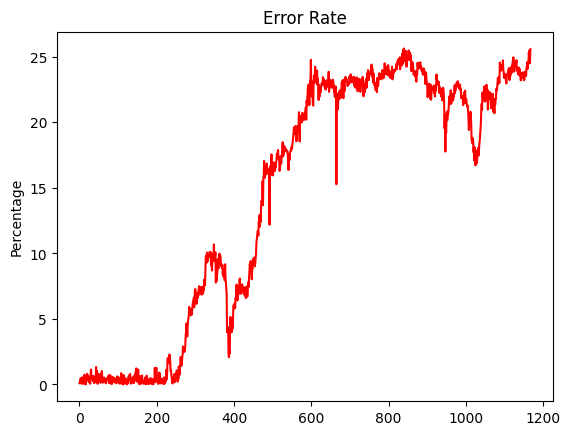

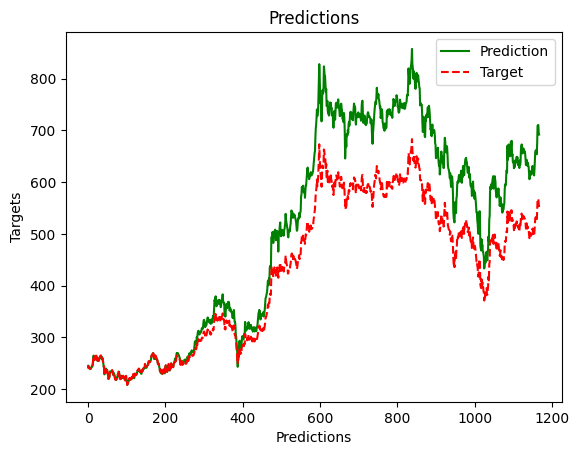

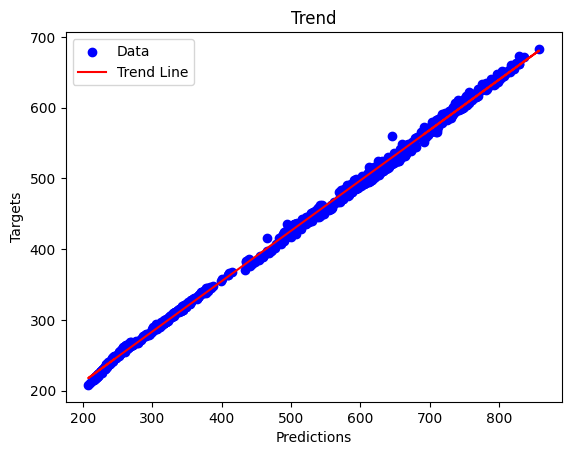

In [24]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    np.savetxt(file, preds, delimiter=',', fmt='%d', header='pred,target', comments='')

model = Stock_Model(input_dim=x_train.shape[1]).to(device)
model.load_state_dict(torch.load(config['save_path']))
preds = predict(test_loader, model, device)
save_pred(preds, 'pred.csv')
plot_error_rate(preds[:,0], preds[:,1])
plot_pred(preds[:,0], preds[:,1])
plot_trend(preds[:,0], preds[:,1])

In [25]:
model = Stock_Model(input_dim=x_train.shape[1]).to(device)
model.load_state_dict(torch.load(config['save_path']))

single_loader = stock_dataloader(config, [[100,110,90,101]], [103])
predict(single_loader, model, device)

# for pred, target in single_pred:
#     print(f"Prediction: {pred}, Target: {target}")

100%|██████████| 1/1 [00:00<00:00, 632.05it/s]


array([[105.91069, 103.     ]], dtype=float32)